# Setup Paths

```
module purge
rm -rf ~/sde_env
python -m venv ~/sde_env
source ~/sde_env/bin/activate

which python
python -m ensurepip --upgrade
python -m pip install --upgrade pip setuptools packaging
python -m pip install --no-index --no-user --prefix="$VIRTUAL_ENV" \
    dill KDEpy scikit-learn numpy scipy matplotlib pandas sympy sklearn
source ~/sde_env/bin/activate
python -m ipykernel install --user --name sde_env --display-name "Python (SDE Stack)"

python - <<'EOF'
import sys, numpy, scipy, matplotlib, sklearn, dill
print("python:", sys.executable)
print("numpy:", numpy.__file__, numpy.__version__)
print("scipy:", scipy.__file__)
print("matplotlib:", matplotlib.__file__)
print("sklearn:", sklearn.__file__)
print("dill:", dill.__file__)
EOF
```

Change kernel to something else and change it back

In [1]:
import sys
import os

target_folder_name = "SymbolicDensityEstimation"
# 1. Get the current directory of the notebook.
current_dir = os.getcwd()

# # 2. Join it with '..' to get the parent directory.
parent_dir = os.path.join(current_dir, '..')

# # 3. change directory
current_folder_name = os.path.basename(current_dir)
is_match = current_folder_name == target_folder_name
if not is_match:
    os.chdir(parent_dir)

# # Get the current working directory as a string
current_directory = os.getcwd()

print("The current working directory is:")
print(current_directory)

The current working directory is:
/home/angel/WIP/Research/SymbolicDensityEstimation


# Imports

In [ ]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

import numpy as np
from sklearn.neighbors import KernelDensity
import scipy
from scipy.stats import gaussian_kde
import pandas as pd
from config_management.data_config_4d_gaussian import DataConfig
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # Needed for 3D plotting
from matplotlib import cm  # For colormap
from KDEpy import FFTKDE
from scipy.stats import multivariate_normal
from scipy.interpolate import RegularGridInterpolator
import sympy as sp
from sympy.parsing.sympy_parser import parse_expr
import gc
import dill
from pgmpy.estimators import PC
import networkx as nx

# Data Exploration

In [ ]:
file_path = './data/gaussian_4d_samples.csv'
df = pd.read_csv(file_path)
print(df.head())
columns = ['x1', 'x2', 'x3', 'x4']
samples = df[columns].to_numpy()
# Extract m13^2 and m23^2 columns
x1 = df["x1"]
x2 = df["x2"]
x3 = df["x3"]
x4 = df["x4"]

         x1        x2        x3        x4
0  2.016969 -5.364023 -5.088255  4.329010
1  1.927835 -5.471277 -3.025009  4.879264
2  4.052371 -3.856527 -4.849410  4.070354
3  3.137654 -4.581622 -4.220948  3.990086
4  2.483591 -5.318407 -3.535281  3.924541


In [ ]:
from pgmpy.estimators import PC
df = pd.DataFrame(samples[:250000,:], columns=['x1', 'x2', 'x3', 'x4'])
est = PC(data=df)
estimated_model = est.estimate(ci_test='pearsonr', significance_level=1/250000)

# Get a graphviz object.
# model_graph = estimated_model.to_graphviz()
# # To open the plot
# model_graph.draw("./data/pgm.png", format='png', prog='dot')

G_dag = estimated_model  # Might raise if edges can't be fully oriented

plt.figure(figsize=(6,6))
pos = nx.circular_layout(G_dag)

nx.draw_networkx_nodes(G_dag, pos, node_color='lightgreen', node_size=1500)
nx.draw_networkx_labels(G_dag, pos, font_size=12)
nx.draw_networkx_edges(G_dag, pos, arrowstyle='->', arrowsize=20, edge_color='black')

plt.title("Estimated DAG via NetworkX")
plt.axis('off')
plt.show()

## Scatter Plot

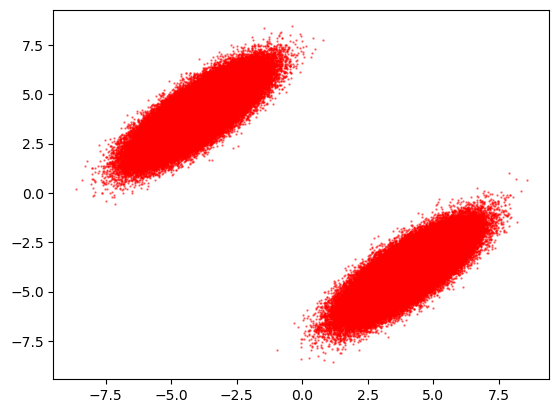

3250

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))  # 1 row, 2 columns

# Left subplot
axes[0].scatter(x1, x2, s=0.5, alpha=0.5, color='red', label='Data Points')
axes[0].set_title('PGM Cluster 1')
axes[0].set_xlabel('x1')
axes[0].set_ylabel('x2')

# Right subplot (example: same data or different)
axes[1].scatter(x3, x4, s=0.5, alpha=0.5, color='red', label='Data Points')
axes[1].set_title('PGM Cluster 2')
axes[1].set_xlabel('x3')
axes[1].set_ylabel('x4')

plt.tight_layout()
plt.show()
plt.show()
plt.close() 
gc.collect()

In [ ]:
if DataConfig.slices is None:
    wmin, wmax = x1.min()-DataConfig.grid_tolerance, x1.max()+DataConfig.grid_tolerance
    xmin, xmax = x2.min()-DataConfig.grid_tolerance, x2.max()+DataConfig.grid_tolerance   
    ymin, ymax = x3.min()-DataConfig.grid_tolerance, x3.max()+DataConfig.grid_tolerance 
    zmin, zmax = x4.min()-DataConfig.grid_tolerance, x4.max()+DataConfig.grid_tolerance 
    grids = np.mgrid[wmin:wmax:DataConfig.jxbins, xmin:xmax:DataConfig.jxbins, ymin:ymax:DataConfig.jxbins, zmin:zmax:DataConfig.jxbins]
else:
    slices = [slice(-13.0, 13.0, DataConfig.jxbins), slice(-13.0, 13.0, DataConfig.jxbins), slice(-13.0, 13.0, DataConfig.jxbins), slice(-13.0, 13.0, DataConfig.jxbins)]
    grids = np.mgrid[tuple(slices)]

grid_coordinates = np.vstack([grids[0].ravel(), grids[1].ravel(), grids[2].ravel(), grids[3].ravel()])
grid_coordinates = grid_coordinates.T

In [ ]:
with open(f"models/gaussian_4d_kde_wrapped.pkl", "rb") as f:
    wrapper_model = dill.load(f)

: 

In [ ]:
kde_predicted_density = wrapper_model.evaluate(grid_coordinates).reshape(grids[0].shape)

In [ ]:
axes = [
    grids[0][:,0,0,0],  # x1
    grids[1][0,:,0,0],  # x2
    grids[2][0,0,:,0],  # x3
    grids[3][0,0,0,:]   # x4
]

total_mass = np.trapezoid(
    np.trapezoid(
      np.trapezoid(
        np.trapezoid(kde_predicted_density, x=axes[3], axis=3),
      x=axes[2], axis=2),
    x=axes[1], axis=1),
  x=axes[0], axis=0)

print("total mass of joint:", total_mass)

# KDE Heatmap

In [ ]:
def conditional_and_marginal_generation(
    joint_density,
    grids,
    conditioning_xa_target,
    conditioning_xb_target,
    ab_idx,
    fill_value=0.0,
    trapz_tol=1e-12,
    log_plot=False,
    plot=True,
    contour_levels=60,
    total_mass = total_mass
):
    """
    Return an interpolated conditional slice p(xc,xd | xa=conditioning_xa_target, xb=conditioning_xb_target).

    Parameters
    ----------
    joint_density : ndarray
        4-D array with shape (N,N,N,N) representing the joint density p(x1,x2,x3,x4).
    grids : ndarray-like
        The output of np.mgrid for the 4 axes, shape (4, N, N, N, N).
        Each grids[i] contains the coordinate values for axis i.
    conditioning_xa_target, conditioning_xb_target : float
        The values of xa and xb to condition on.
    ab_idx: tuple
        Either (1,2) or (3,4)
    fill_value : float
        Value to use outside the grid in the interpolator (default 0.0).
    trapz_tol : float
        If marginal <= trapz_tol, raise an error (slice likely in tail / numerical underflow).
    log_plot : bool
        If True, plot log10(cond + eps) instead of cond.
    plot : bool
        If True, show a contourf plot of the conditional.
    contour_levels : int
        Number of contour levels for plotting.
    total_mass: float
        total mass of joint_density used for normalizing the marginal

    Returns
    -------
    X1, X2 : 2D arrays
        Meshgrid arrays for xc and xd (shape (N,N)).
    joint_density_on_slice : 2D array
        Interpolated joint p(xc,xd,xa=conditioning_xa_target,xb=conditioning_xb_target).
    conditional_density : 2D array
        Normalized conditional p(xc, xd | xa, xb).
    marginal_for_slice: float
        The marginal p(xa=conditioning_xa_target, xb=conditioning_xb_target) (approx).
    marginal_density: 2D array
        Marginal density p(xc, xd)
    """
    # Basic shape checks
    if joint_density.ndim != 4:
        raise ValueError("joint_density must be 4-D.")
    if len(grids) != 4:
        raise ValueError("grids must have length 4 (from np.mgrid).")
    assert (ab_idx == (1,2)) or (ab_idx == (3,4)), "Unsupported indices for conditioning"

    # --- extract separate 1-D axis arrays (preserve order and spacing) ---
    x1 = grids[0][:,0,0,0]
    x2 = grids[1][0,:,0,0]
    x3 = grids[2][0,0,:,0]
    x4 = grids[3][0,0,0,:]

    if not (np.allclose(x1, x2) and np.allclose(x2, x3) and np.allclose(x3, x4)):
        raise ValueError('Bad grids provided')

    if 3 in ab_idx and 4 in ab_idx:
        a_idx = 3
        b_idx = 4
        c_idx = 1
        d_idx = 2
    elif 1 in ab_idx and 2 in ab_idx:
        a_idx = 1
        b_idx = 2
        c_idx = 3
        d_idx = 4
    else:
        raise ValueError("bad ab_idx")

    

    # choose axis vectors in canonical order for interpolator
    axes = (x1, x2, x3, x4)
    for n, xi in enumerate(axes):
        if len(xi) != joint_density.shape[n]:
            raise ValueError(f"axis {n+1} length mismatch: {len(xi)} != {joint_density.shape[n]}")
    
    # quick monotonicity checks (clear error if not strictly increasing)
    for xi, name in ((x1,'x1'),(x2,'x2'),(x3,'x3'),(x4,'x4')):
        if not np.all(np.diff(xi) > 0):
            raise ValueError(f"Axis {name} is not strictly increasing.")

    # Build the interpolator with explicit axes
    # target-in-range sanity check (clear error if conditioning outside grid)
    xa_range = axes[a_idx-1][[0,-1]]
    xb_range = axes[b_idx-1][[0,-1]]
    if not (xa_range[0] <= conditioning_xa_target <= xa_range[1]):
        raise ValueError("conditioning_xa_target outside axis range")
    if not (xb_range[0] <= conditioning_xb_target <= xb_range[1]):
        raise ValueError("conditioning_xb_target outside axis range")
        
    interp = RegularGridInterpolator(axes, joint_density, bounds_error=False, fill_value=fill_value)

    # Determine which axes are c,d and which are a,b
    if (a_idx, b_idx) == (3,4):   # you already set a_idx,b_idx earlier
        x_c = x1; x_d = x2
    else:
        x_c = x3; x_d = x4

    # Build mesh for c,d using their true axes
    Xc, Xd = np.meshgrid(x_c, x_d, indexing='ij')

    if 3 in ab_idx and 4 in ab_idx:
    # Prepare query points for (conditioning_xa_target, conditioning_xb_target)
        pts = np.column_stack([
            Xc.ravel(),
            Xd.ravel(),
            np.full(Xc.size, conditioning_xa_target),
            np.full(Xc.size, conditioning_xb_target)
        ])  # shape (N*N, 4)
    elif 1 in ab_idx and 2 in ab_idx:
    # Prepare query points for (xc_target, xd_target)
        pts = np.column_stack([
            np.full(Xc.size, conditioning_xa_target),
            np.full(Xc.size, conditioning_xb_target),
            Xc.ravel(),
            Xd.ravel(),
        ])  # shape (N*N, 4)  
    else:
        raise ValueError("Bad conditonal indices")

    # Evaluate interpolated joint density on the plane
    density_flat = interp(pts)              # (N*N,)
    joint_density_on_slice = density_flat.reshape(Xc.shape)  # (N,N)

    # Compute marginal p(xa,xb) by integrating joint_density_on_slice over xc,xd
    # integrate over c,d using the correct x arrays (x_d then x_c)
    marginal_for_slice = np.trapezoid(
        np.trapezoid(joint_density_on_slice, x=x_d, axis=1),
        x=x_c, axis=0
    )

    if not np.isfinite(marginal_for_slice) or marginal_for_slice <= trapz_tol:
        raise ValueError(
            f"Marginal at (x{ab_idx[0]}={conditioning_xa_target}, x{ab_idx[1]}={conditioning_xb_target}) is zero, too small, or non-finite: {marginal_for_slice}. "
            "This usually means the slice is in the extreme tail (densities ~ 0) or numeric underflow."
        )

    conditional_density = joint_density_on_slice / marginal_for_slice

    axis_a = a_idx - 1
    axis_b = b_idx - 1

    first = max(axis_a, axis_b)
    second = min(axis_a, axis_b)

    tmp = np.trapezoid(joint_density, axes[first], axis=first)
    marginal_density = np.trapezoid(tmp, axes[second], axis=second)
    marginal_density = marginal_density/total_mass

    # Plot if requested
    if plot:
        plt.figure(figsize=(8,6))
        if log_plot:
            eps = 1e-20
            data_to_plot = np.log10(conditional_density + eps)
            label = f'log10 p(x{c_idx},x{d_idx} | x{a_idx}, x{b_idx})'
        else:
            data_to_plot = conditional_density
            label = f'p(x{c_idx},x{d_idx} | x{a_idx}, x{b_idx})'

        cf = plt.contourf(Xc, Xd, data_to_plot, levels=contour_levels)
        cbar = plt.colorbar(cf)
        cbar.set_label(label)
        plt.xlabel(f'x{c_idx}')
        plt.ylabel(f'x{d_idx}')
        plt.title(f'Conditional p(x{c_idx},x{d_idx} | x{a_idx}={conditioning_xa_target}, x{b_idx}={conditioning_xb_target})')
        plt.tight_layout()
        plt.show()
        plt.figure(figsize=(8,6))
        cf = plt.contourf(Xc, Xd, marginal_density, levels=contour_levels, cmap='viridis')
        plt.title(f'Marginal p(x{c_idx}, x{d_idx})')
        label = f'p(x{c_idx},x{d_idx})'
        cbar = plt.colorbar(cf)
        cbar.set_label(label)
        plt.xlabel(f'x{c_idx}')
        plt.ylabel(f'x{d_idx}')
        plt.tight_layout()
        plt.show()

    return Xc, Xd, joint_density_on_slice, conditional_density, marginal_for_slice, marginal_density

### Debug conditional and marginal generation

In [ ]:
c_idx = 1 
d_idx = 2 
a_idx = 3 
b_idx = 4

# build 1D axes exactly as in your function 
axes = [ 
    grids[0][:,0,0,0], # x1 
    grids[1][0,:,0,0], # x2 
    grids[2][0,0,:,0], # x3 
    grids[3][0,0,0,:] # x4 
]

X1, X2, kde12_joint_density_on_slice, kde12_conditional_density, kde12_marginal_for_slice, kde12_marginal_density = conditional_and_marginal_generation( 
    joint_density=kde_predicted_density, 
    grids=grids, 
    conditioning_xa_target=-4.0, 
    conditioning_xb_target=4.0, 
    ab_idx = (a_idx, b_idx), 
    plot=False, 
    log_plot=False, # use log scale for tail densities trapz_tol=1e-20, # lower tolerance to accept tiny marginals 
)

# which indices did your function set for c,d? (1-based) 
print("c_idx, d_idx:", c_idx, d_idx) # pick the exact 1D arrays for integration over the conditional output 
x_c = axes[c_idx-1] 
x_d = axes[d_idx-1]

# integral of conditional (should be ~1) 
I_cond = np.trapezoid(np.trapezoid(kde12_conditional_density, x=x_d, axis=1), x=x_c, axis=0) 
print("∫ cond =", I_cond)

# integral of marginal_density using the same (c,d) axes (should be ~1 for normalized joint) 
I_marg = np.trapezoid(np.trapezoid(kde12_marginal_density, x=x_d, axis=1), x=x_c, axis=0) 
print("∫ marginal (p(x_c,x_d)) =", I_marg)

# recompute marginal directly from full joint and compare 
def compute_marginal_cd_from_joint(kde_predicted_density, axes, a_idx, b_idx): 
    axis_a = a_idx - 1 
    axis_b = b_idx - 1 
    first = max(axis_a, axis_b) 
    second = min(axis_a, axis_b) 
    tmp = np.trapezoid(kde_predicted_density, x=axes[first], axis=first) 
    marg_cd = np.trapezoid(tmp, x=axes[second], axis=second) / total_mass
    return marg_cd

marg_from_joint = compute_marginal_cd_from_joint(kde_predicted_density, axes, a_idx, b_idx) 
print("max abs diff between marginal_density and recomputed:", np.max(np.abs(kde12_marginal_density - marg_from_joint)))

## KDE Marginals and Conditional Plots

In [ ]:
X1, X2, kde12_joint_density_on_slice, kde12_conditional_density, kde12_marginal_for_slice, kde12_marginal_density = conditional_and_marginal_generation(
    joint_density=kde_predicted_density,
    grids=grids,
    conditioning_xa_target=-4.0,
    conditioning_xb_target=4.0,
    ab_idx = (3,4),
    plot=False,
    log_plot=False,      # use log scale for tail densities
    trapz_tol=1e-20,    # lower tolerance to accept tiny marginals
)

X3, X4, kde34_joint_density_on_slice, kde34_conditional_density, kde34_marginal_for_slice, kde34_marginal_density = conditional_and_marginal_generation(
    joint_density=kde_predicted_density,
    grids=grids,
    conditioning_xa_target=4.0,
    conditioning_xb_target=-4.0,
    ab_idx = (1,2),
    plot=False,
    log_plot=False,      # use log scale for tail densities
    trapz_tol=1e-20,    # lower tolerance to accept tiny marginals
)

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

cf00 = axs[0, 0].contourf(X1, X2, kde12_conditional_density, levels=60)
fig.colorbar(cf00, ax=axs[0, 0])
axs[0, 0].set_title("KDE Conditional p(x1, x2 | x3=-4.0, x4=4.0)")
axs[0, 0].set_xlim([-4, 12])
axs[0, 0].set_ylim([-12, 4])

cf01 = axs[0, 1].contourf(X1, X2, kde12_marginal_density, levels=60)
fig.colorbar(cf01, ax=axs[0, 1])
axs[0, 1].set_title("KDE Marginal p(x1, x2)")
axs[0, 1].set_xlim([-4, 12])
axs[0, 1].set_ylim([-12, 4])

cf10 = axs[1, 0].contourf(X3, X4, kde34_conditional_density, levels=60)
fig.colorbar(cf10, ax=axs[1, 0])
axs[1, 0].set_title("KDE Conditional p(x3, x4 | x1=4.0, x2=-4.0)")
axs[1, 0].set_xlim([-12, 4])
axs[1, 0].set_ylim([-4, 12])

cf11 = axs[1, 1].contourf(X3, X4, kde34_marginal_density, levels=60)
fig.colorbar(cf11, ax=axs[1, 1])
axs[1, 1].set_title("KDE Marginal p(x3, x4)")
axs[1, 1].set_xlim([-12, 4])
axs[1, 1].set_ylim([-4, 12])

for ax in axs.flat:
    ax.set_xlabel("x")
    ax.set_ylabel("y")

plt.tight_layout()
plt.show()

## Ground Truth Defintion

In [ ]:
pow2 = lambda x: x ** 2
pow3 = lambda x: x ** 3
pow4 = lambda x: x ** 4
pow5 = lambda x: x ** 5

def ground_truth_cluster_2(x1, x2):
    # Mean and covariance
    mu = [-4, 4]
    sigma = [[1, 0.8], [0.8, 1]]
    
    # Stack grid into a (..., 2) shape expected by multivariate_normal
    pos = np.stack([x1, x2], axis=-1)
    
    # Evaluate the PDF
    rv = multivariate_normal(mean=mu, cov=sigma)
    return rv.pdf(pos)

def ground_truth_cluster_1(x1, x2):
    # Mean and covariance
    mu = [4, -4]
    sigma = [[1, 0.8], [0.8, 1]]
    
    # Stack grid into a (..., 2) shape expected by multivariate_normal
    pos = np.stack([x1, x2], axis=-1)
    
    # Evaluate the PDF
    rv = multivariate_normal(mean=mu, cov=sigma)
    return rv.pdf(pos)

ground_truth_density = ground_truth_cluster_1(grids[0], grids[1]) * ground_truth_cluster_2(grids[2], grids[3])

In [ ]:
X1, X2, groundtruth12_joint_density, groundtruth12_conditional_density, groundtruth12_marginal_for_slice, groundtruth12_marginal_density = conditional_and_marginal_generation(
    joint_density=ground_truth_density,
    grids=grids,
    conditioning_xa_target=-4.0,
    conditioning_xb_target=4.0,
    ab_idx = (3,4),
    plot=False,
    log_plot=False,      # use log scale for tail densities
    trapz_tol=1e-20,    # lower tolerance to accept tiny marginals
)

X1, X2, groundtruth34_joint_density, groundtruth34_conditional_density, groundtruth34_marginal_for_slice, groundtruth34_marginal_density = conditional_and_marginal_generation(
    joint_density=ground_truth_density,
    grids=grids,
    conditioning_xa_target=4.0,
    conditioning_xb_target=-4.0,
    ab_idx = (1,2),
    plot=False,
    log_plot=False,      # use log scale for tail densities
    trapz_tol=1e-20,    # lower tolerance to accept tiny marginals
)

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

cf00 = axs[0, 0].contourf(X1, X2, groundtruth12_conditional_density, levels=60)
fig.colorbar(cf00, ax=axs[0, 0])
axs[0, 0].set_title("Ground Truth Integrated Conditional p(x1, x2 | x3=-4.0, x4=4.0)")
axs[0, 0].set_xlim([-4, 12])
axs[0, 0].set_ylim([-12, 4])

cf01 = axs[0, 1].contourf(X1, X2, groundtruth12_marginal_density, levels=60)
fig.colorbar(cf01, ax=axs[0, 1])
axs[0, 1].set_title("Ground Truth Integrated Marginal p(x1, x2)")
axs[0, 1].set_xlim([-4, 12])
axs[0, 1].set_ylim([-12, 4])

cf10 = axs[1, 0].contourf(X3, X4, groundtruth34_conditional_density, levels=60)
fig.colorbar(cf10, ax=axs[1, 0])
axs[1, 0].set_title("Ground Truth Integrated Conditional p(x3, x4 | x1=4.0, x2=-4.0)")
axs[1, 0].set_xlim([-12, 4])
axs[1, 0].set_ylim([-4, 12])

cf11 = axs[1, 1].contourf(X3, X4, groundtruth34_marginal_density, levels=60)
fig.colorbar(cf11, ax=axs[1, 1])
axs[1, 1].set_title("Ground Truth Integrated Marginal p(x3, x4)")
axs[1, 1].set_xlim([-12, 4])
axs[1, 1].set_ylim([-4, 12])

for ax in axs.flat:
    ax.set_xlabel("x")
    ax.set_ylabel("y")

plt.tight_layout()
plt.show()

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

cf00 = axs[0, 0].contourf(X1, X2, ground_truth_cluster_1(X1, X2), levels=60)
fig.colorbar(cf00, ax=axs[0, 0])
axs[0, 0].set_title("Ground Truth True Conditional p(x1, x2 | x3=-4.0, x4=4.0)")
axs[0, 0].set_xlim([-4, 12])
axs[0, 0].set_ylim([-12, 4])

cf01 = axs[0, 1].contourf(X1, X2, ground_truth_cluster_1(X1, X2), levels=60)
fig.colorbar(cf01, ax=axs[0, 1])
axs[0, 1].set_title("Ground Truth True Marginal p(x1, x2)")
axs[0, 1].set_xlim([-4, 12])
axs[0, 1].set_ylim([-12, 4])

cf10 = axs[1, 0].contourf(X3, X4, ground_truth_cluster_2(X3, X4), levels=60)
fig.colorbar(cf10, ax=axs[1, 0])
axs[1, 0].set_title("Ground Truth True Conditional p(x3, x4 | x1=4.0, x2=-4.0)")
axs[1, 0].set_xlim([-12, 4])
axs[1, 0].set_ylim([-4, 12])

cf11 = axs[1, 1].contourf(X3, X4, ground_truth_cluster_2(X3, X4), levels=60)
fig.colorbar(cf11, ax=axs[1, 1])
axs[1, 1].set_title("Ground Truth True Marginal p(x3, x4)")
axs[1, 1].set_xlim([-12, 4])
axs[1, 1].set_ylim([-4, 12])

for ax in axs.flat:
    ax.set_xlabel("x")
    ax.set_ylabel("y")

plt.tight_layout()
plt.show()

In [ ]:
xlim = (-13, 13)
ylim = (-13, 13)
color_level_min, color_level_max = 0.0, 0.25

res_color_level_min, res_color_level_max = -0.025, 0.025
levels = np.linspace(res_color_level_min, res_color_level_max, 100)  # for 100 intervals

## Residual of KDE and Ground Truth

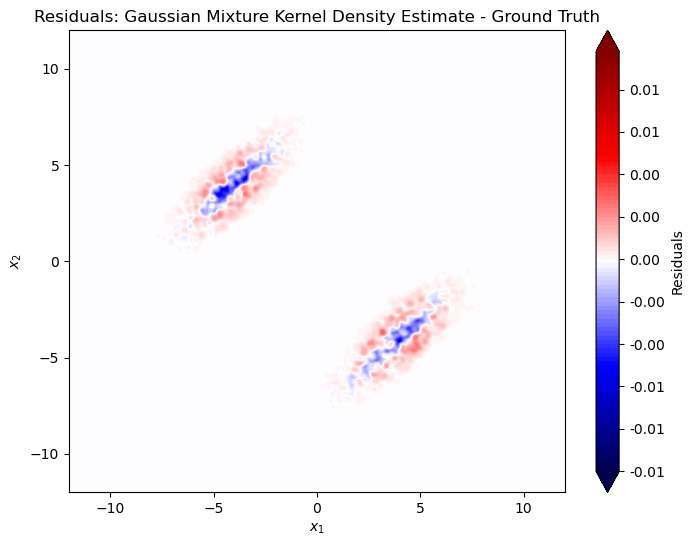

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

cf00 = axs[0, 0].contourf(X1, X2, kde12_conditional_density - ground_truth_cluster_1(X1, X2), levels=levels, cmap="seismic", extend="both")
fig.colorbar(cf00, ax=axs[0, 0])
axs[0, 0].set_title("Ground Truth True Conditional p(x1, x2 | x3=-4.0, x4=4.0)")
axs[0, 0].set_xlim([-4, 12])
axs[0, 0].set_ylim([-12, 4])

cf01 = axs[0, 1].contourf(X1, X2, kde12_marginal_density - ground_truth_cluster_1(X1, X2), levels=levels, cmap="seismic", extend="both")
fig.colorbar(cf01, ax=axs[0, 1])
axs[0, 1].set_title("Ground Truth True Marginal p(x1, x2)")
axs[0, 1].set_xlim([-4, 12])
axs[0, 1].set_ylim([-12, 4])

cf10 = axs[1, 0].contourf(X3, X4, kde34_conditional_density - ground_truth_cluster_2(X3, X4), levels=levels, cmap="seismic", extend="both")
fig.colorbar(cf10, ax=axs[1, 0])
axs[1, 0].set_title("Ground Truth True Conditional p(x3, x4 | x1=4.0, x2=-4.0)")
axs[1, 0].set_xlim([-12, 4])
axs[1, 0].set_ylim([-4, 12])

cf11 = axs[1, 1].contourf(X3, X4, kde34_marginal_density - ground_truth_cluster_2(X3, X4), levels=levels, cmap="seismic", extend="both")
fig.colorbar(cf11, ax=axs[1, 1])
axs[1, 1].set_title("Ground Truth True Marginal p(x3, x4)")
axs[1, 1].set_xlim([-12, 4])
axs[1, 1].set_ylim([-4, 12])

for ax in axs.flat:
    ax.set_xlabel("x")
    ax.set_ylabel("y")

plt.tight_layout()
plt.show()

print(f"max conditional p(x1,x2|x3=-4,x4=4) residual = {np.max(kde12_conditional_density - ground_truth_cluster_1(X1, X2))}")
print(f"max conditional p(x3,x4|x1=4,x2=-4) residual = {np.max(kde34_conditional_density - ground_truth_cluster_2(X3, X4))}")
print(f"max marginal p(x1,x2) residual = {np.max(kde12_conditional_density - ground_truth_cluster_1(X1, X2))}")
print(f"max marginal p(x3,x4) residual = {np.max(kde34_conditional_density - ground_truth_cluster_2(X3, X4))}\n")
print(f"min conditional p(x1,x2|x3=-4,x4=4) residual = {np.min(kde12_conditional_density - ground_truth_cluster_1(X1, X2))}")
print(f"min conditional p(x3,x4|x1=4,x2=-4) residual = {np.min(kde34_conditional_density - ground_truth_cluster_2(X3, X4))}")
print(f"min marginal p(x1,x2) residual = {np.min(kde12_conditional_density - ground_truth_cluster_1(X1, X2))}")
print(f"min marginal p(x3,x4) residual = {np.min(kde34_conditional_density - ground_truth_cluster_2(X3, X4))}\n")

In [ ]:
density_scale_factor = np.loadtxt("data/processed_data/gaussian_4d_scale_factor.txt")
print(f"scale factor: {density_scale_factor}")
print(f"max kde density: {np.max(kde_predicted_density)}, min kde density: {np.min(kde_predicted_density)}")
print(f"max ground truth density: {np.max(ground_truth_density)}, min ground truth density: {np.min(ground_truth_density)}")
print(f"max integrated conditonal kde12 density: {np.max(kde12_conditional_density)}, min kde12 density: {np.min(kde12_conditional_density)}")
print(f"max integrated marginal kde12 density: {np.max(kde12_marginal_density)}, min kde12 density: {np.min(kde12_marginal_density)}")
print(f"max integrated conditonal kde34 density: {np.max(kde34_conditional_density)}, min kde34 density: {np.min(kde34_conditional_density)}")
print(f"max integrated marginal kde34 density: {np.max(kde34_marginal_density)}, min kde34 density: {np.min(kde34_marginal_density)}")
kde_predicted_density_scaled = kde_predicted_density * density_scale_factor
ground_truth_density_scaled = ground_truth_density * density_scale_factor
print(f"max scaled kde density: {np.max(kde_predicted_density_scaled)}, min scaled kde density: {np.min(kde_predicted_density_scaled)}")
print(f"max scaled ground truth density: {np.max(ground_truth_density_scaled)}, min scaled ground truth density: {np.min(ground_truth_density_scaled)}")

data_in_pipeline = np.loadtxt('data/processed_data/gaussian_4d_joint_data_in_pipeline.csv', delimiter=',', skiprows=1)
print(f"max data in pipeline: {np.max(data_in_pipeline[:,2])}, min data in pipeline: {np.min(data_in_pipeline[:,2])}")


scale factor: 77.11711358644611
max kde density: 0.12967290313310673, min kde density: 1.8987957000882954e-16
max ground truth density: 0.13259588307965184, min ground truth density: 1.4073582928999856e-140
max scaled kde density: 10.000000000000014, min scaled kde density: 1.4642964368116455e-14
max scaled ground truth density: 10.225411776548638, min scaled ground truth density: 1.0853140933039509e-138
max data in pipeline: 10.000000000000014, min data in pipeline: 1.4642964368116455e-14


# Results

In [12]:
pow2 = lambda x: x ** 2
pow3 = lambda x: x ** 3
pow4 = lambda x: x ** 4
pow5 = lambda x: x ** 5

In [ ]:
file_path = "data/pareto_results/gaussian_4d_results.py"
exec(open(file_path).read())

Original at complexity 1: 0.13353131139388197
function_ready: 0.13353131139388197
Processed: 0.130000000000000
LaTeX: 0.13

Original at complexity 2: pow2(-0.36542688537507617)
function_ready: pow2(-0.36542688537507617)
Processed: pow2(-0.37)
LaTeX: 0.14

Original at complexity 3: pow2(pow3(0.7149413459846815))
function_ready: pow2(pow3(0.7149413459846815))
Processed: pow2(pow3(0.71))
LaTeX: 0.13

Original at complexity 5: pow2(-0.36542688537507617 - pow3(0.026666557631729104))
function_ready: pow2(-0.36542688537507617 - pow3(0.026666557631729104))
Processed: pow2(-pow3(0.027) - 0.37)
LaTeX: 0.14

Original at complexity 6: 0.24487967126076696 - pow2(x2 * 0.04750132657271141)
function_ready: 0.24487967126076696 - pow2(x2 * 0.04750132657271141)
Processed: 0.24 - pow2(0.048*x2)
LaTeX: 0.24 - 0.0023 x_{2}^{2}

Original at complexity 7: exp(pow2(x2 + x1) * -0.2257331054145298)
function_ready: np.exp(pow2(x2 + x1) * -0.2257331054145298)
Processed: exp(-0.23*pow2(x1 + x2))
LaTeX: e^{- 0.23 \l

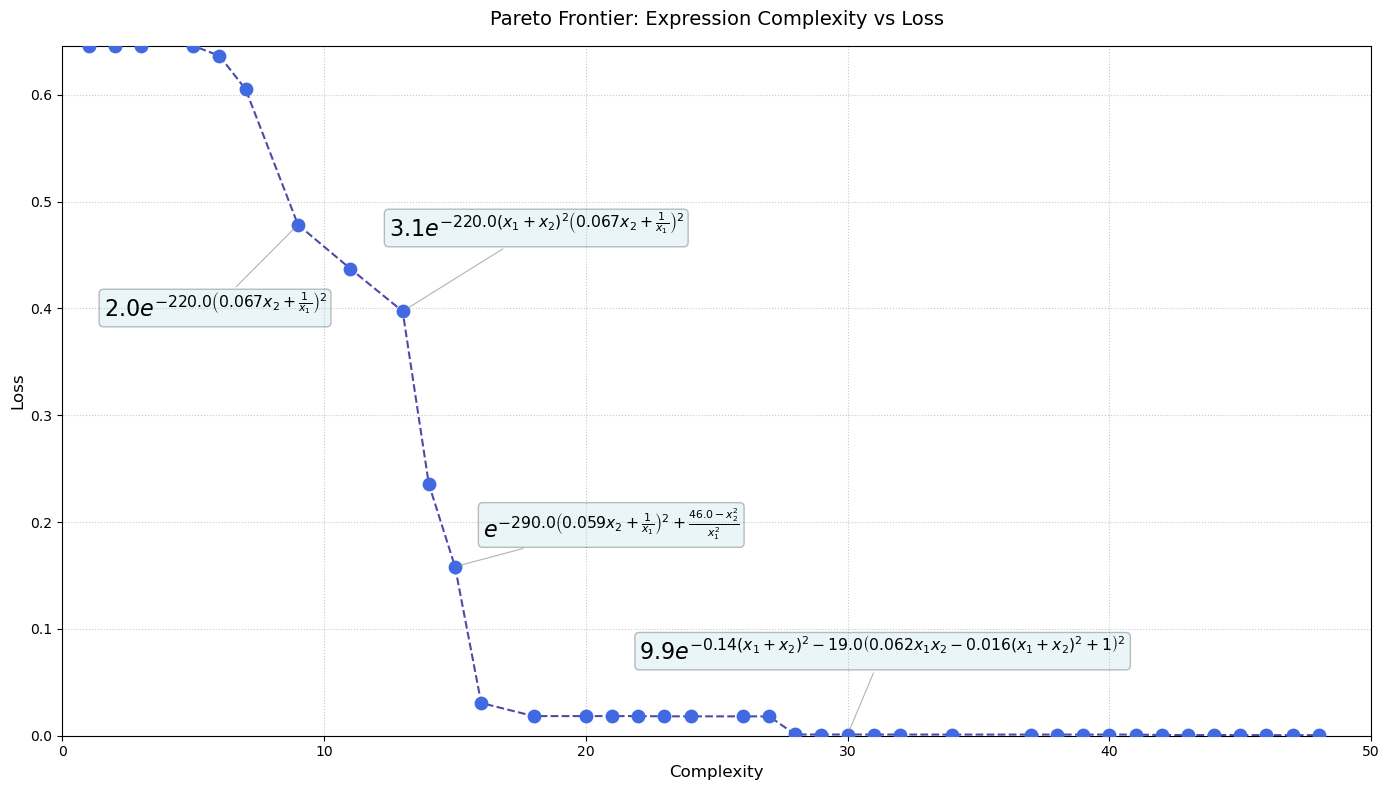

In [ ]:
range_of_interest = (1, 48)
indices_of_interest = [i for i, c in enumerate(complexity) if range_of_interest[0] <= c <= range_of_interest[1]]
complexity = [complexity[i] for i in indices_of_interest]
loss = [loss[i] for i in indices_of_interest]
raw_equations = [raw_equations[i] for i in indices_of_interest]

# 2) Sympy setup
x1, x2, x3, x4 = sp.symbols('x1 x2 x3 x4')

# 3) Custom function to round constants only (not function arguments)
def round_constants(expr, ndigits=1):
    """
    Round every bare Float in `expr` so that, when printed,
    it has exactly `ndigits` digits after the decimal point
    in scientific notation (i.e. nd+1 significant figures).
    """
    def _is_leaf_float(e):
        return e.is_Float and not e.args

    def _round_sci(e):
        f = float(e)
        # format with `ndigits` places after the decimal in the mantissa:
        sci_str = f"{f:.{ndigits}e}"
        return sp.Float(sci_str)

    return expr.replace(_is_leaf_float, _round_sci)

# 4) Function to convert pow2 to squared form without evaluation
def convert_pow2(expr):
    # Find all pow2 calls
    if expr.func.__name__ == 'pow2':
        return sp.Pow(convert_pow2(expr.args[0]), 2, evaluate=False)
    # Recurse through expression
    return expr.func(*[convert_pow2(arg) for arg in expr.args]) if expr.args else expr

def convert_pow3(expr):
    # Find all pow3 calls
    if expr.func.__name__ == 'pow3':
        return sp.Pow(convert_pow3(expr.args[0]), 3, evaluate=False)
    # Recurse through expression
    return expr.func(*[convert_pow3(arg) for arg in expr.args]) if expr.args else expr

def convert_pow4(expr):
    # Find all pow4 calls
    if expr.func.__name__ == 'pow4':
        return sp.Pow(convert_pow4(expr.args[0]), 4, evaluate=False)
    # Recurse through expression
    return expr.func(*[convert_pow4(arg) for arg in expr.args]) if expr.args else expr

def convert_pow5(expr):
    # Find all pow5 calls
    if expr.func.__name__ == 'pow5':
        return sp.Pow(convert_pow5(expr.args[0]), 5, evaluate=False)
    # Recurse through expression
    return expr.func(*[convert_pow5(arg) for arg in expr.args]) if expr.args else expr

# 4) Function to convert pow_int without evaluation
def convert_pow_int(expr):
    # Find all pow_int calls
    if expr.func.__name__ == 'pow_int':
        base, exp = expr.args
        # If exp is literally an integer, convert to a Python int
        if exp.is_integer and exp.is_number:
            exp = int(exp)
        # Otherwise leave exp symbolic
        return sp.Pow(convert_pow_int(base), convert_pow_int(exp), evaluate=False)

    # Recursively descend into all other function applications
    if expr.args:
        return expr.func(*[convert_pow_int(arg) for arg in expr.args])
    else:
        return expr
    
def replace_pow_functions_recursive(expr: sp.Expr) -> sp.Expr:
    """
    Recursively replaces custom functions like powN(x) with standard power notation x**N.
    E.g. pow3(x + pow2(y)) → (x + y**2)**3
    """
    # First, apply recursively to all arguments (bottom-up),
    # so that nested pow-functions inside arguments get replaced too.
    expr = expr.xreplace({})  # no-op; just ensures expr is a Basic (not strictly needed)

    # Define replacement function
    def _repl(f):
        # check it's a function call
        if not isinstance(f, sp.Function):
            return f

        name = f.func.__name__
        if not name.startswith("pow"):
            return f

        # parse N from “powN”
        try:
            N = int(name[len("pow"):])
        except ValueError:
            return f

        if len(f.args) != 1:
            # unexpected arity, leave unchanged
            return f

        base = f.args[0]
        # Recursively transform the base
        new_base = replace_pow_functions_recursive(base)
        return new_base ** N

    # Use replace with map=False (so it returns an Expr)
    new_expr = expr.replace(
        lambda x: isinstance(x, sp.Function) and x.func.__name__.startswith("pow"),
        _repl,
        map=False
    )
    return new_expr

# 5) Build MathText labels
latex_labels = []
exprs_final = []
function_ready = []
for id, s in enumerate(raw_equations):
    try:
        # Pre-process pow2 -> custom function
        s_processed = s.replace('pow2', 'pow2_func')
        s_processed = s.replace('pow3', 'pow3_func')
        s_processed = s.replace('pow4', 'pow4_func')
        s_processed = s.replace('pow5', 'pow5_func')
        s_processed = s_processed.replace('pow_int', 'pow_int_func')
        
        # Define custom functions
        locals_dict = {
            'x1': x1,
            'x2': x2,
            'x3': x3,
            'x4': x4,
            'pow2_func': sp.Function('pow2'),
            'pow3_func': sp.Function('pow3'),
            'pow4_func': sp.Function('pow4'),
            'pow5_func': sp.Function('pow5'),
            'pow_int_func': sp.Function('pow_int'),
            'asin': sp.asin,
            'atan': sp.atan,
            'tan': sp.tan,
            'exp': sp.exp,
        }
        
        # Parse while preserving structure
        expr = parse_expr(s_processed, evaluate=False, local_dict=locals_dict)
        
        # Convert pow2_func to squared form
        expr_converted_pow2 = convert_pow2(expr)
        expr_converted_pow3 = convert_pow3(expr)
        expr_converted_pow4 = convert_pow4(expr)
        expr_converted_pow5 = convert_pow5(expr)
        expr_converted = convert_pow_int(expr_converted_pow5)
        
        # Round constants (only standalone floats)
        expr_converted_int1 = round_constants(expr_converted)
        expr_converted_int2 = round_constants(expr_converted_int1)
        expr_final = round_constants(expr_converted_int2)
        # expr_final = expr_final.simplify()
        # expr_final = expr_final.expand()
        exprs_final.append(expr_final)

        # Get MathText-friendly LaTeX
        mt = replace_pow_functions_recursive(expr_final)
        expr_converted_int1 = round_constants(mt)
        expr_converted_int2 = round_constants(expr_converted_int1)
        mt = round_constants(expr_converted_int2)
        mt = sp.latex(mt)
        latex_labels.append(f"${mt}$")
        
        # Replace 'exp' with 'np.exp'
        modified_expression = s.replace('exp', 'np.exp')
    
        # Replace 'log' with 'np.log'
        modified_expression = modified_expression.replace('log', 'np.log')
        function_ready.append(modified_expression)
        # Debug print
        print(f"Original at complexity {complexity[id]}: {s}")
        print(f"function_ready: {modified_expression}")
        print(f"Processed: {expr_final}")
        print(f"LaTeX: {mt}\n")
    except Exception as e:
        print(f"Error processing expression: {s}\n{e}")
        latex_labels.append(f"Error: {s}")

# 6) Manual offsets for clarity
offsets = [
    (0, 0), (0, 0), (0, 0), (0, 0), (0, 0),
    (0, 0), (-140, -60), (0, 0), (-10, 60), (0, 0),
    (20, 30), (0, 0), (0, 0), (0, 0), (0, 0),
    (0, 0), (0, 0), (0, 0), (0, 0), (0, 0),
    (0, 0), (0, 0), (-150, 60), (0, 0), (0, 0),
]

# 7) Plot
fig, ax = plt.subplots(figsize=(14, 8))
ax.scatter(complexity, loss, s=80, zorder=3, color='royalblue')
ax.plot(complexity, loss, linestyle='--', alpha=0.7, zorder=2, color='navy')

# Set axis limits
ax.set_xlim(min(complexity) - 1, max(complexity) + 2)
ax.set_ylim(min(loss) - 0.0005, max(loss))
fig.subplots_adjust(right=0.75)


skip_indices = []
keep_indices = [7-1, 9-1, 11-1, 23-1]
# Annotate with MathText labels
for i, (x, y, lbl, (dx, dy)) in enumerate(zip(complexity, loss, latex_labels, offsets)):
    if i in skip_indices or (i not in keep_indices):
        continue
    ax.annotate(
        lbl,
        xy=(x, y),
        xytext=(dx, dy),
        textcoords='offset points',
        ha='left',
        va='center',
        fontsize=16,
        bbox=dict(boxstyle='round,pad=0.2', alpha=0.25, fc='lightblue'),
        arrowprops=dict(arrowstyle='-', lw=0.8, alpha=0.6, color='gray')
    )

ax.set_title("Pareto Frontier: Expression Complexity vs Loss", fontsize=14, pad=15)
ax.set_xlabel("Complexity", fontsize=12)
ax.set_ylabel("Loss", fontsize=12)
ax.grid(True, linestyle=':', alpha=0.7)
ax.tick_params(axis='both', which='major', labelsize=10)

plt.tight_layout()
plt.show()

# Residuals: Prediction - Ground Truth

In [ ]:
level_min = 0
level_max = 0.25
level_min_delta = -0.25
level_max_delta = 0.25

levels_results = np.linspace(level_min, level_max, num=10)
levels_results_residuals = np.linspace(level_min_delta, level_max_delta, num=100)

In [ ]:
predicted_functions = [eval(f'lambda x1, x2, x3, x4: {str_func}', {'np':np, 'pow2':pow2, 'pow3':pow3, 'pow4':pow4, 'pow5':pow5}) for str_func in function_ready]

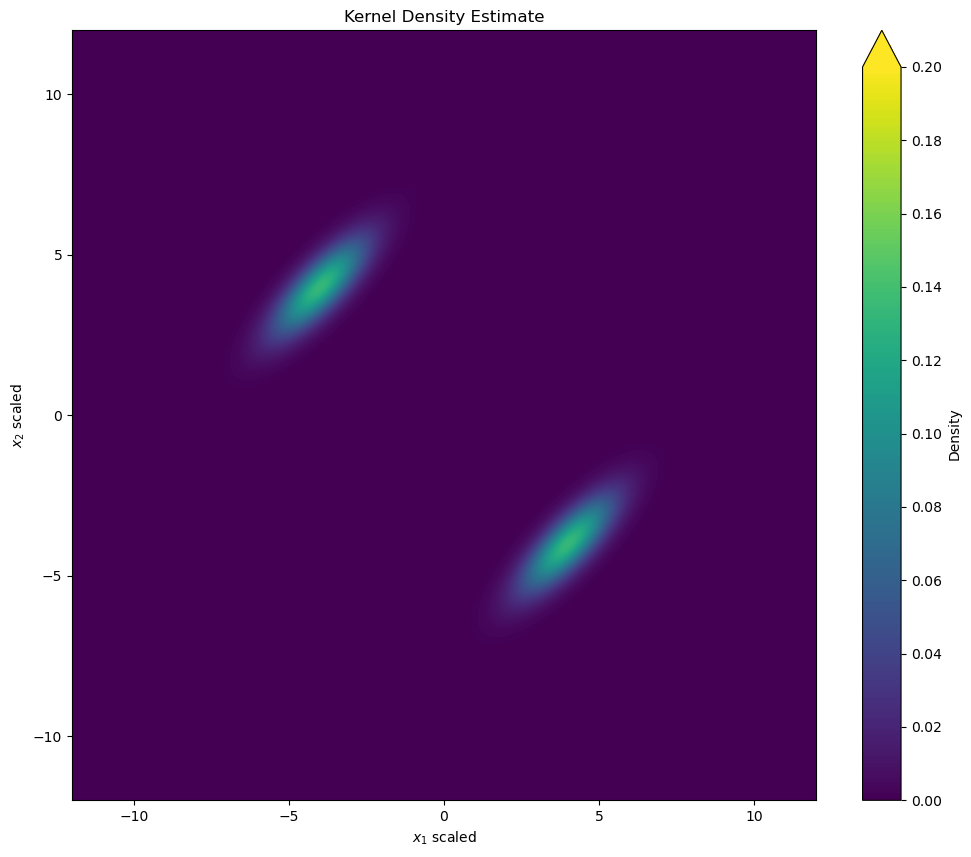

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

cf00 = axs[0, 0].contourf(X1, X2, kde12_conditional_density, levels=60)
fig.colorbar(cf00, ax=axs[0, 0])
axs[0, 0].set_title("KDE Conditional p(x1, x2 | x3=-4.0, x4=4.0)")
axs[0, 0].set_xlim([-4, 12])
axs[0, 0].set_ylim([-12, 4])

cf01 = axs[0, 1].contourf(X1, X2, kde12_marginal_density, levels=60)
fig.colorbar(cf01, ax=axs[0, 1])
axs[0, 1].set_title("KDE Marginal p(x1, x2)")
axs[0, 1].set_xlim([-4, 12])
axs[0, 1].set_ylim([-12, 4])

cf10 = axs[1, 0].contourf(X3, X4, kde34_conditional_density, levels=60)
fig.colorbar(cf10, ax=axs[1, 0])
axs[1, 0].set_title("KDE Conditional p(x3, x4 | x1=4.0, x2=-4.0)")
axs[1, 0].set_xlim([-12, 4])
axs[1, 0].set_ylim([-4, 12])

cf11 = axs[1, 1].contourf(X3, X4, kde34_marginal_density, levels=60)
fig.colorbar(cf11, ax=axs[1, 1])
axs[1, 1].set_title("KDE Marginal p(x3, x4)")
axs[1, 1].set_xlim([-12, 4])
axs[1, 1].set_ylim([-4, 12])

for ax in axs.flat:
    ax.set_xlabel("x")
    ax.set_ylabel("y")

plt.tight_layout()
plt.show()

In [ ]:
# 2. Interpolate the reflected function at the original grid points
# Prepare the interpolator for the original function
interp_kde_at_samples = RegularGridInterpolator(
    (grids[0][:,0,0,0], grids[1][0,:,0,0], grids[2][0,0,:,0], grids[3][0,0,0,:]),  # axes of the grid
    kde_predicted_density,            # function values
    bounds_error=False,
    fill_value=0
)

# Load the test set for the Gaussian mixture
test_samples = np.loadtxt("./data/processed_data/gaussian_4d_test_samples.csv", delimiter=",")

# For each original grid point, get the value of the reflected functions at that location
kde_eval_at_samples = interp_kde_at_samples(test_samples)
likelihood_score = np.sum(np.log(kde_eval_at_samples))
print(f"Likelihood score of the corrected KDE: {likelihood_score:,}")

Likelihood score of the corrected KDE: -151,007.3817663112


In [ ]:
print(f"min kde: {np.min(kde_predicted_density):.3f}, max kde: {np.max(kde_predicted_density):.3f}")

min kde: 0.000, max kde: 0.133


In [ ]:
kde_eval_at_samples = interp_kde_at_samples(test_samples)
likelihood_score = np.sum(np.log(kde_eval_at_samples))
print(f"Likelihood score of the corrected KDE: {likelihood_score:,}\n")

for idx, func in enumerate(predicted_functions):
    # Compute likelihood scores
    prediction_eval_at_samples = func(test_samples[:, 0], test_samples[:, 1], test_samples[:, 2], test_samples[:, 3])
    likelihood_score_pred = np.sum(np.log(prediction_eval_at_samples/density_scale_factor + 1e-12))  # add small value to avoid log(0)
    print(f"Function at complexity {complexity[idx]}: Likelihood score = {likelihood_score_pred:,}")

Likelihood score of the corrected KDE: -151,007.3817663112

Function at complexity 1: Likelihood score = -6.358744507829001
Function at complexity 2: Likelihood score = -6.358703341095617
Function at complexity 3: Likelihood score = -6.358653860908308
Function at complexity 5: Likelihood score = -6.3585995597970095
Function at complexity 6: Likelihood score = -296,326.4448536971
Function at complexity 7: Likelihood score = -257,890.21994048473
Function at complexity 9: Likelihood score = -220,611.83546093857
Function at complexity 11: Likelihood score = -198,750.85954412923
Function at complexity 13: Likelihood score = -272,632.28680849023
Function at complexity 14: Likelihood score = -301,422.06078356155
Function at complexity 15: Likelihood score = -173,245.87457381756
Function at complexity 16: Likelihood score = -170,915.49892147948
Function at complexity 18: Likelihood score = -159,118.8287066277
Function at complexity 20: Likelihood score = -157,594.1532099373
Function at complex

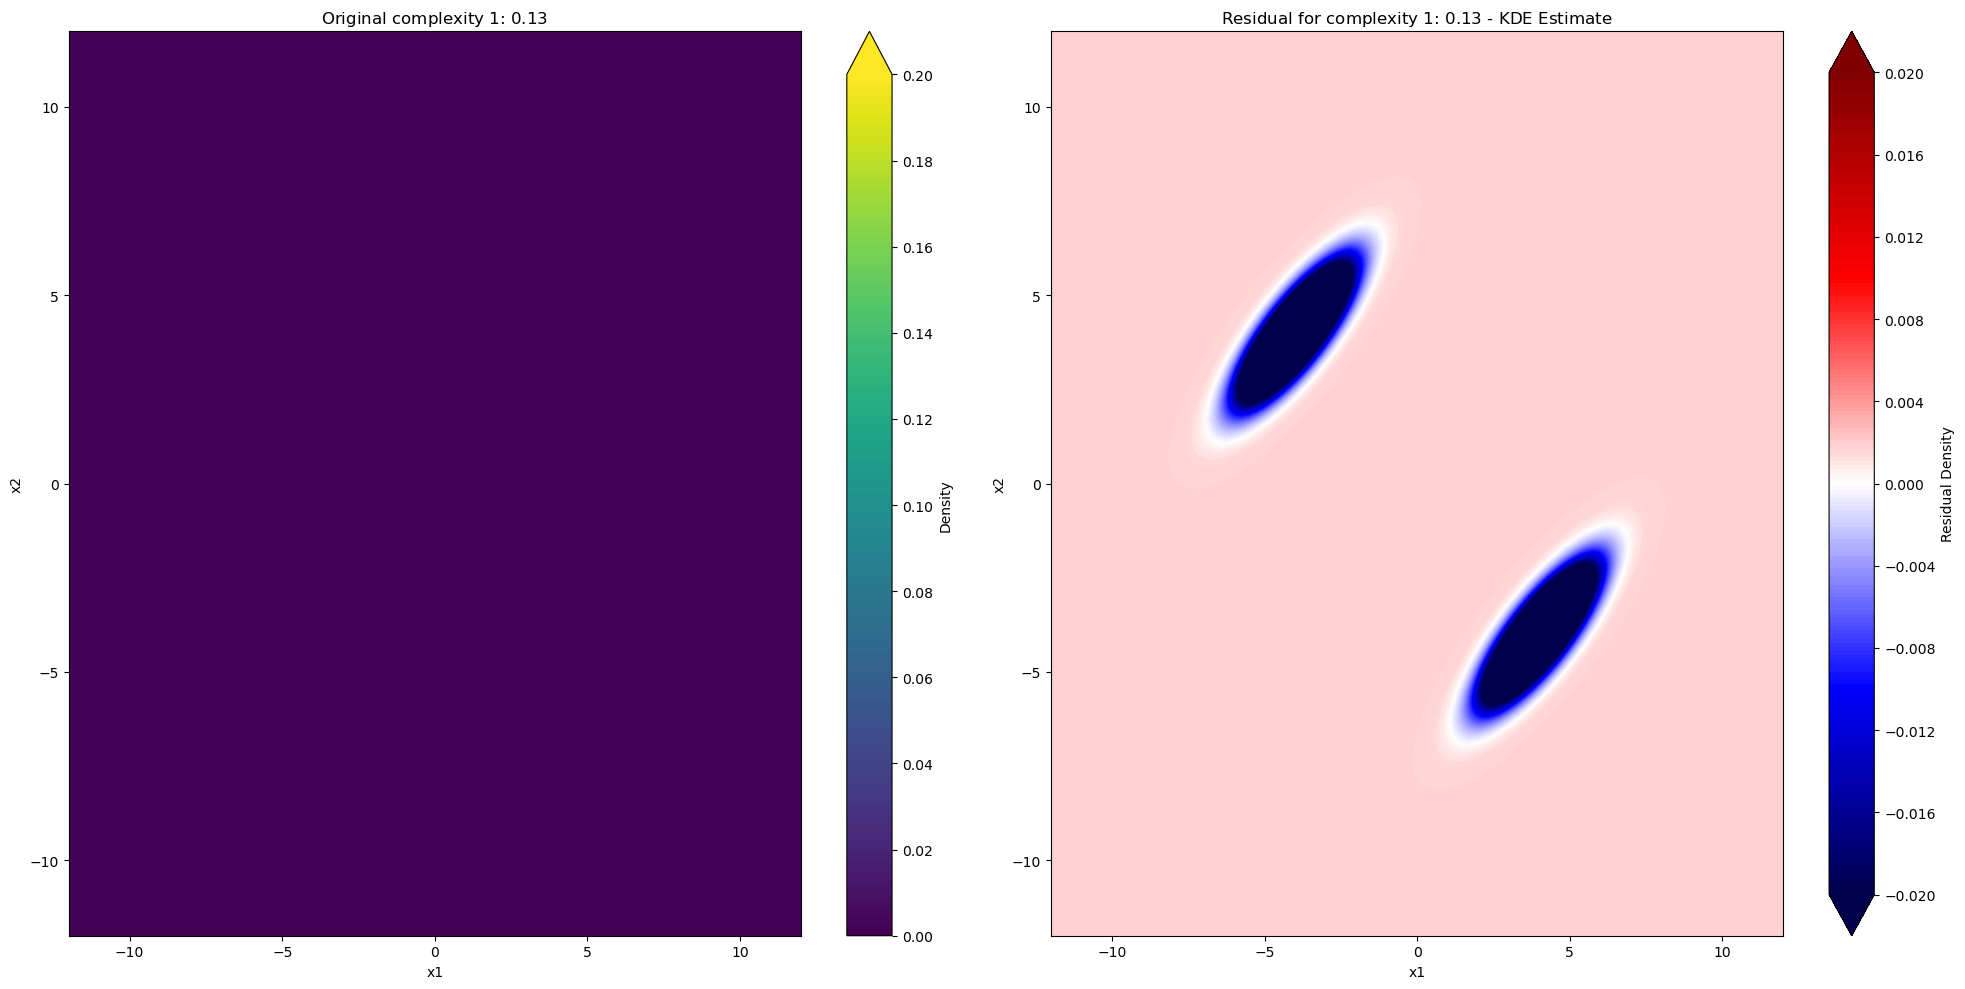

Complexity 1: Likelihood score: -6.358744508406522
complexity 1 :: min predict: 0.00, max predict: 0.00
complexity 1 :: min residual: -0.13, max residual: 0.00
Complexity 1: MSE error: 6.651344e-01


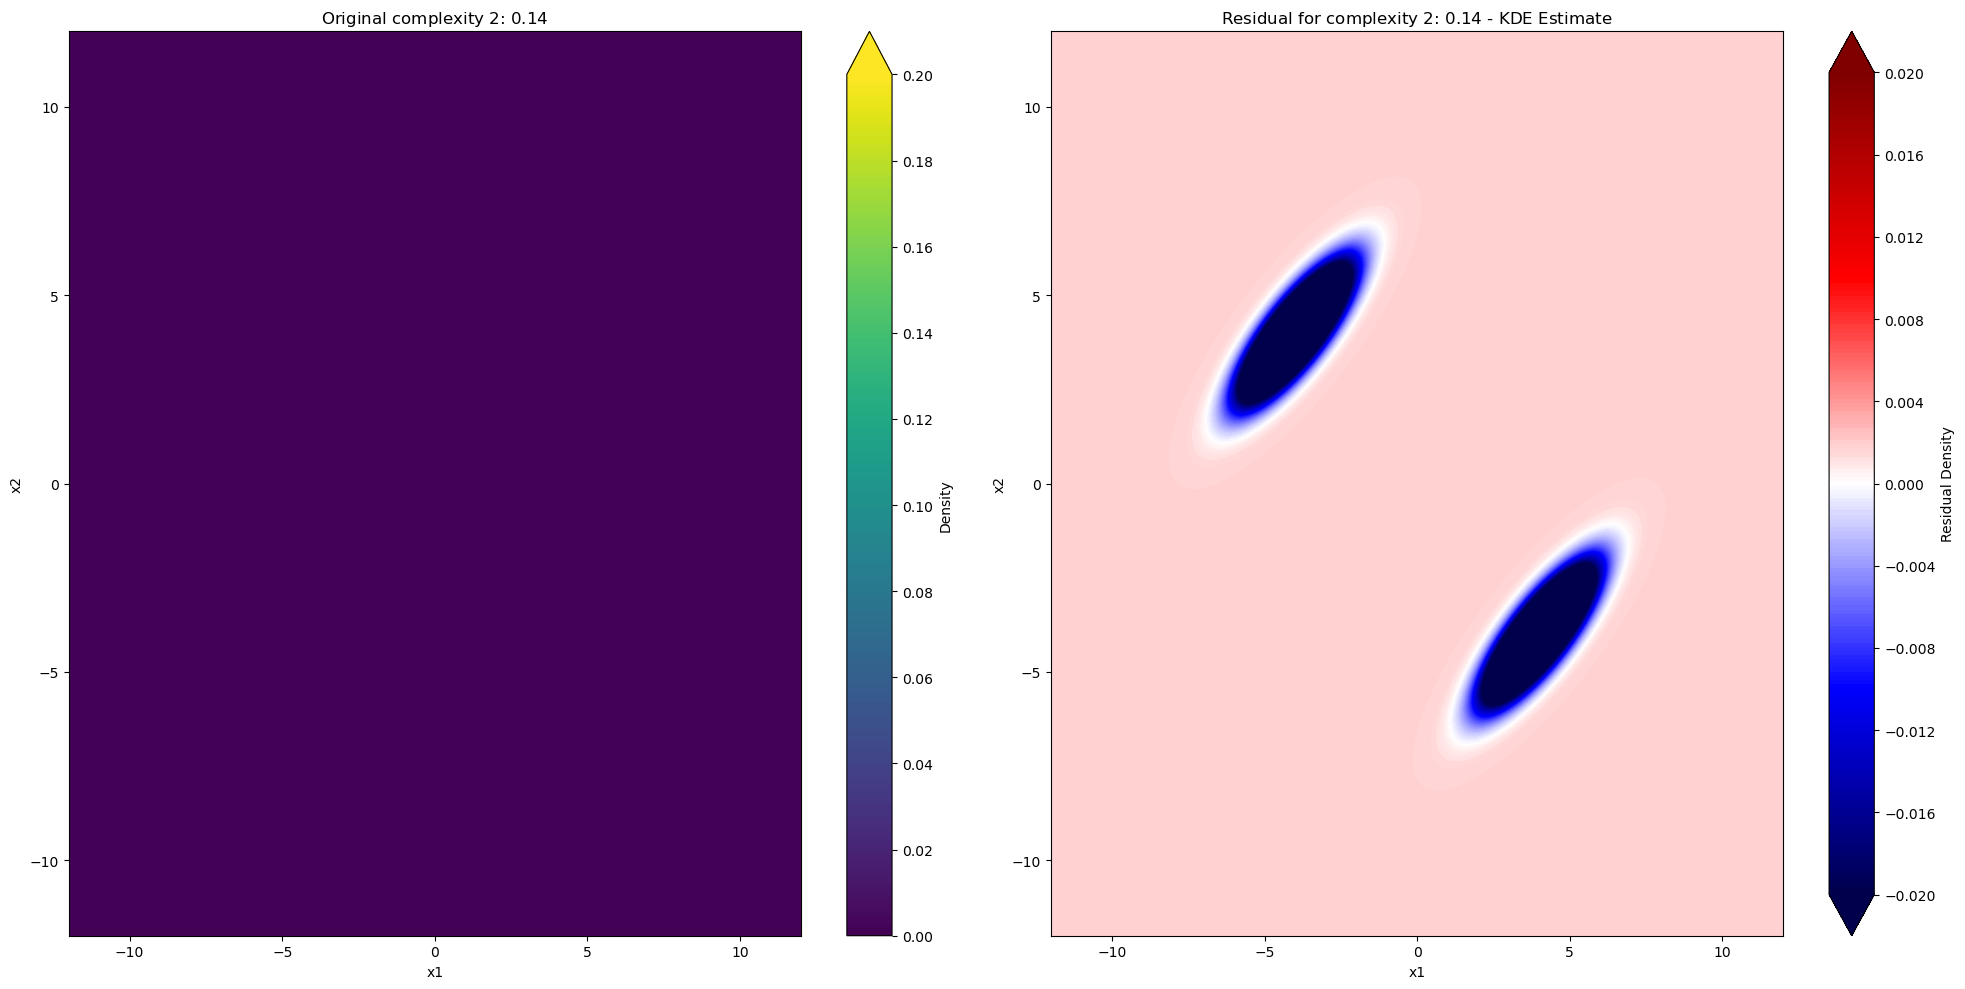

Complexity 2: Likelihood score: -6.358703341673114
complexity 2 :: min predict: 0.00, max predict: 0.00
complexity 2 :: min residual: -0.13, max residual: 0.00
Complexity 2: MSE error: 6.651344e-01


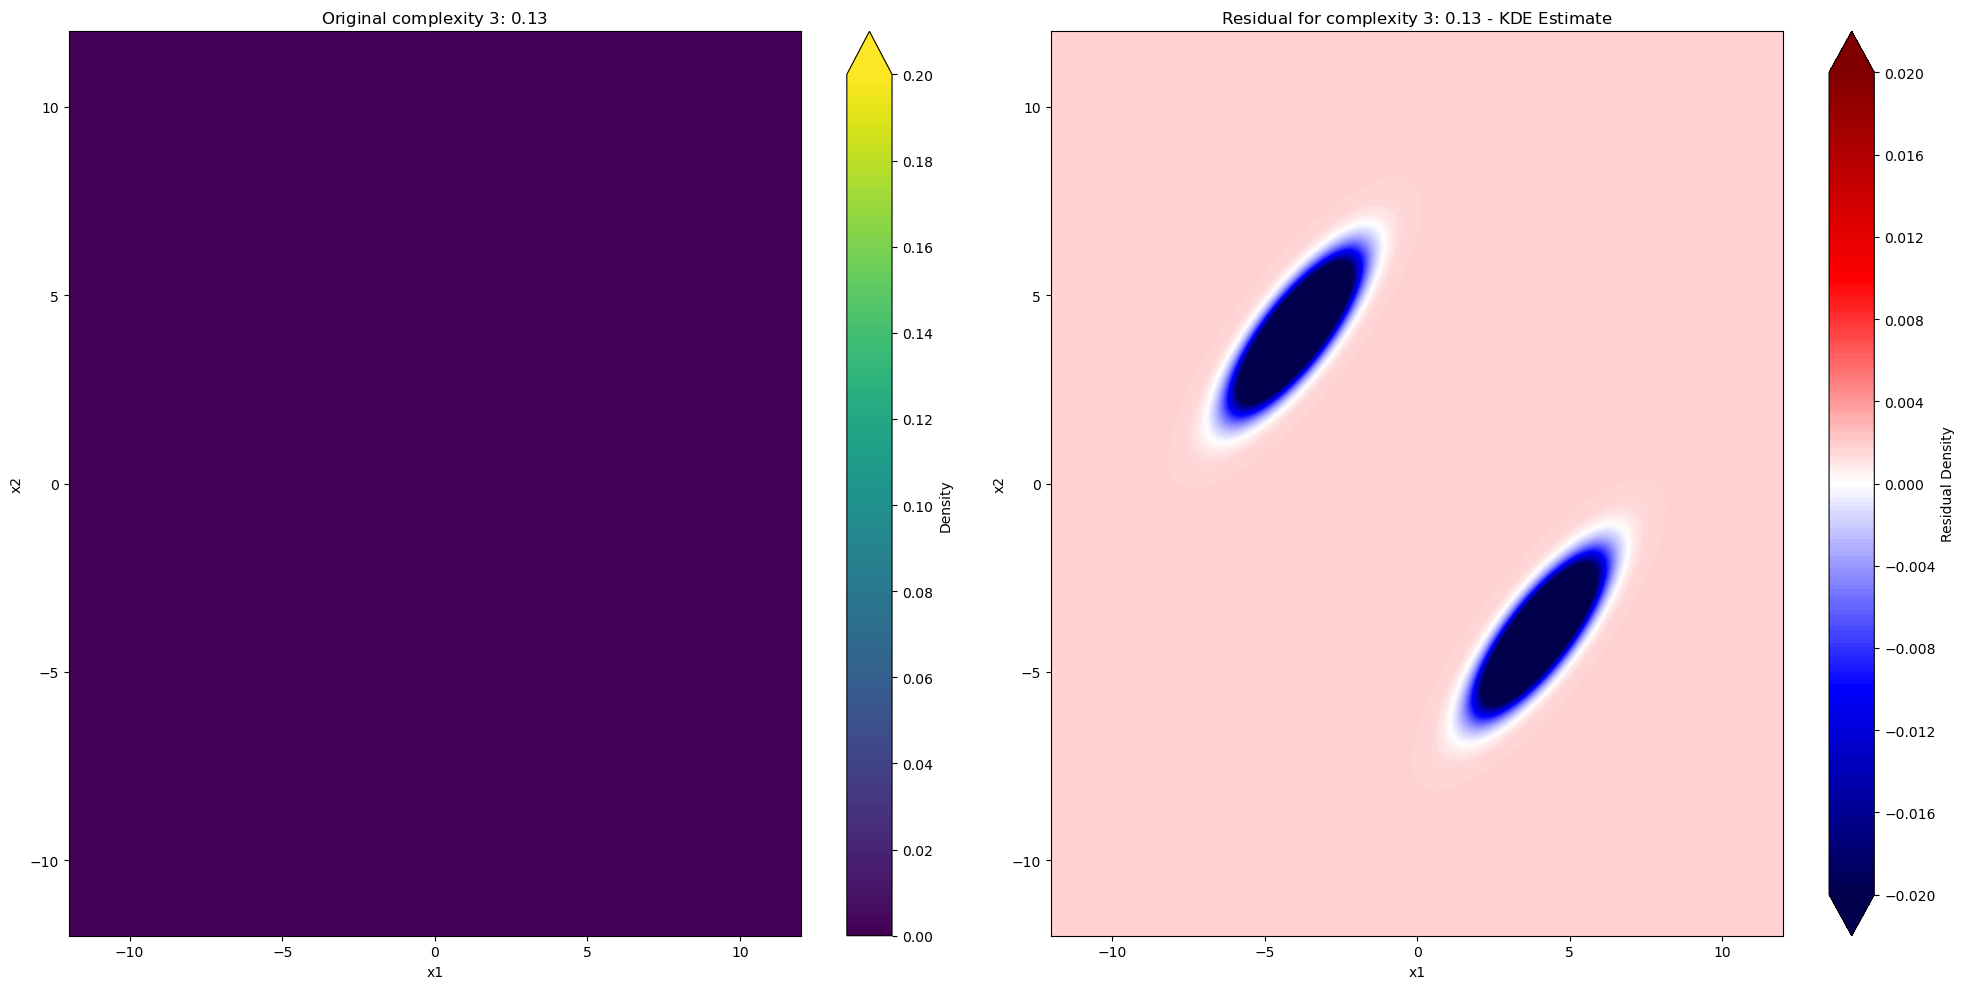

Complexity 3: Likelihood score: -6.358653861485776
complexity 3 :: min predict: 0.00, max predict: 0.00
complexity 3 :: min residual: -0.13, max residual: 0.00
Complexity 3: MSE error: 6.651344e-01


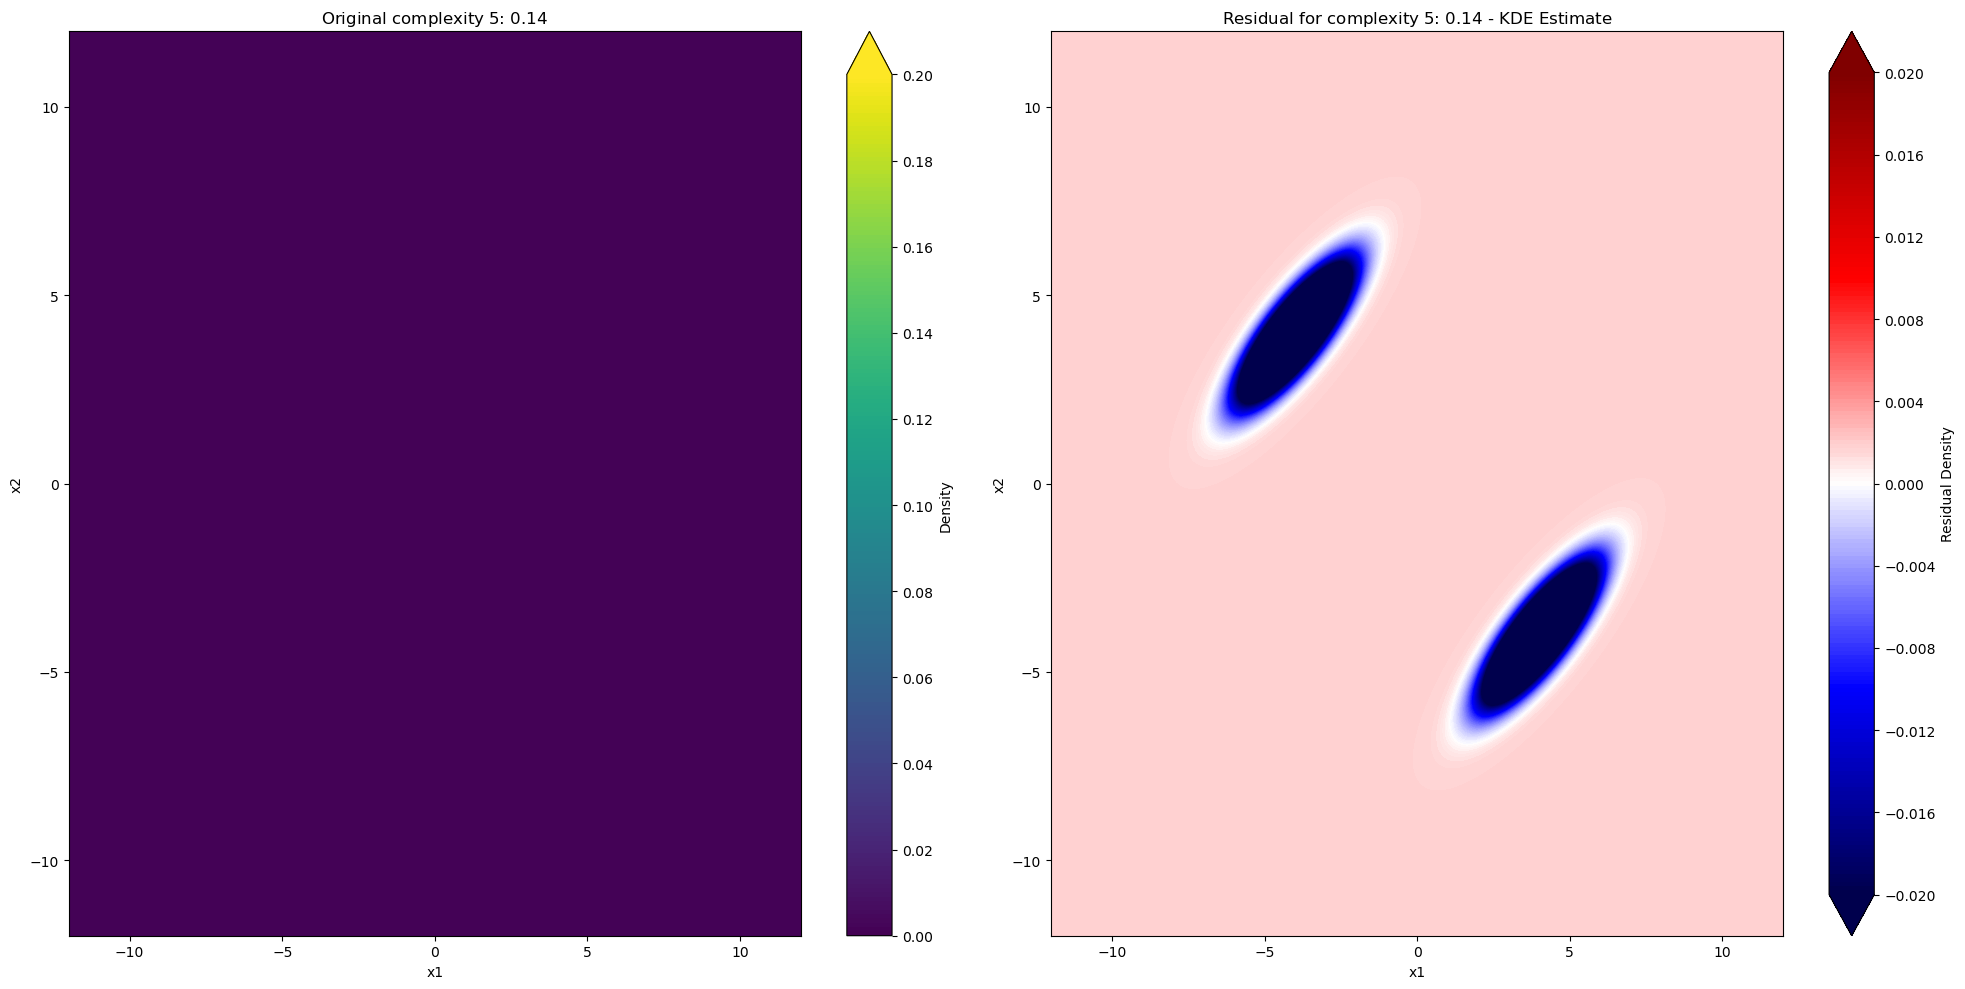

Complexity 5: Likelihood score: -6.358599560374446
complexity 5 :: min predict: 0.00, max predict: 0.00
complexity 5 :: min residual: -0.13, max residual: 0.00
Complexity 5: MSE error: 6.651344e-01


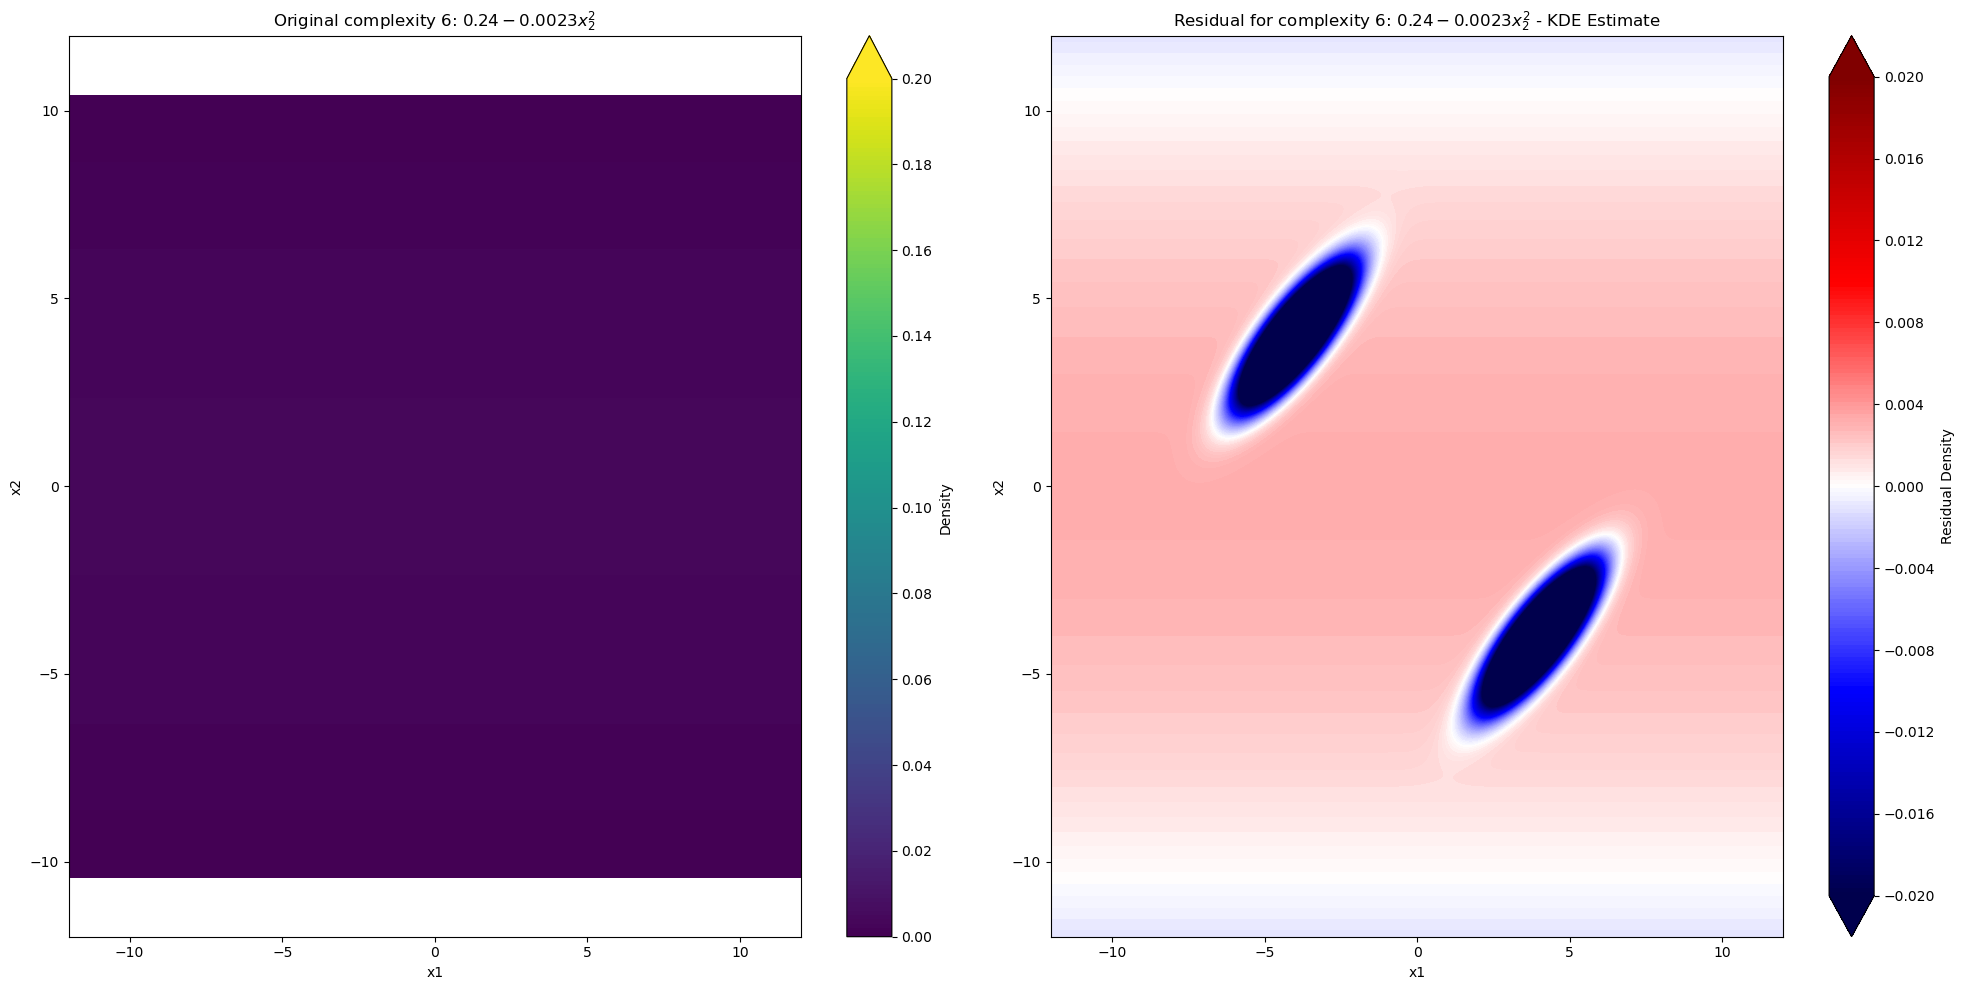

Complexity 6: Likelihood score: -296,326.4448725233
complexity 6 :: min predict: -0.00, max predict: 0.00
complexity 6 :: min residual: -0.13, max residual: 0.00
Complexity 6: MSE error: 6.558178e-01


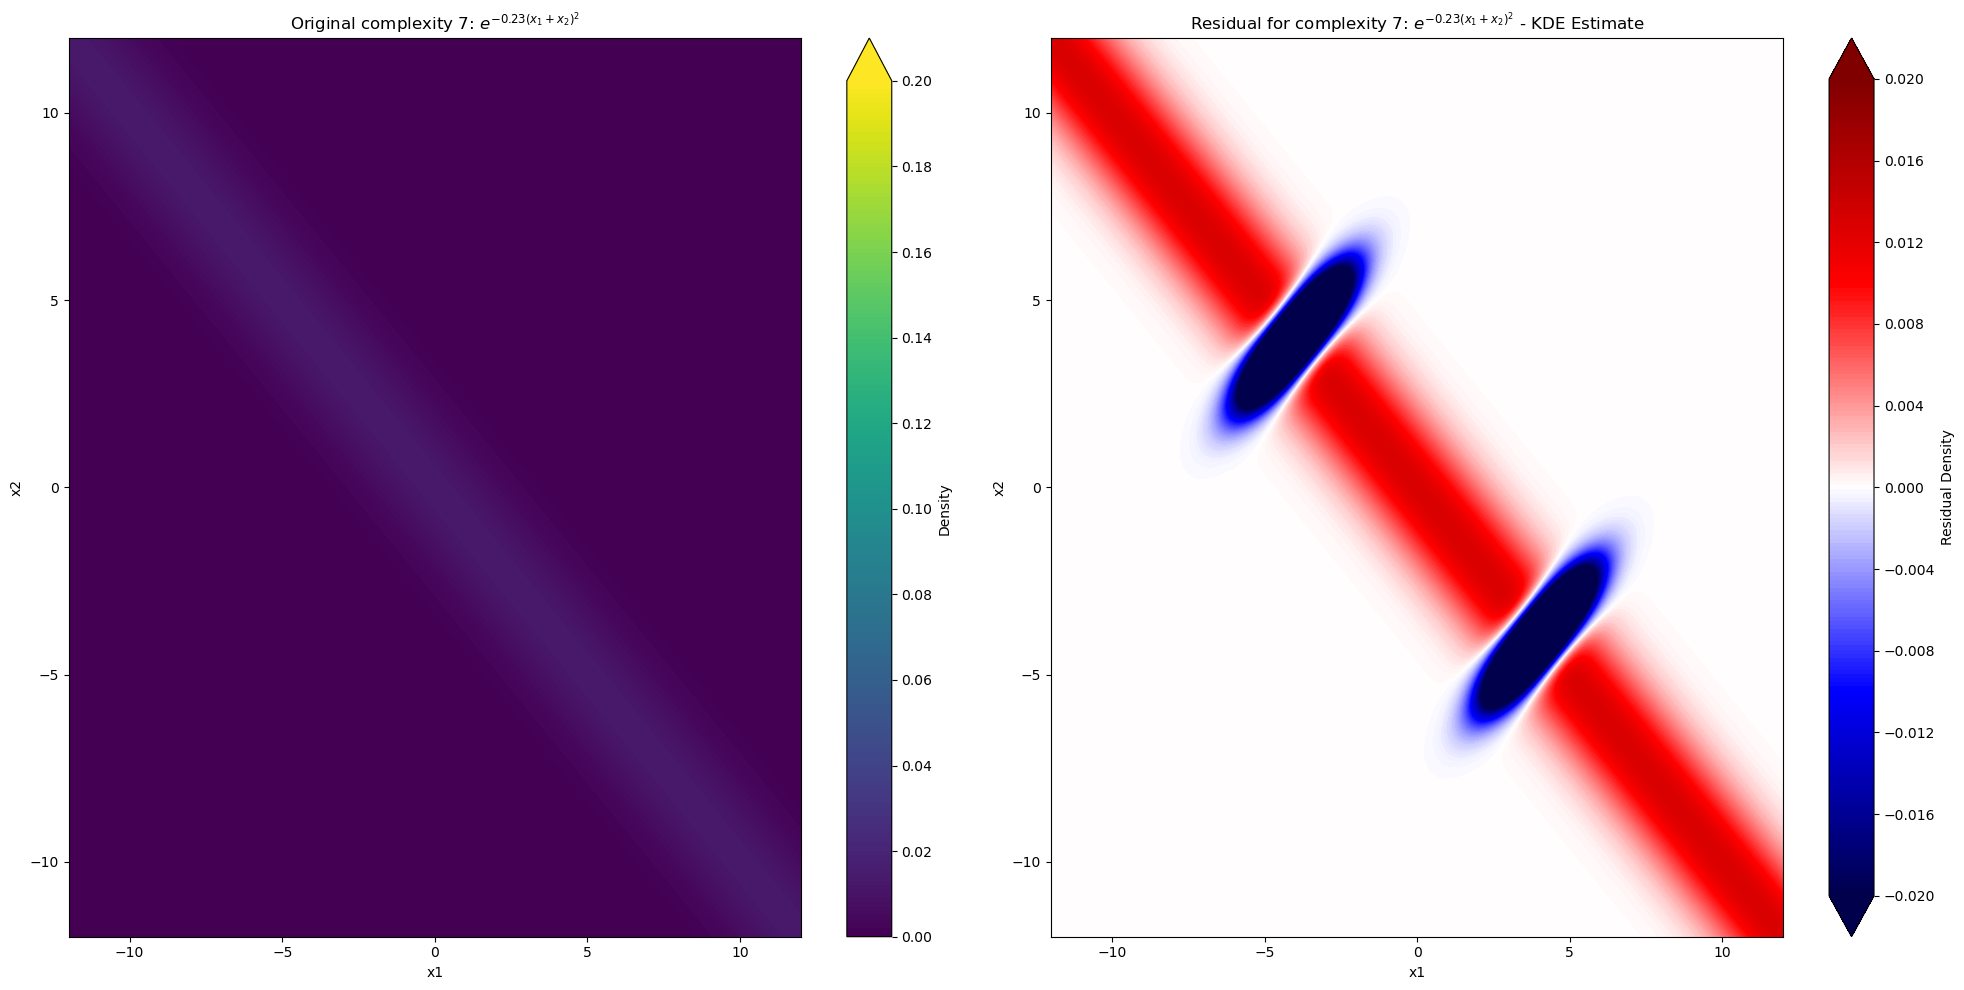

Complexity 7: Likelihood score: -257,890.22014503402
complexity 7 :: min predict: 0.00, max predict: 0.01
complexity 7 :: min residual: -0.12, max residual: 0.01
Complexity 7: MSE error: 6.240621e-01


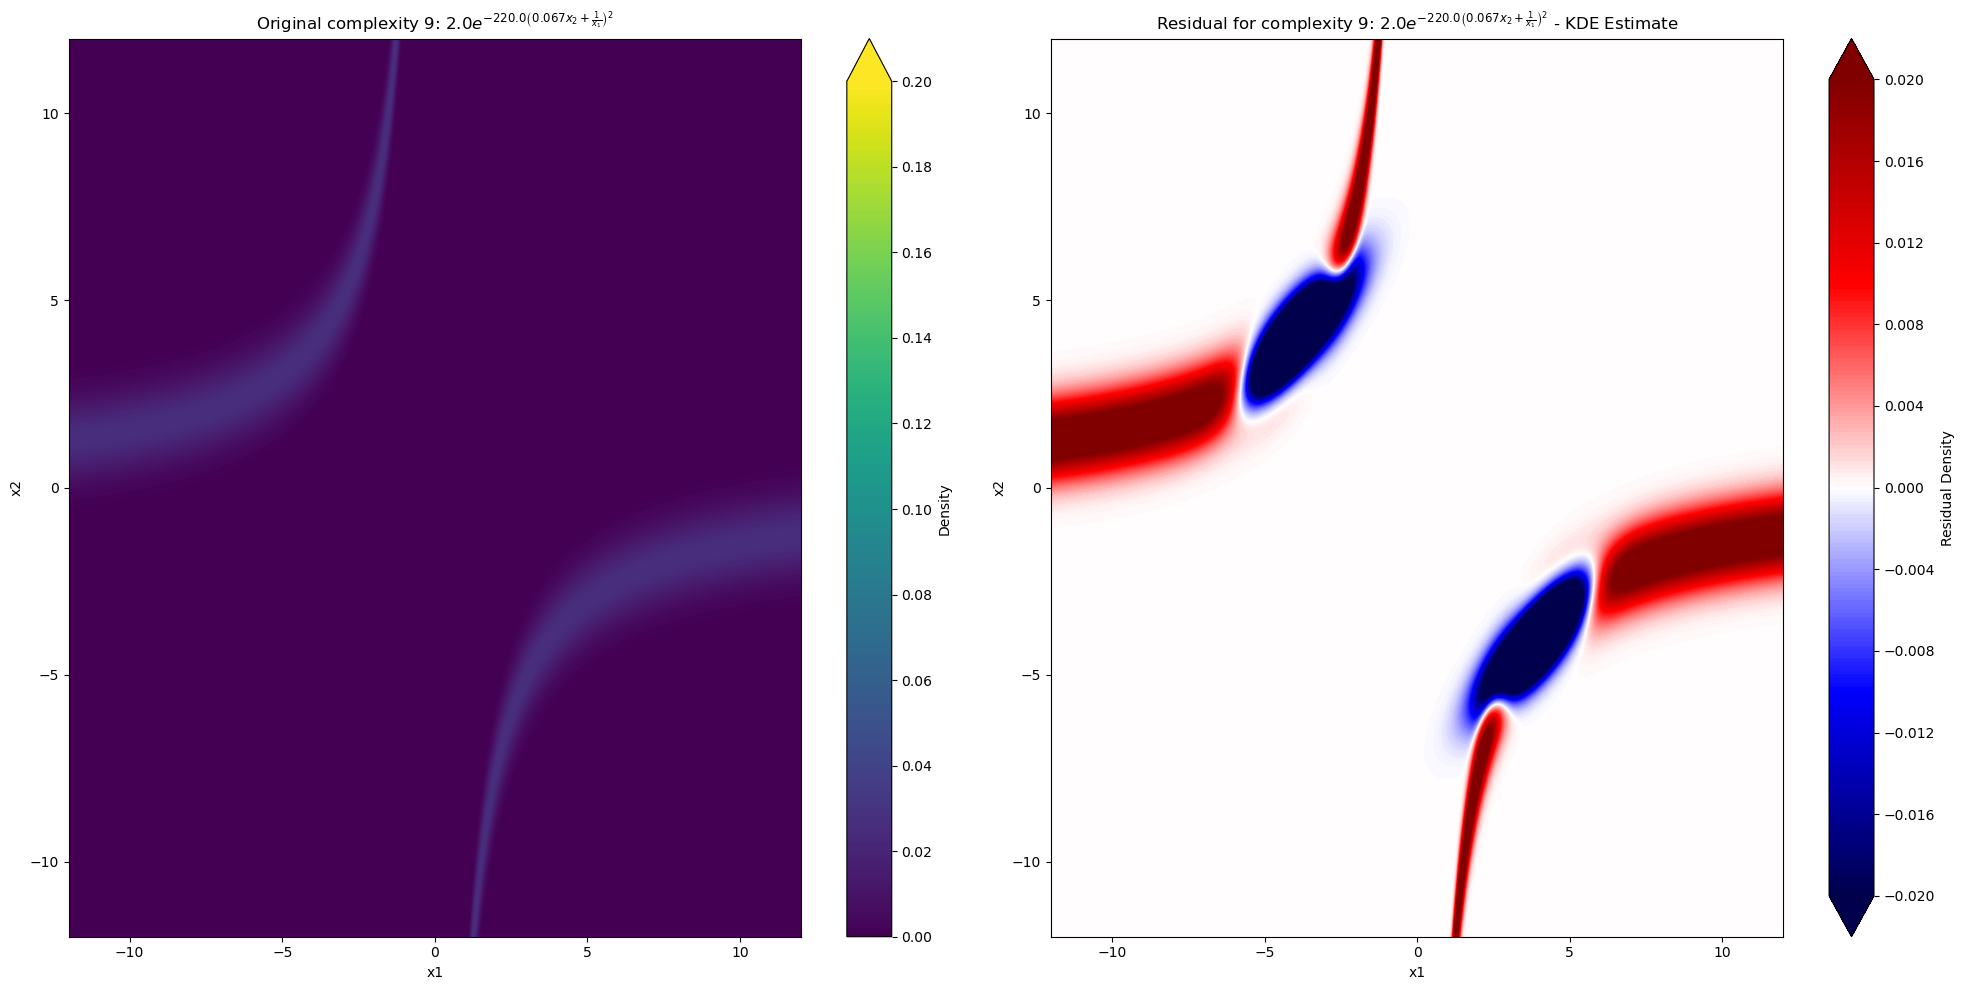

/tmp/ipykernel_1987293/4099902729.py:74: RuntimeWarning: divide by zero encountered in log
  likelihood_score_of_prediction = np.sum(np.log(prediction_eval_at_samples/density_scale_factor))


Complexity 9: Likelihood score: -inf
complexity 9 :: min predict: 0.00, max predict: 0.03
complexity 9 :: min residual: -0.11, max residual: 0.03
Complexity 9: MSE error: 4.937818e-01


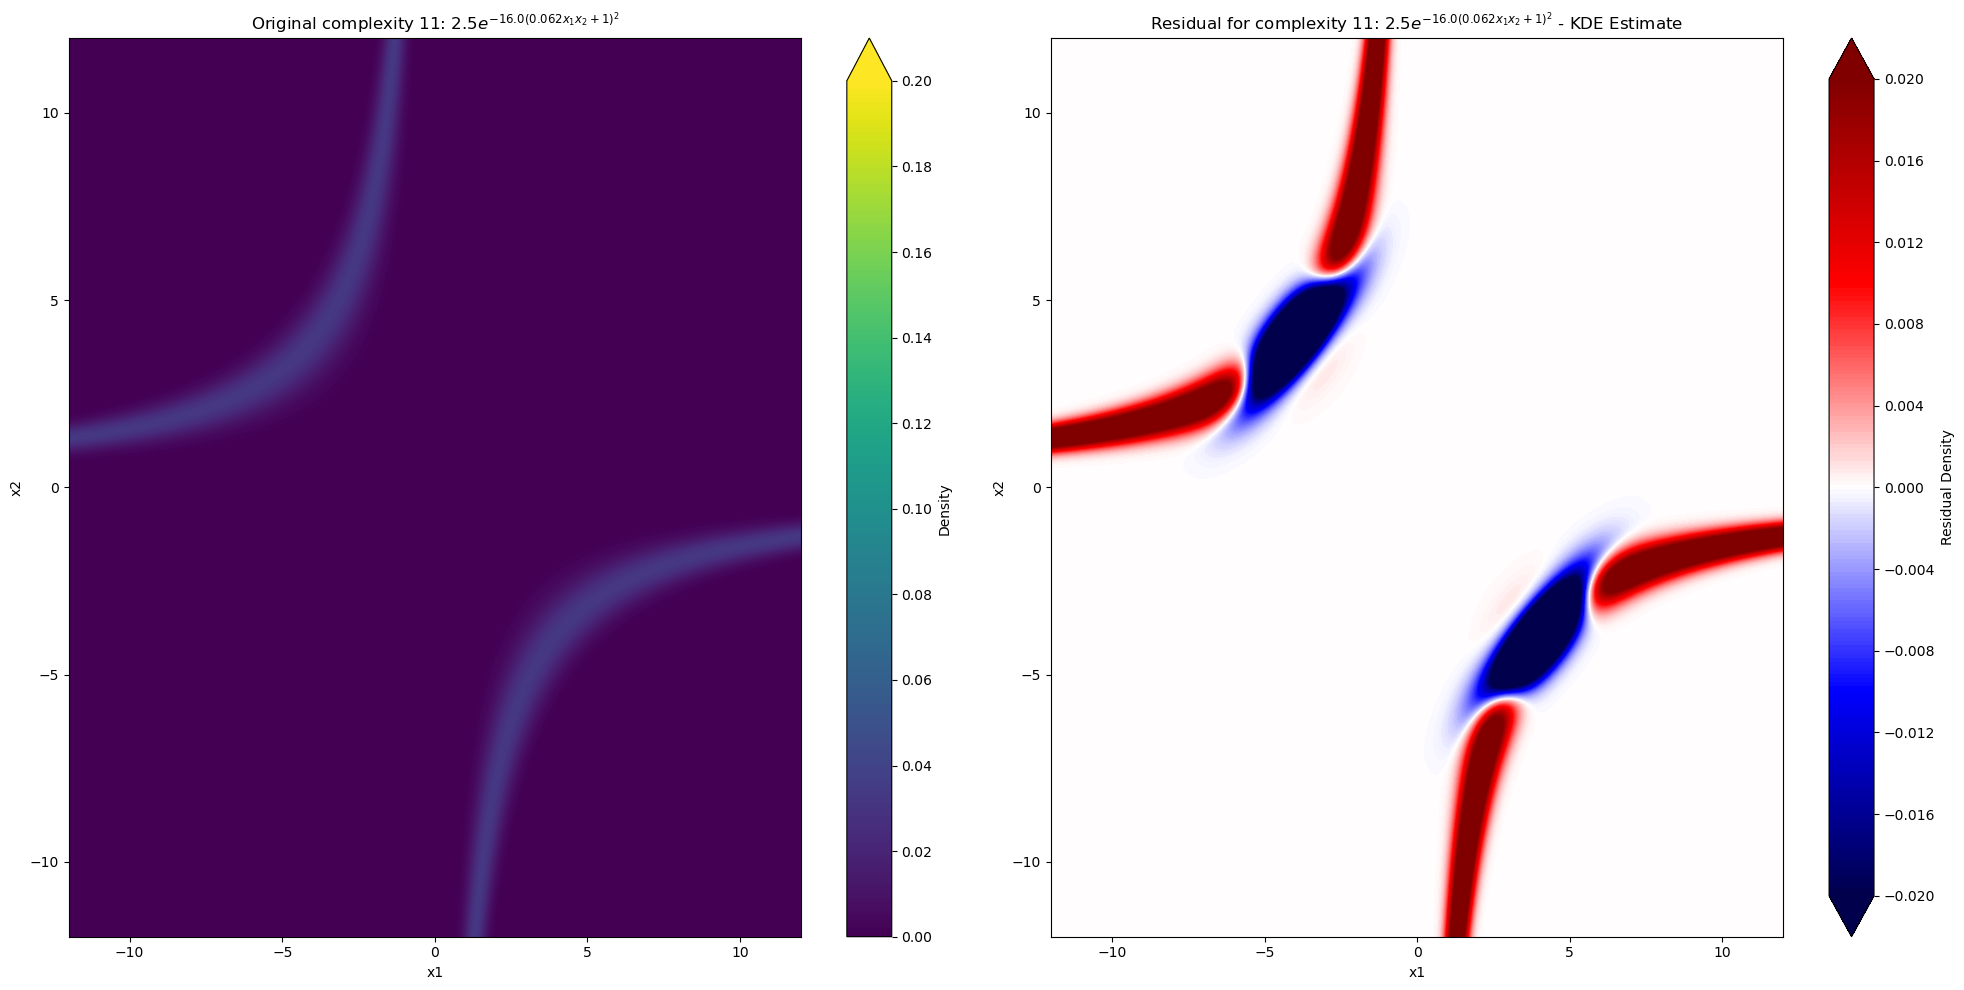

Complexity 11: Likelihood score: -198,750.8626129024
complexity 11 :: min predict: 0.00, max predict: 0.03
complexity 11 :: min residual: -0.10, max residual: 0.03
Complexity 11: MSE error: 4.513802e-01


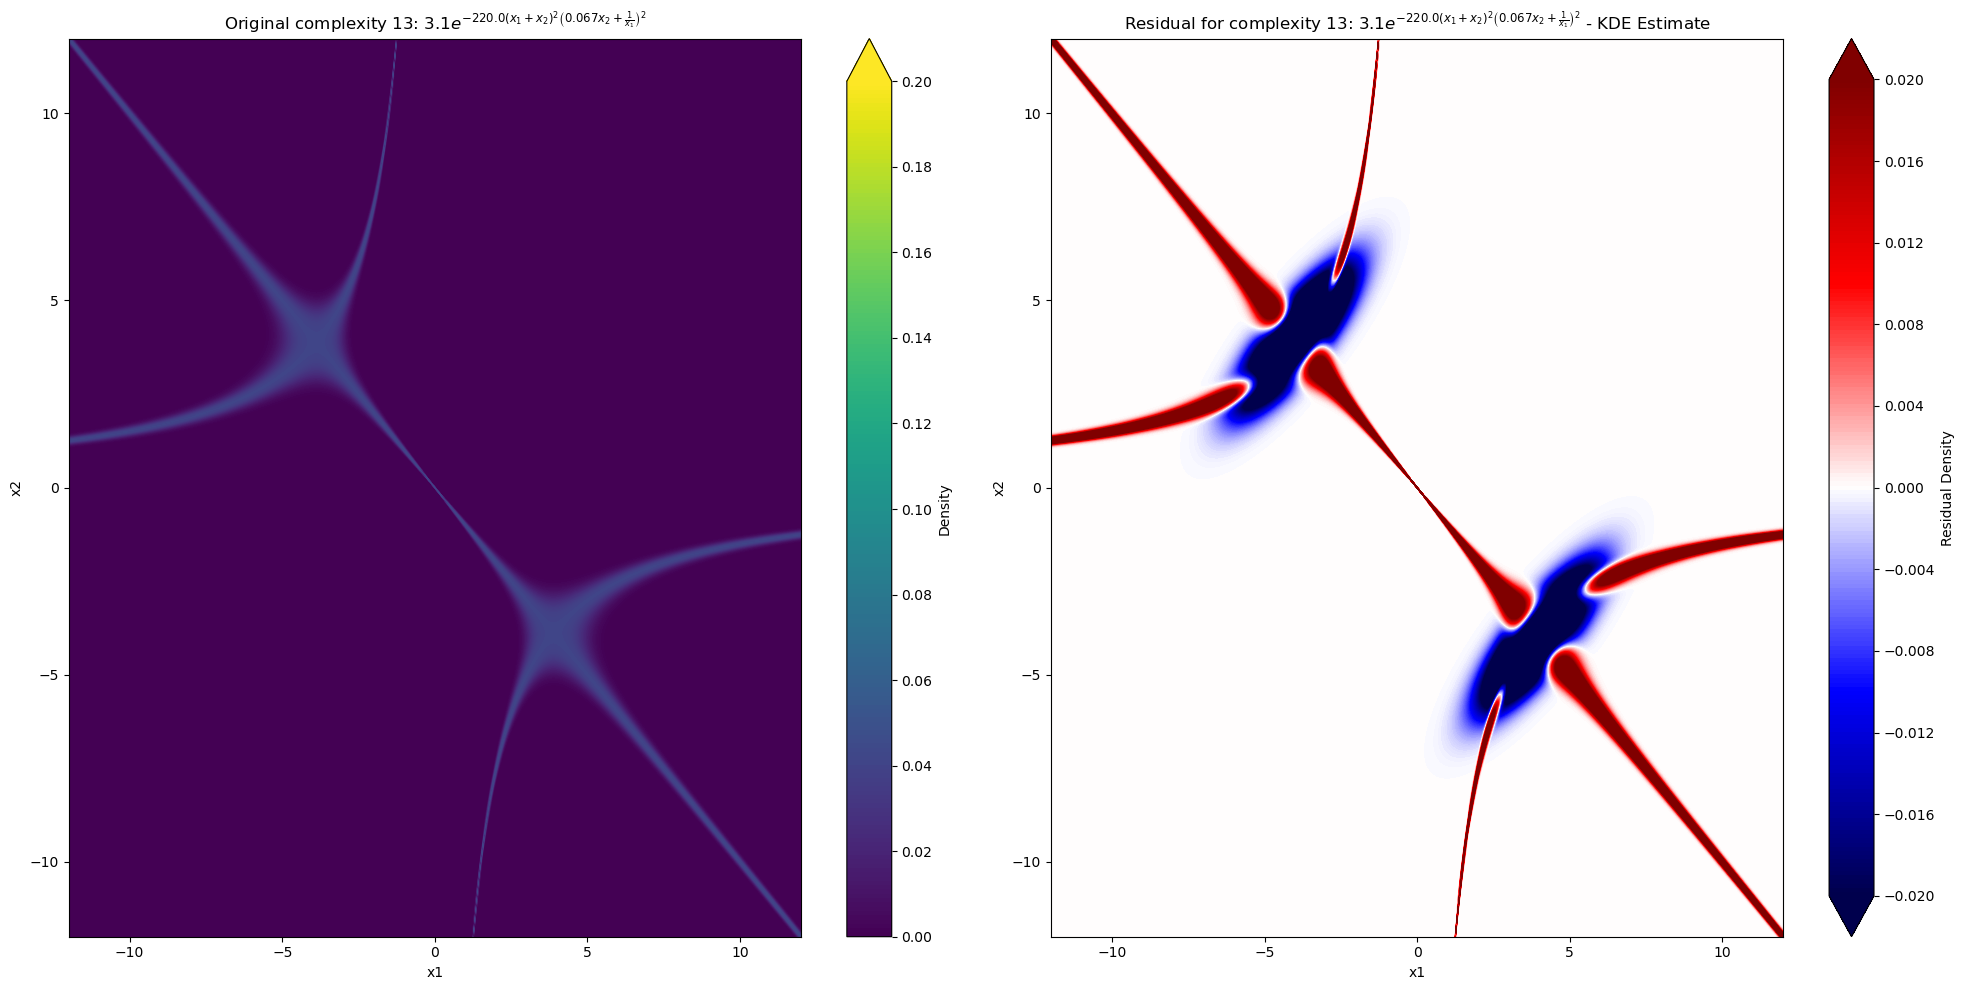

Complexity 13: Likelihood score: -inf
complexity 13 :: min predict: 0.00, max predict: 0.04
complexity 13 :: min residual: -0.09, max residual: 0.04
Complexity 13: MSE error: 4.109804e-01


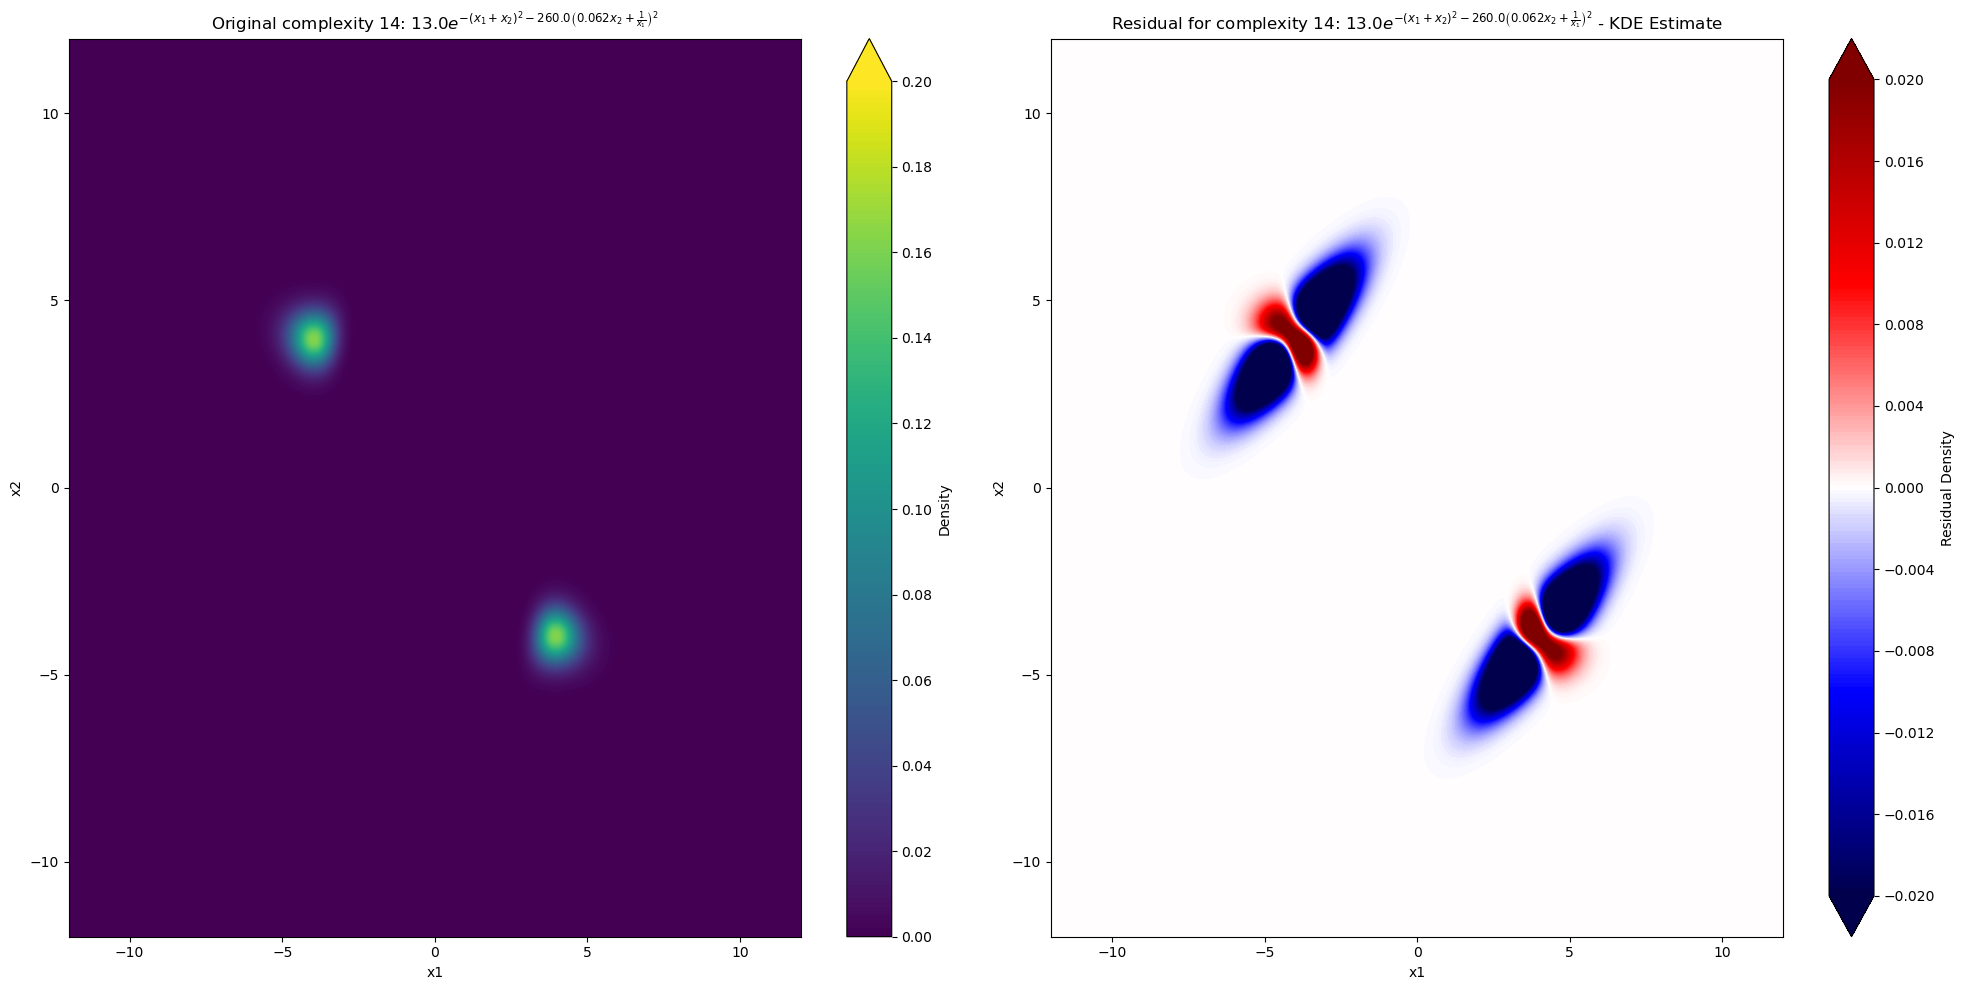

Complexity 14: Likelihood score: -inf
complexity 14 :: min predict: 0.00, max predict: 0.16
complexity 14 :: min residual: -0.08, max residual: 0.04
Complexity 14: MSE error: 2.423632e-01


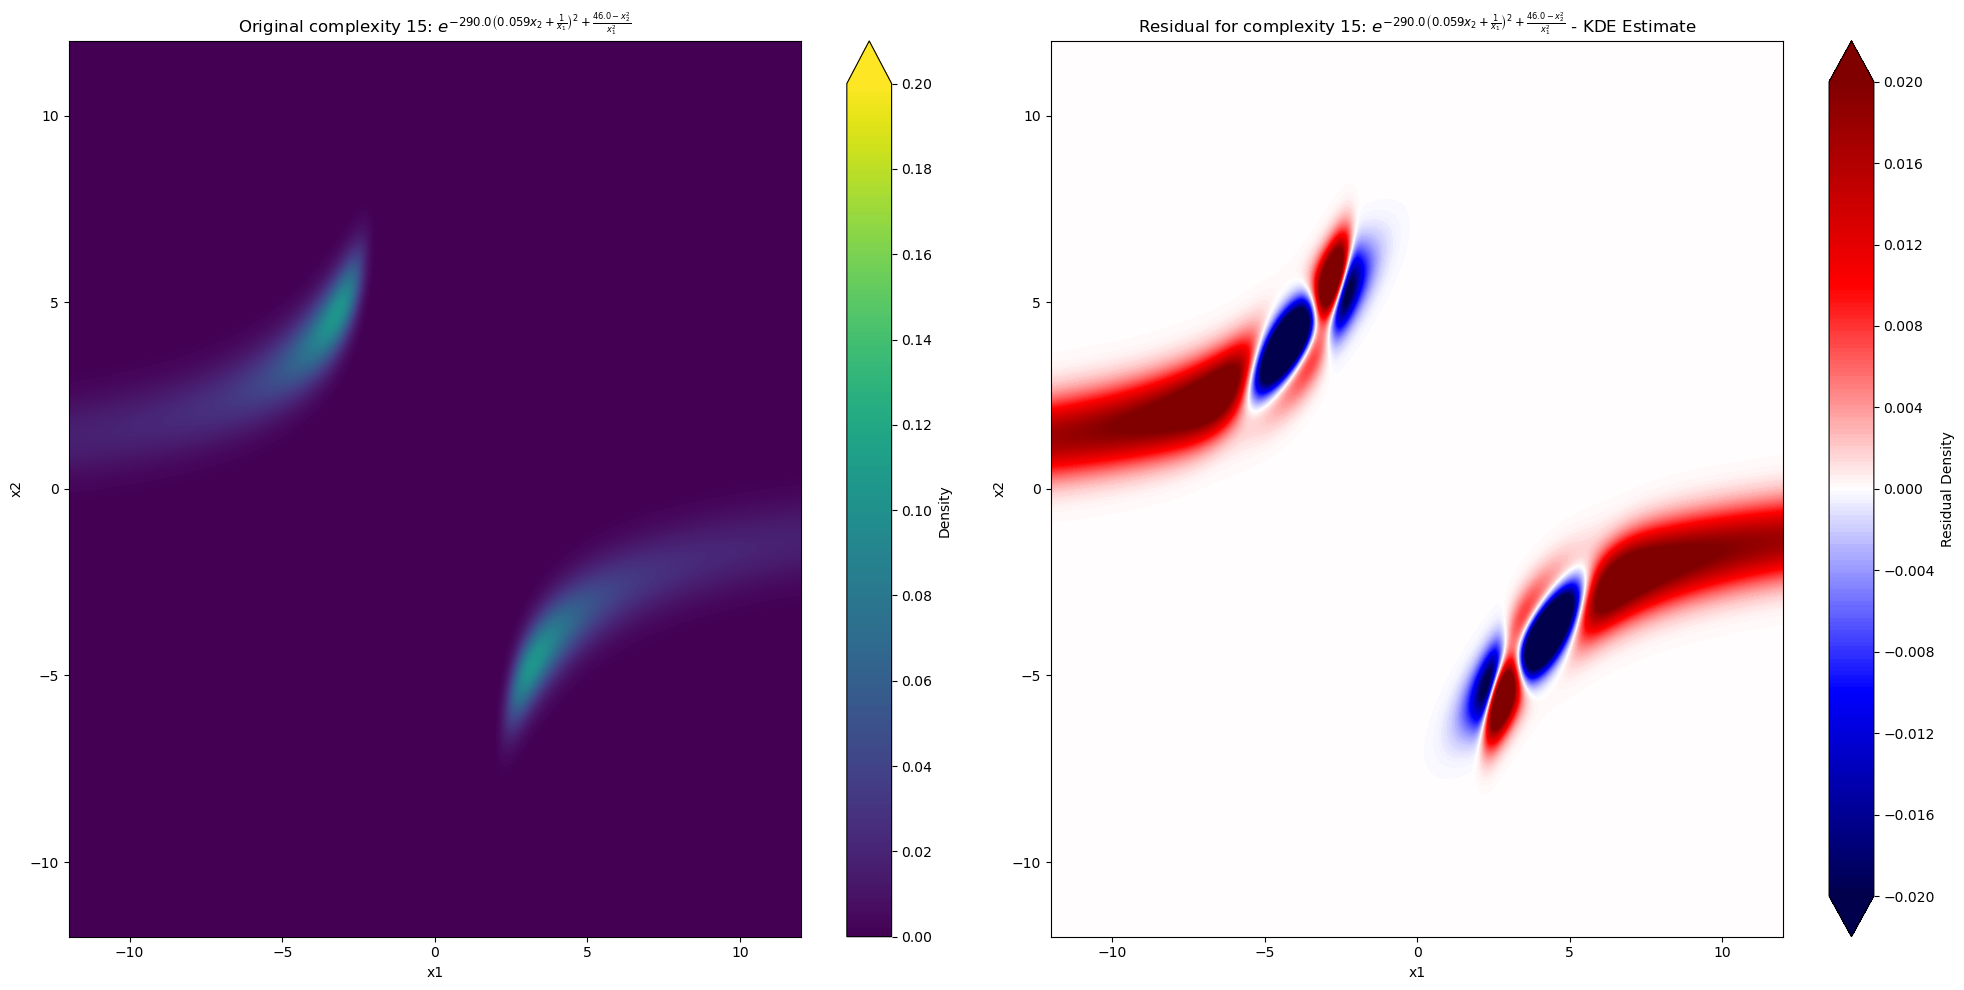

Complexity 15: Likelihood score: -inf
complexity 15 :: min predict: 0.00, max predict: 0.10
complexity 15 :: min residual: -0.06, max residual: 0.04
Complexity 15: MSE error: 1.647721e-01


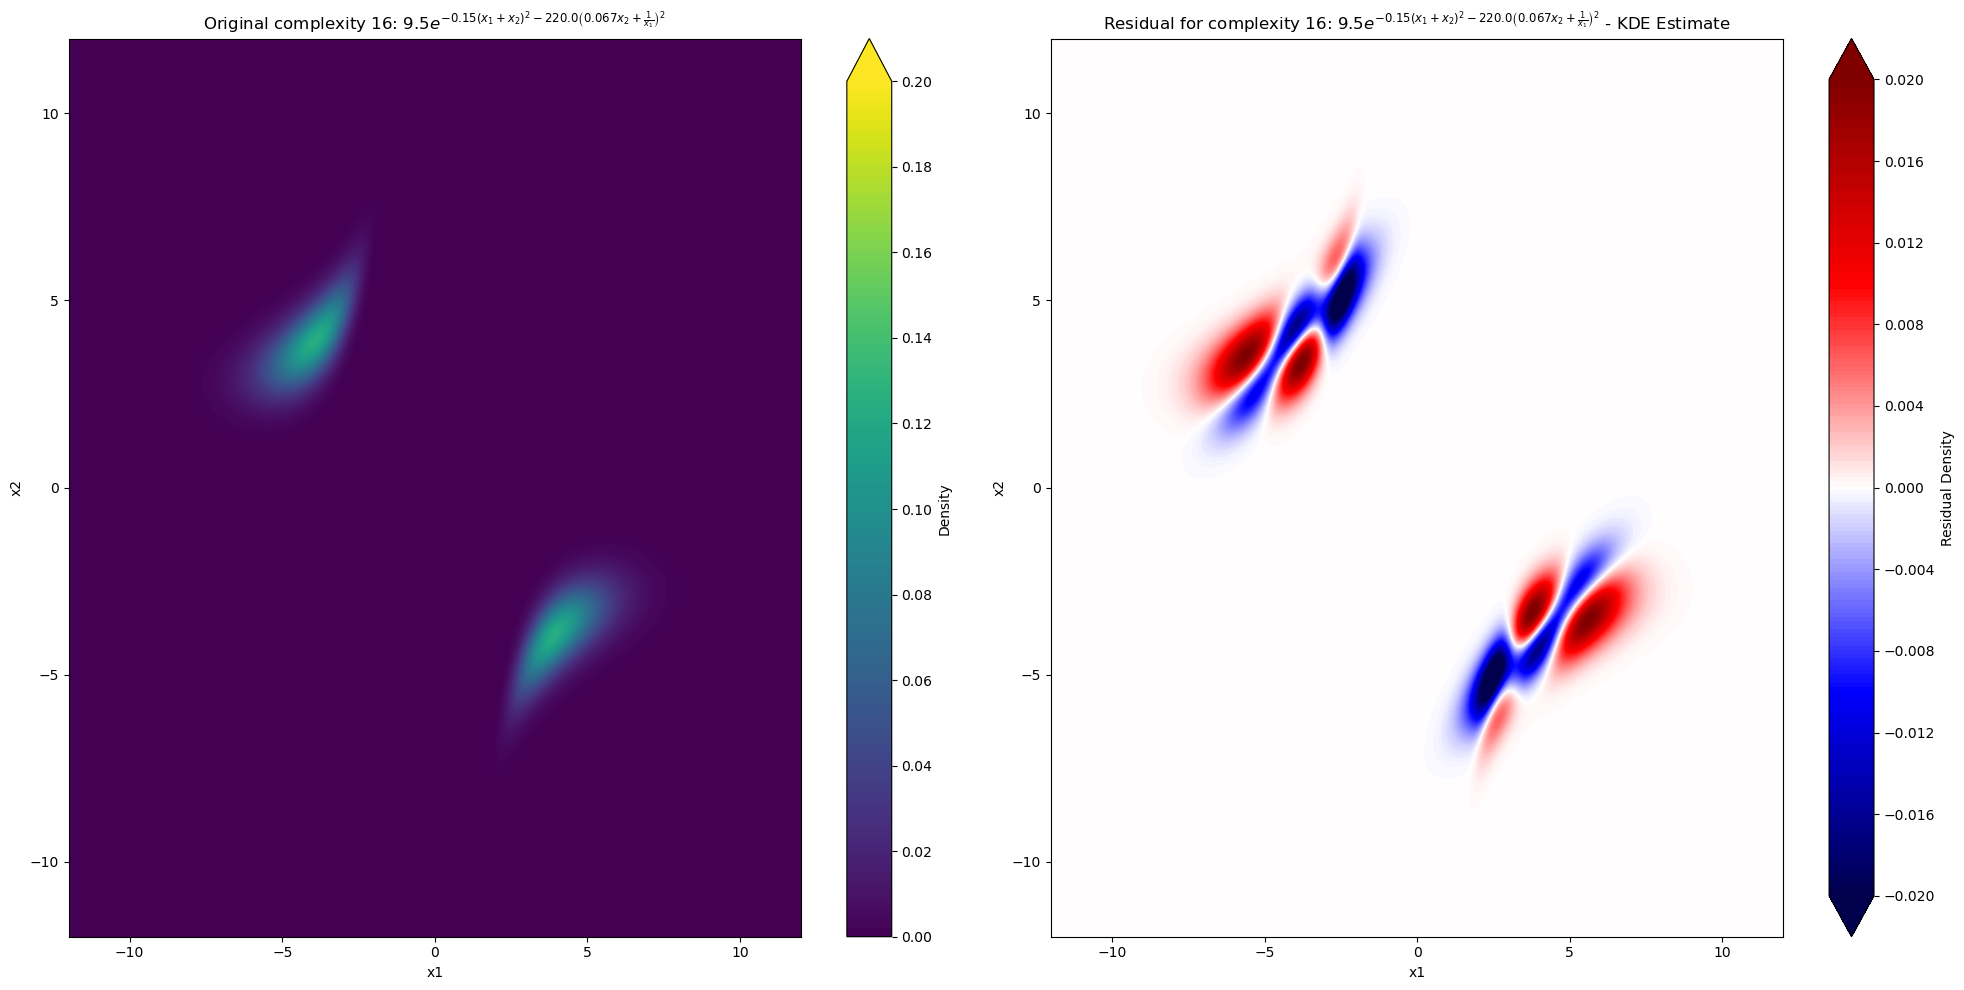

Complexity 16: Likelihood score: -inf
complexity 16 :: min predict: 0.00, max predict: 0.12
complexity 16 :: min residual: -0.03, max residual: 0.02
Complexity 16: MSE error: 3.332248e-02


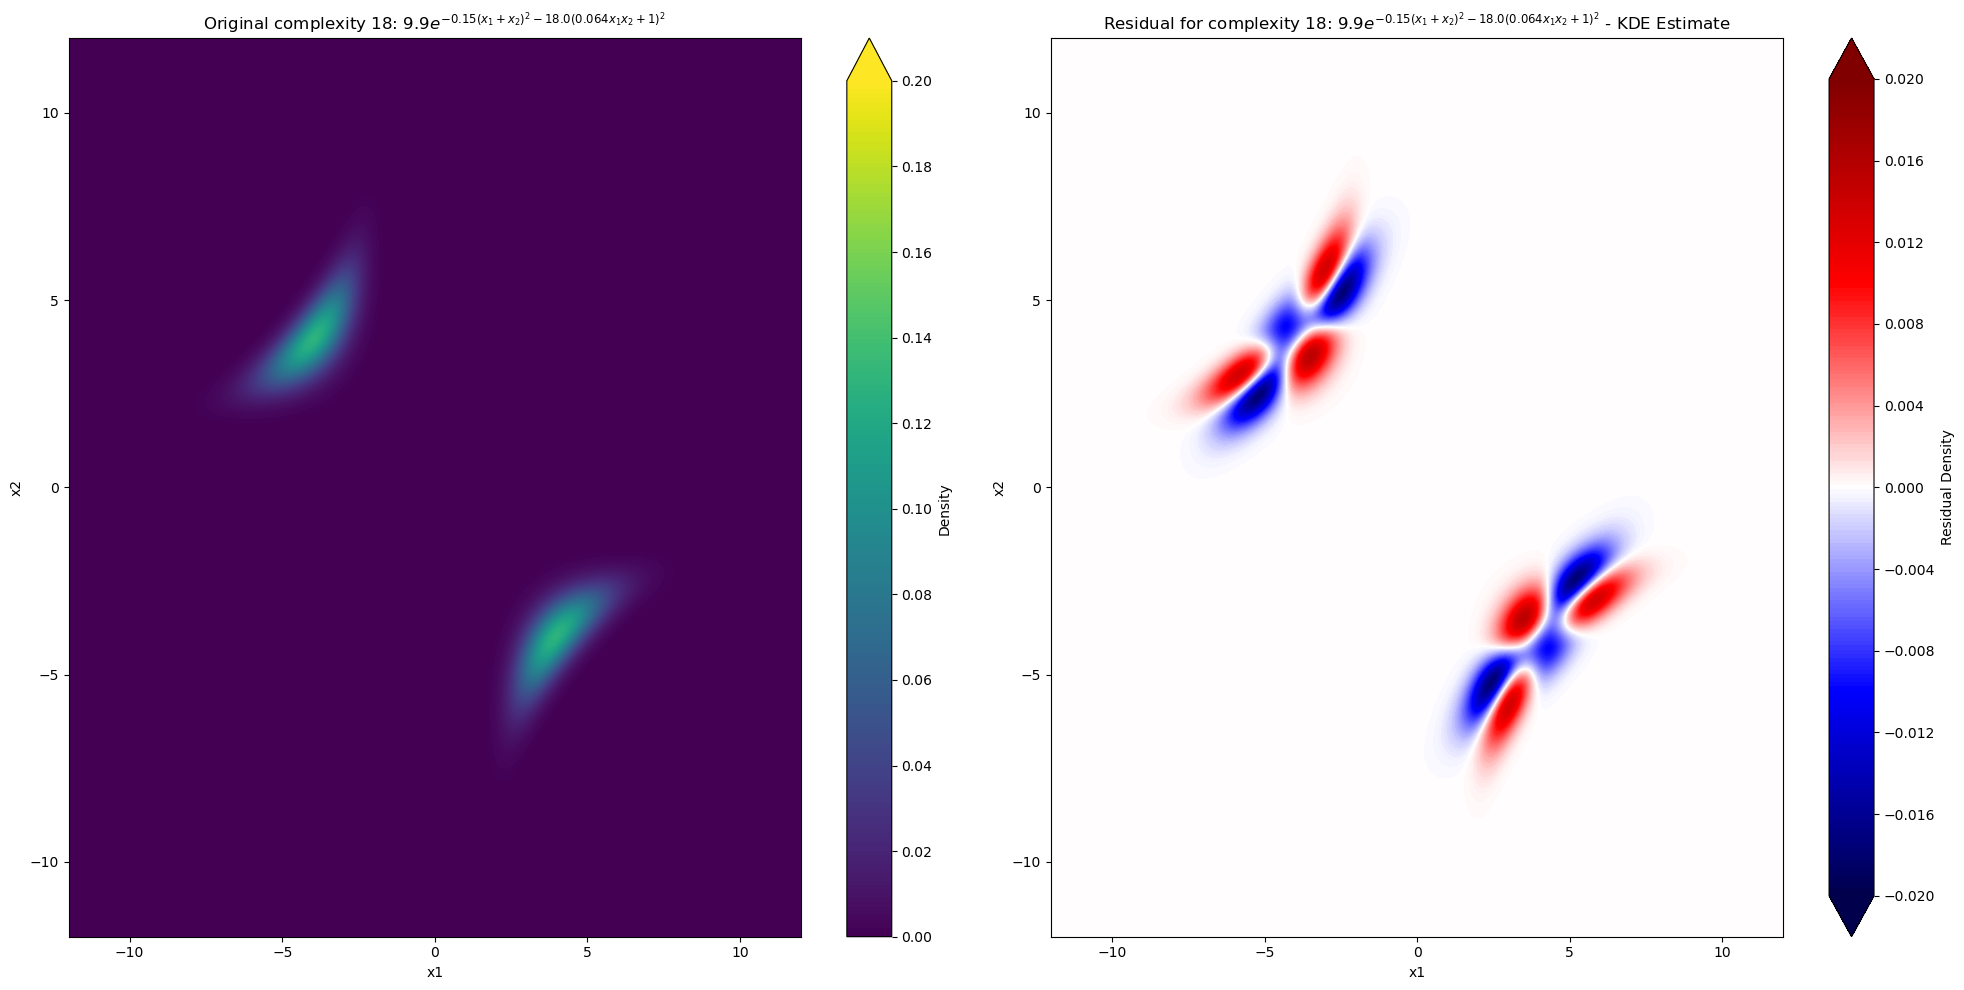

Complexity 18: Likelihood score: -159,123.12182711056
complexity 18 :: min predict: 0.00, max predict: 0.13
complexity 18 :: min residual: -0.02, max residual: 0.02
Complexity 18: MSE error: 1.952280e-02


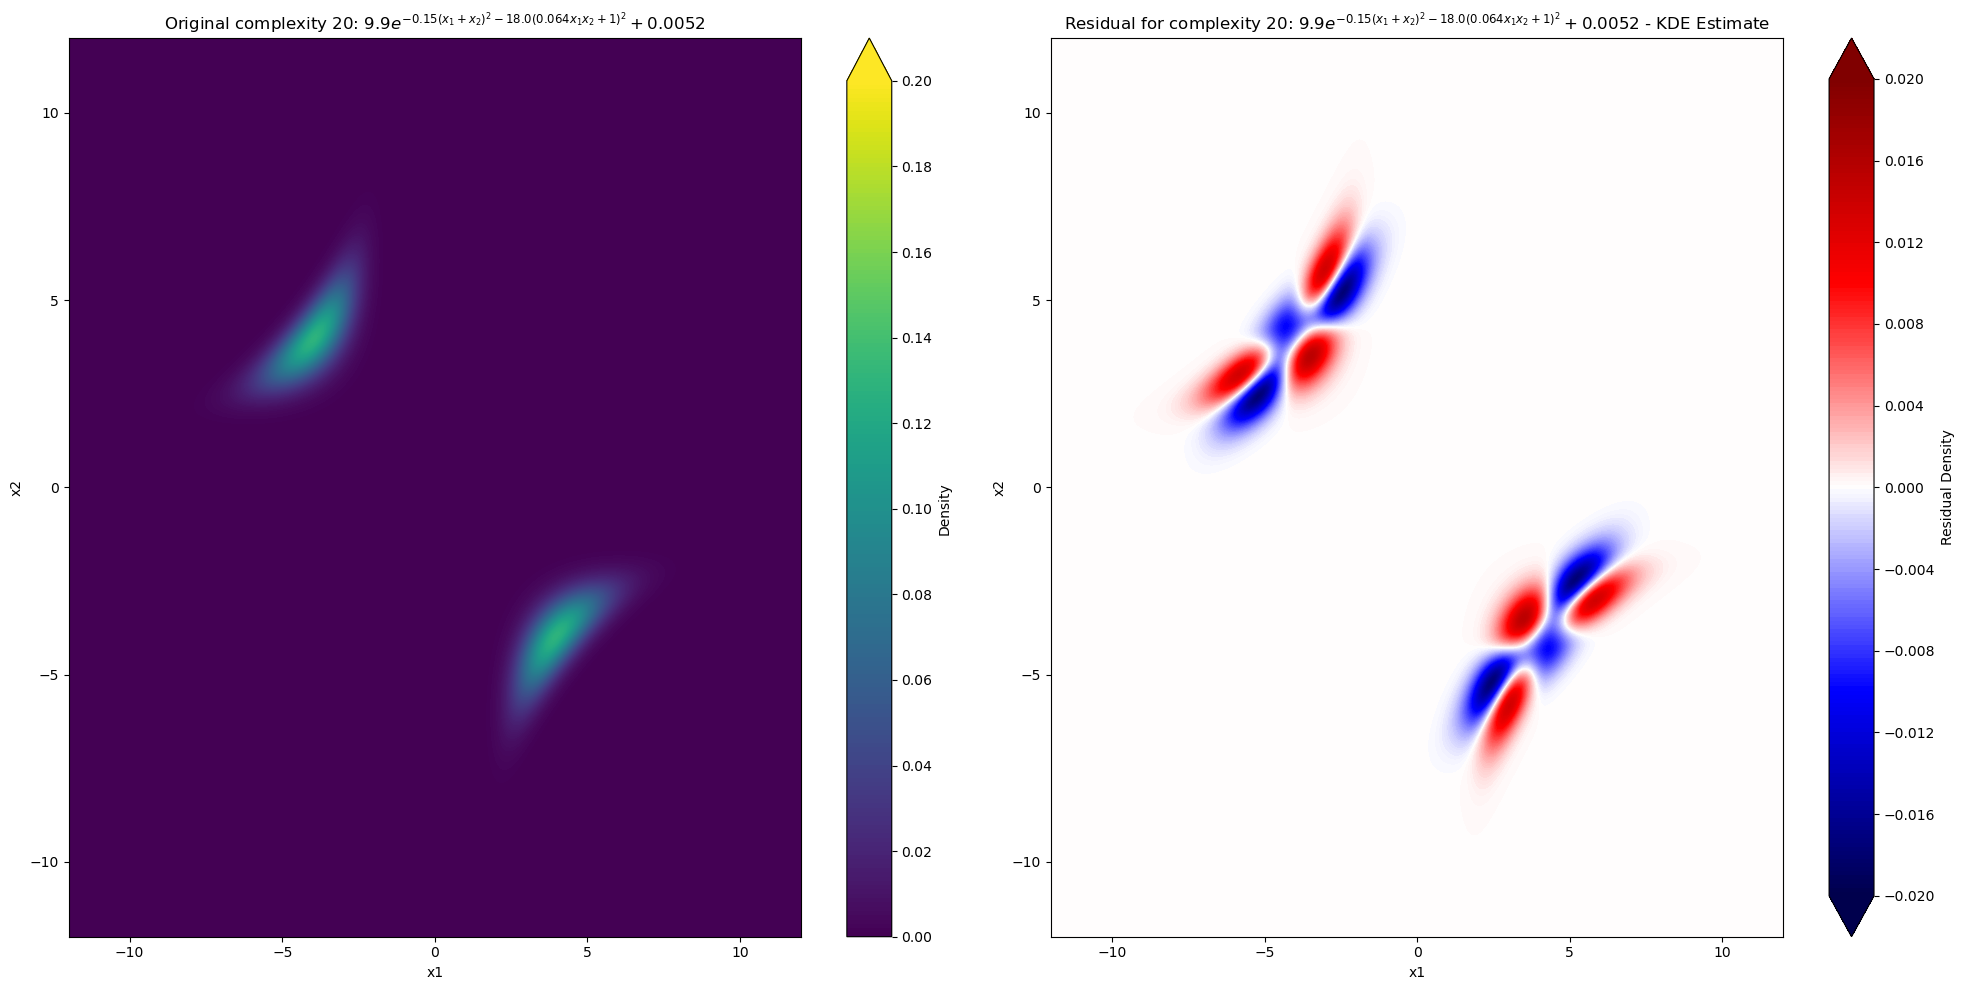

Complexity 20: Likelihood score: -157,594.15321933967
complexity 20 :: min predict: 0.00, max predict: 0.13
complexity 20 :: min residual: -0.02, max residual: 0.02
Complexity 20: MSE error: 1.951173e-02


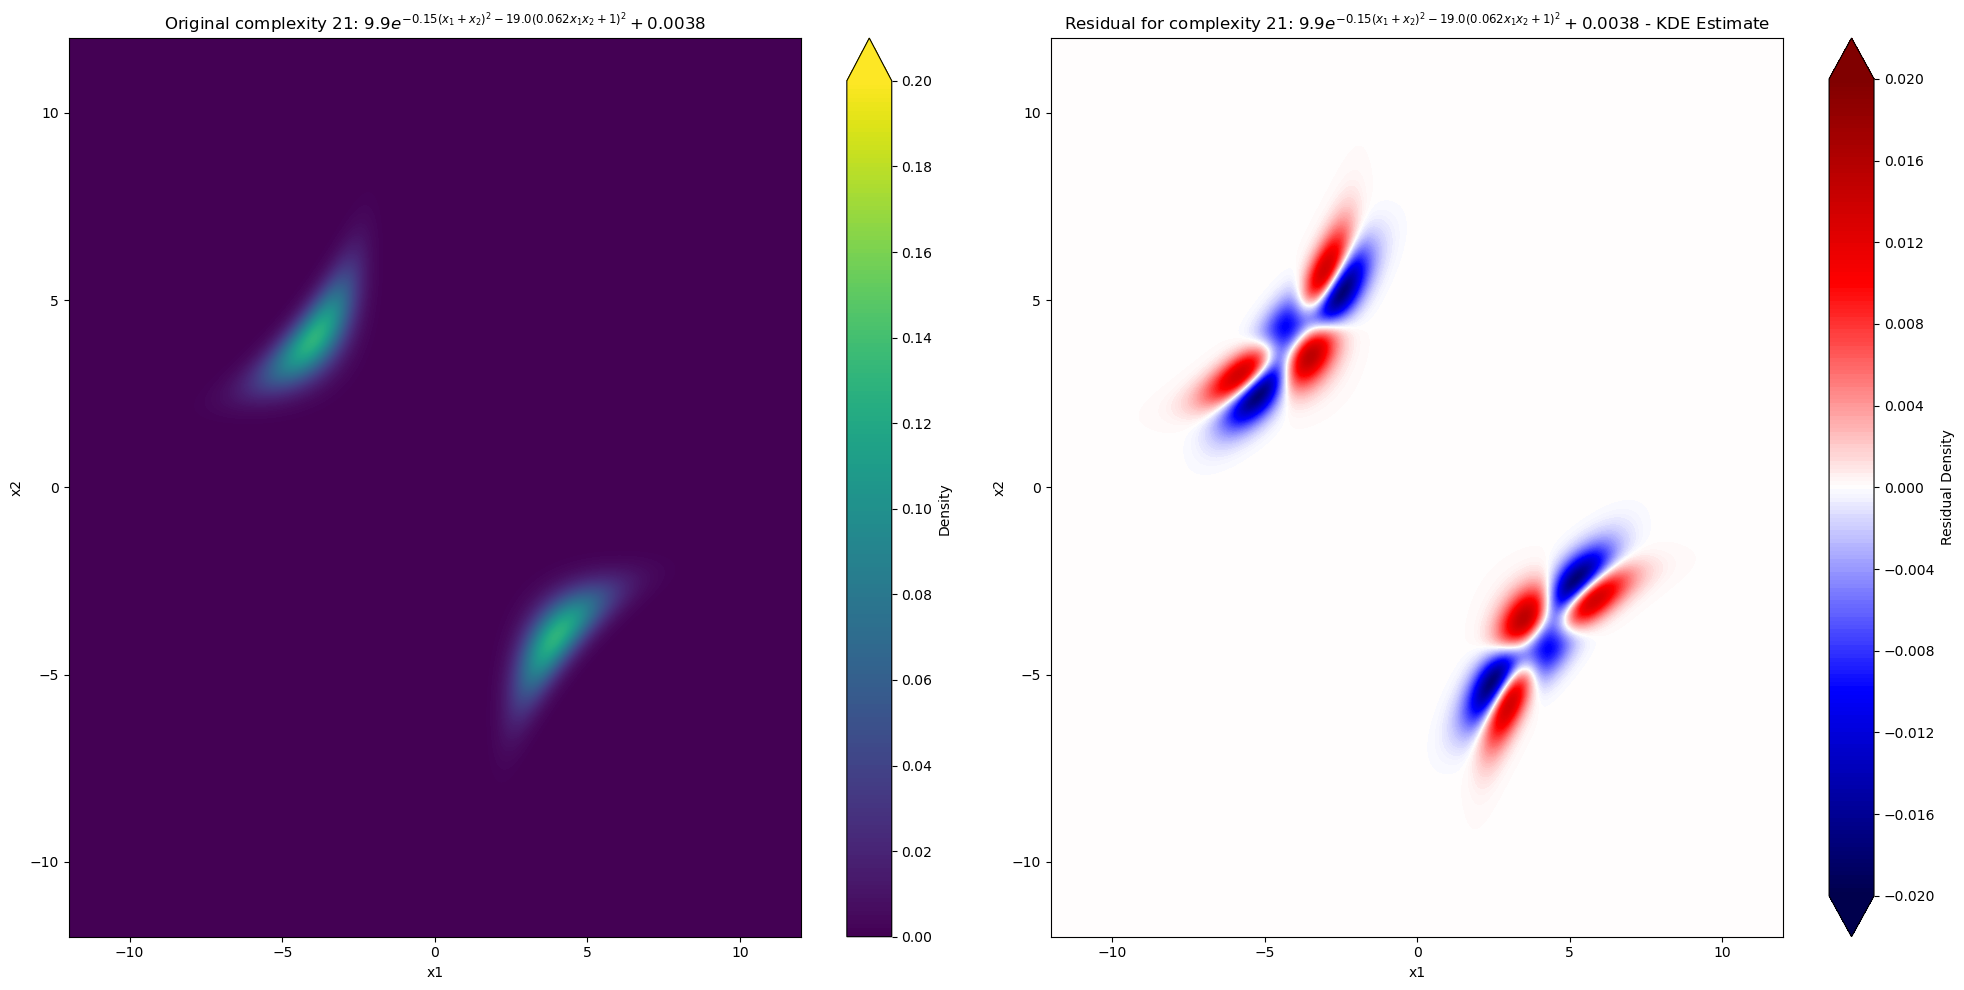

Complexity 21: Likelihood score: -157,835.9088184287
complexity 21 :: min predict: 0.00, max predict: 0.13
complexity 21 :: min residual: -0.02, max residual: 0.02
Complexity 21: MSE error: 1.950138e-02


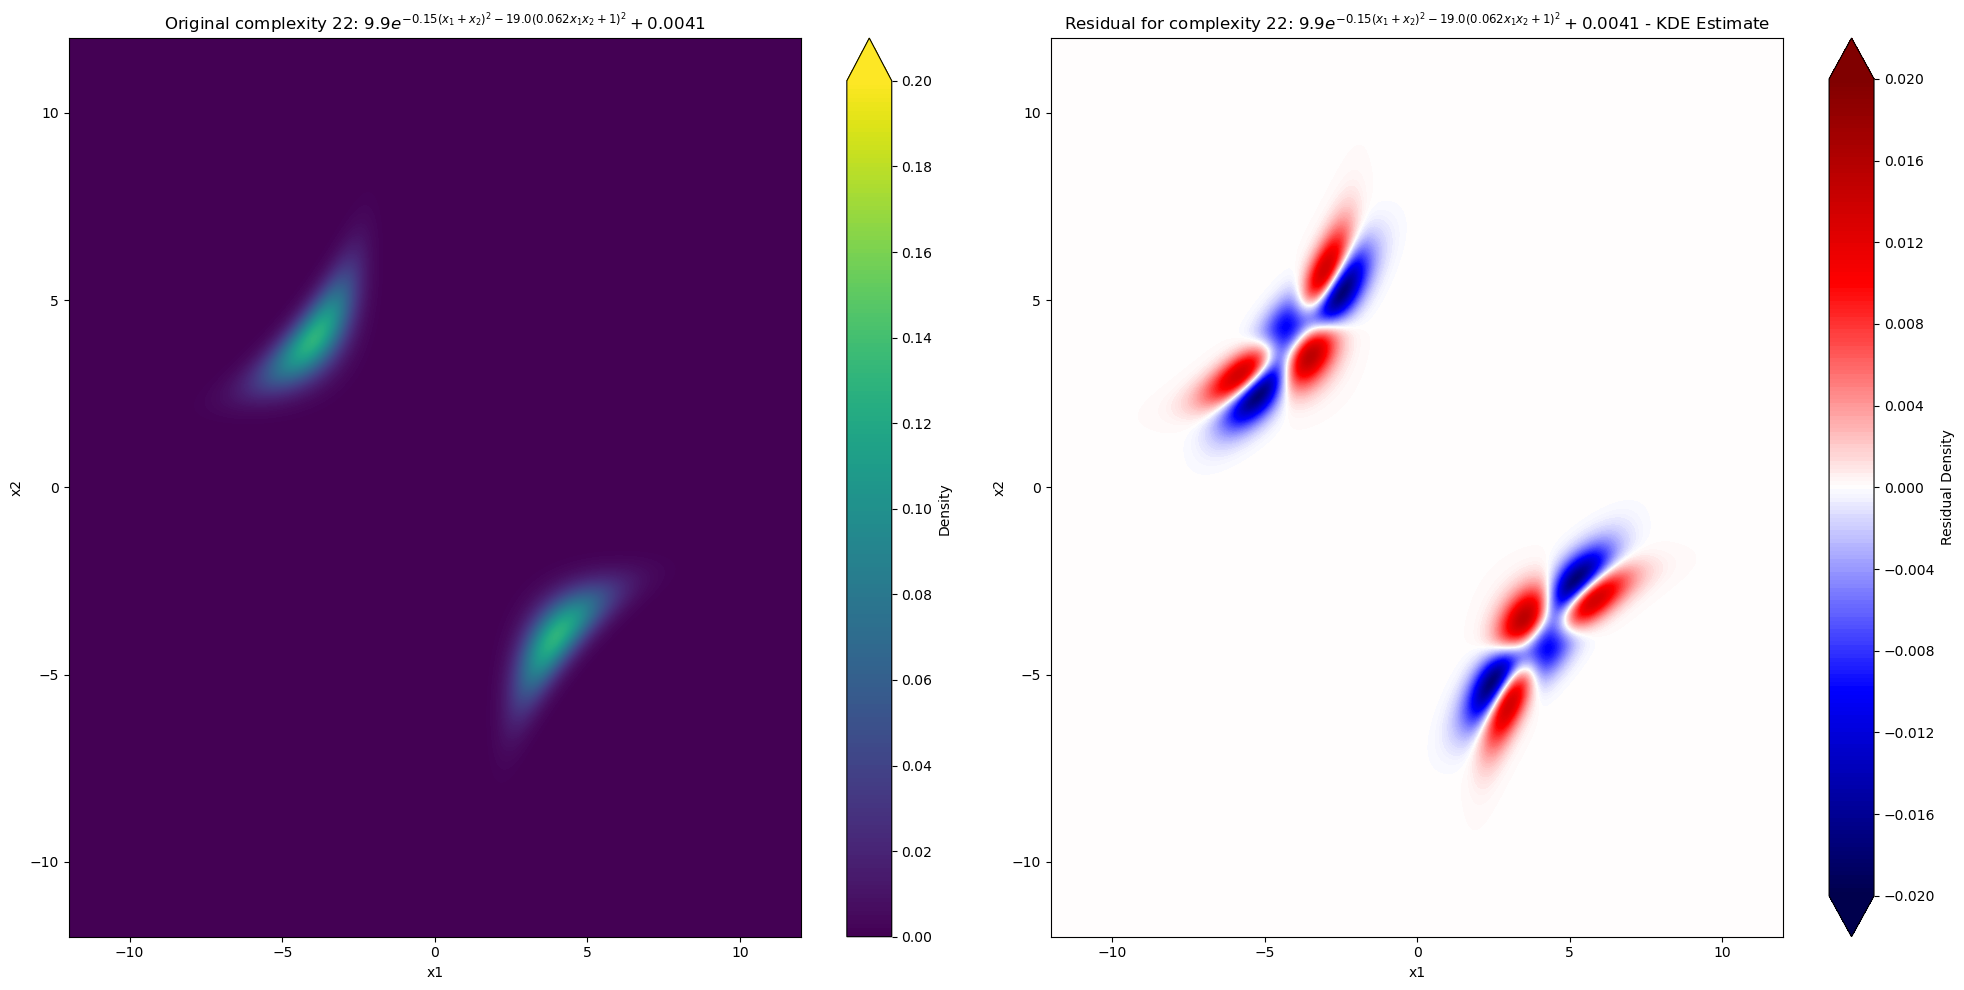

Complexity 22: Likelihood score: -157,800.48604220516
complexity 22 :: min predict: 0.00, max predict: 0.13
complexity 22 :: min residual: -0.02, max residual: 0.02
Complexity 22: MSE error: 1.953933e-02


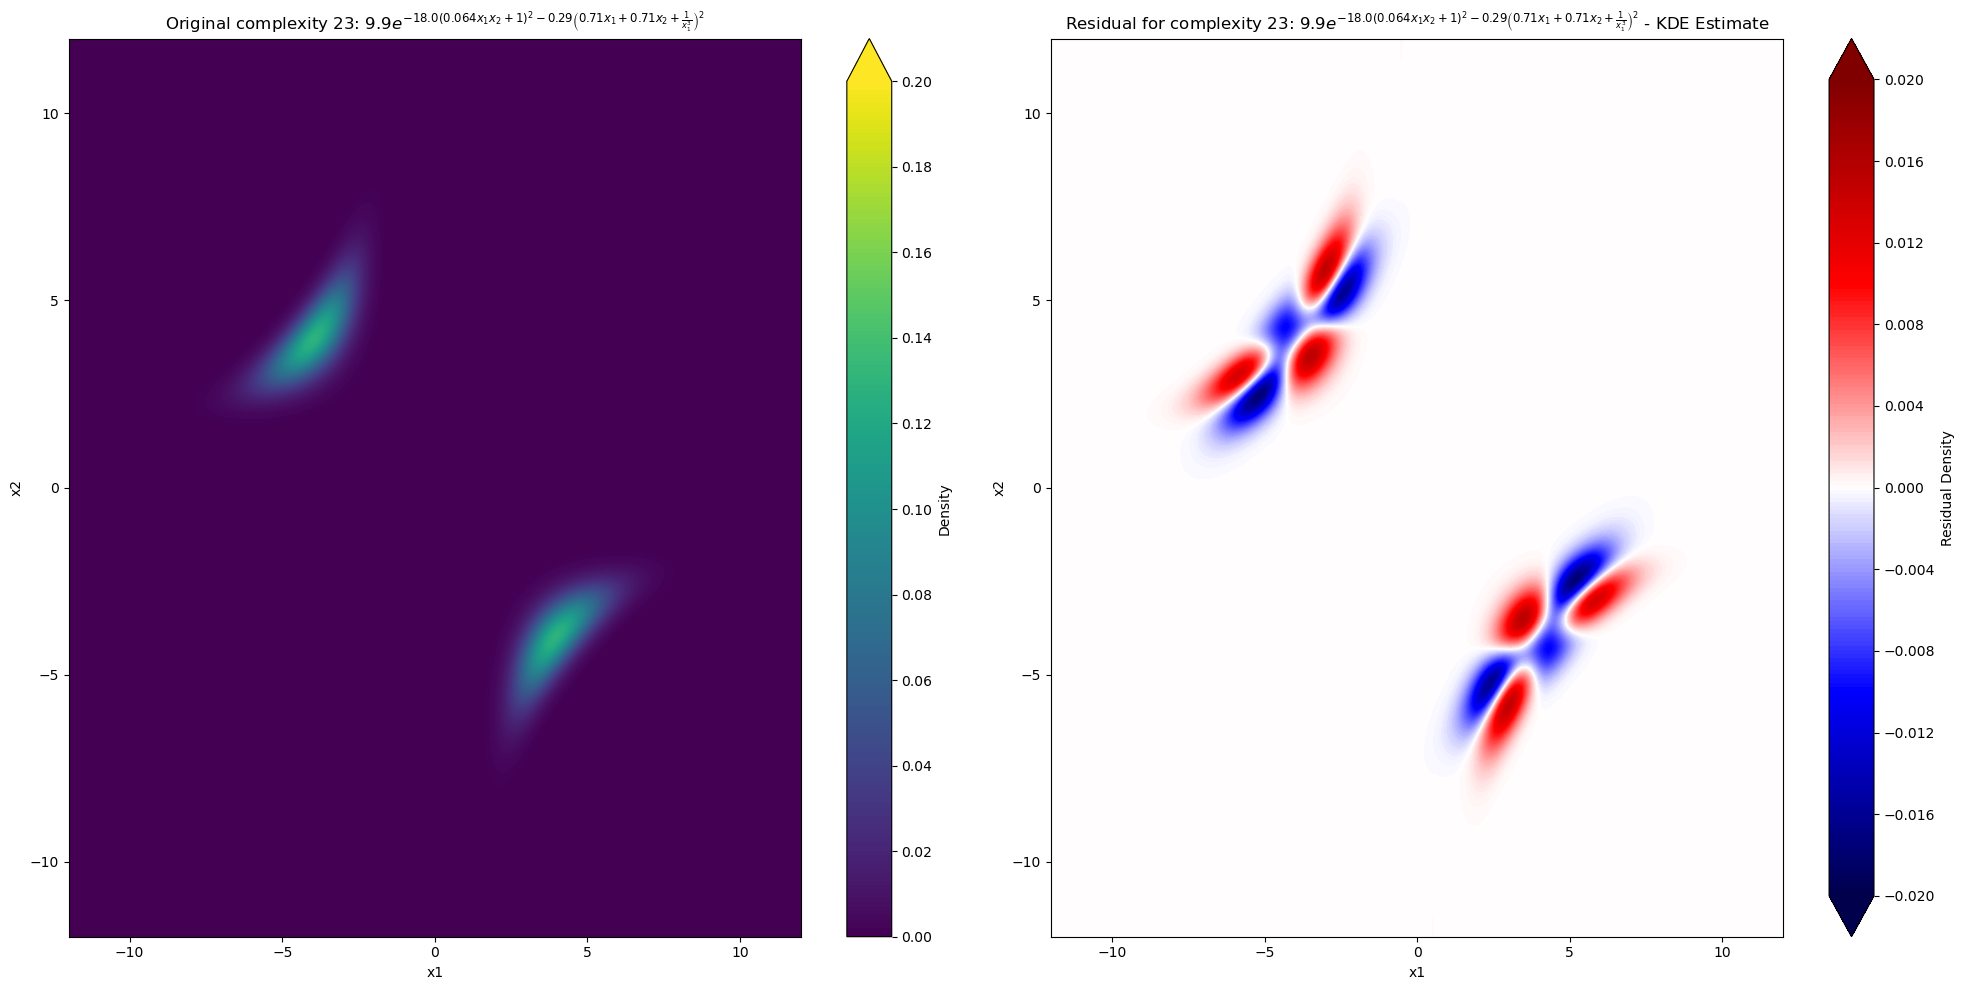

Complexity 23: Likelihood score: -inf
complexity 23 :: min predict: 0.00, max predict: 0.13
complexity 23 :: min residual: -0.02, max residual: 0.02
Complexity 23: MSE error: 1.924635e-02


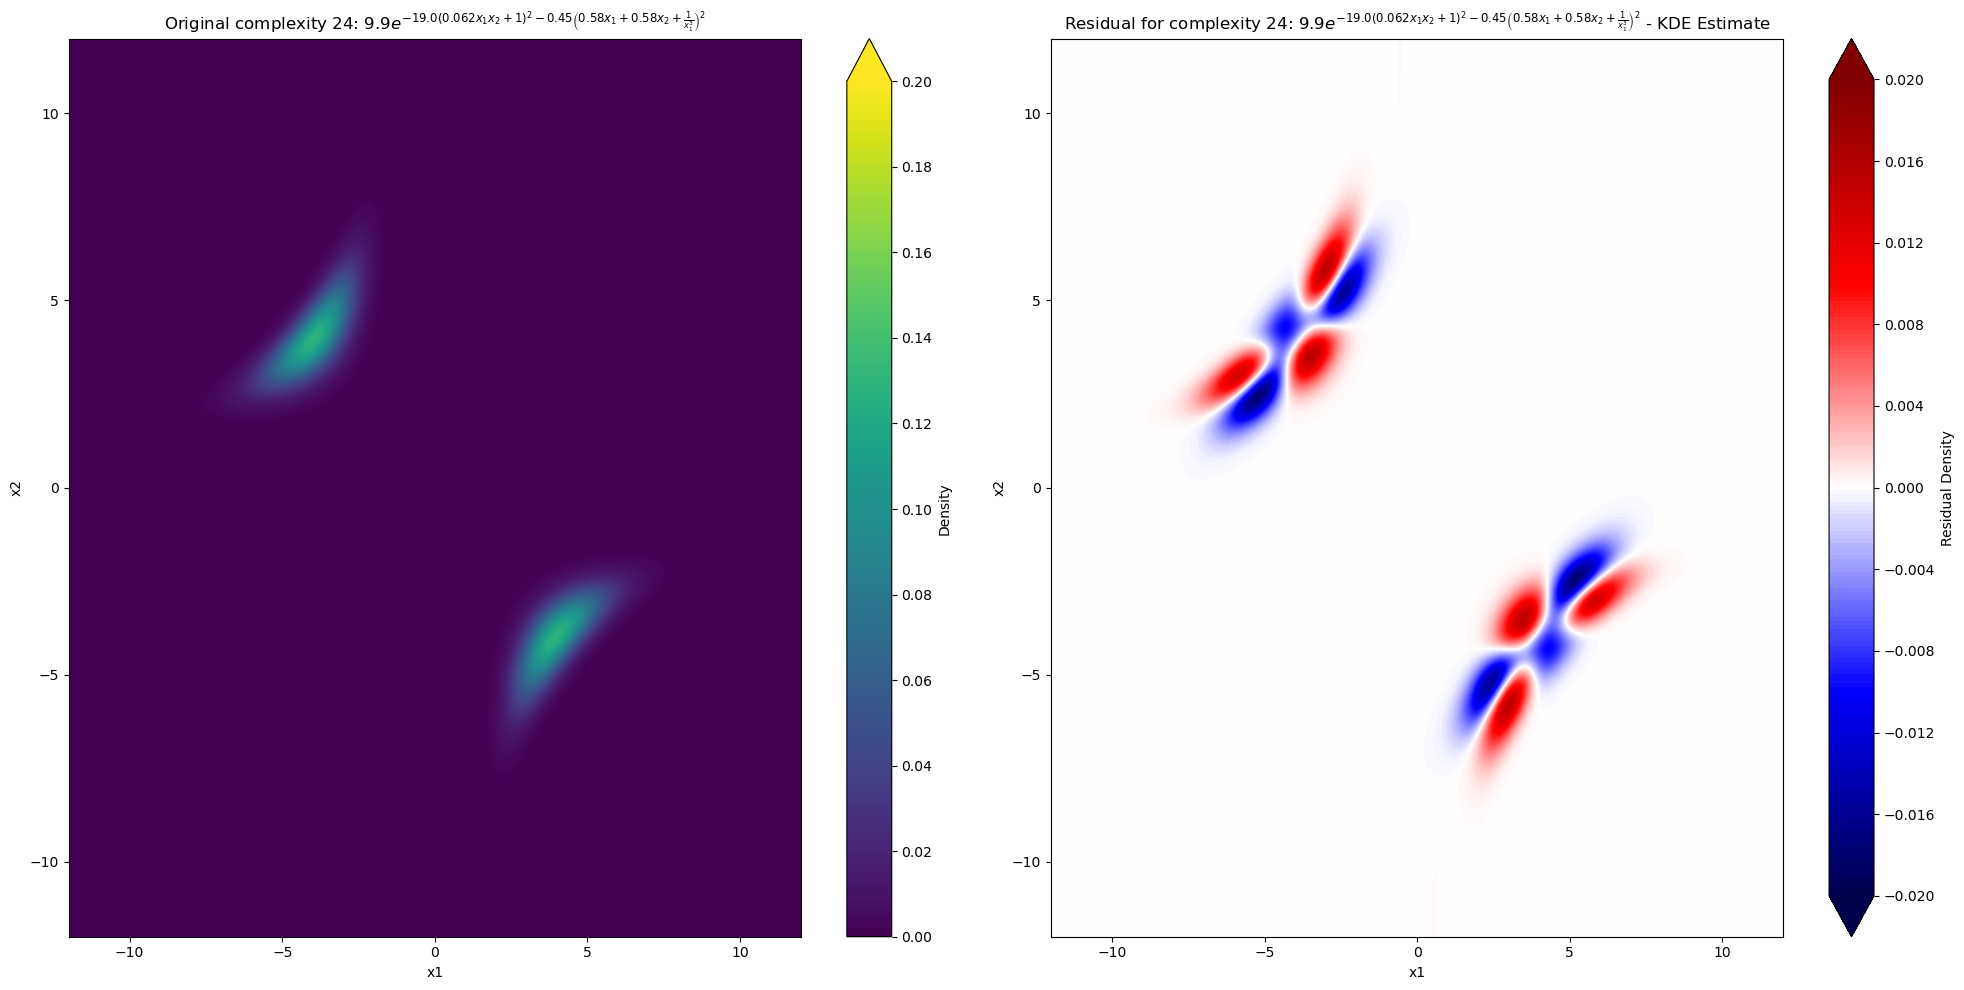

Complexity 24: Likelihood score: -inf
complexity 24 :: min predict: 0.00, max predict: 0.13
complexity 24 :: min residual: -0.02, max residual: 0.02
Complexity 24: MSE error: 1.921621e-02


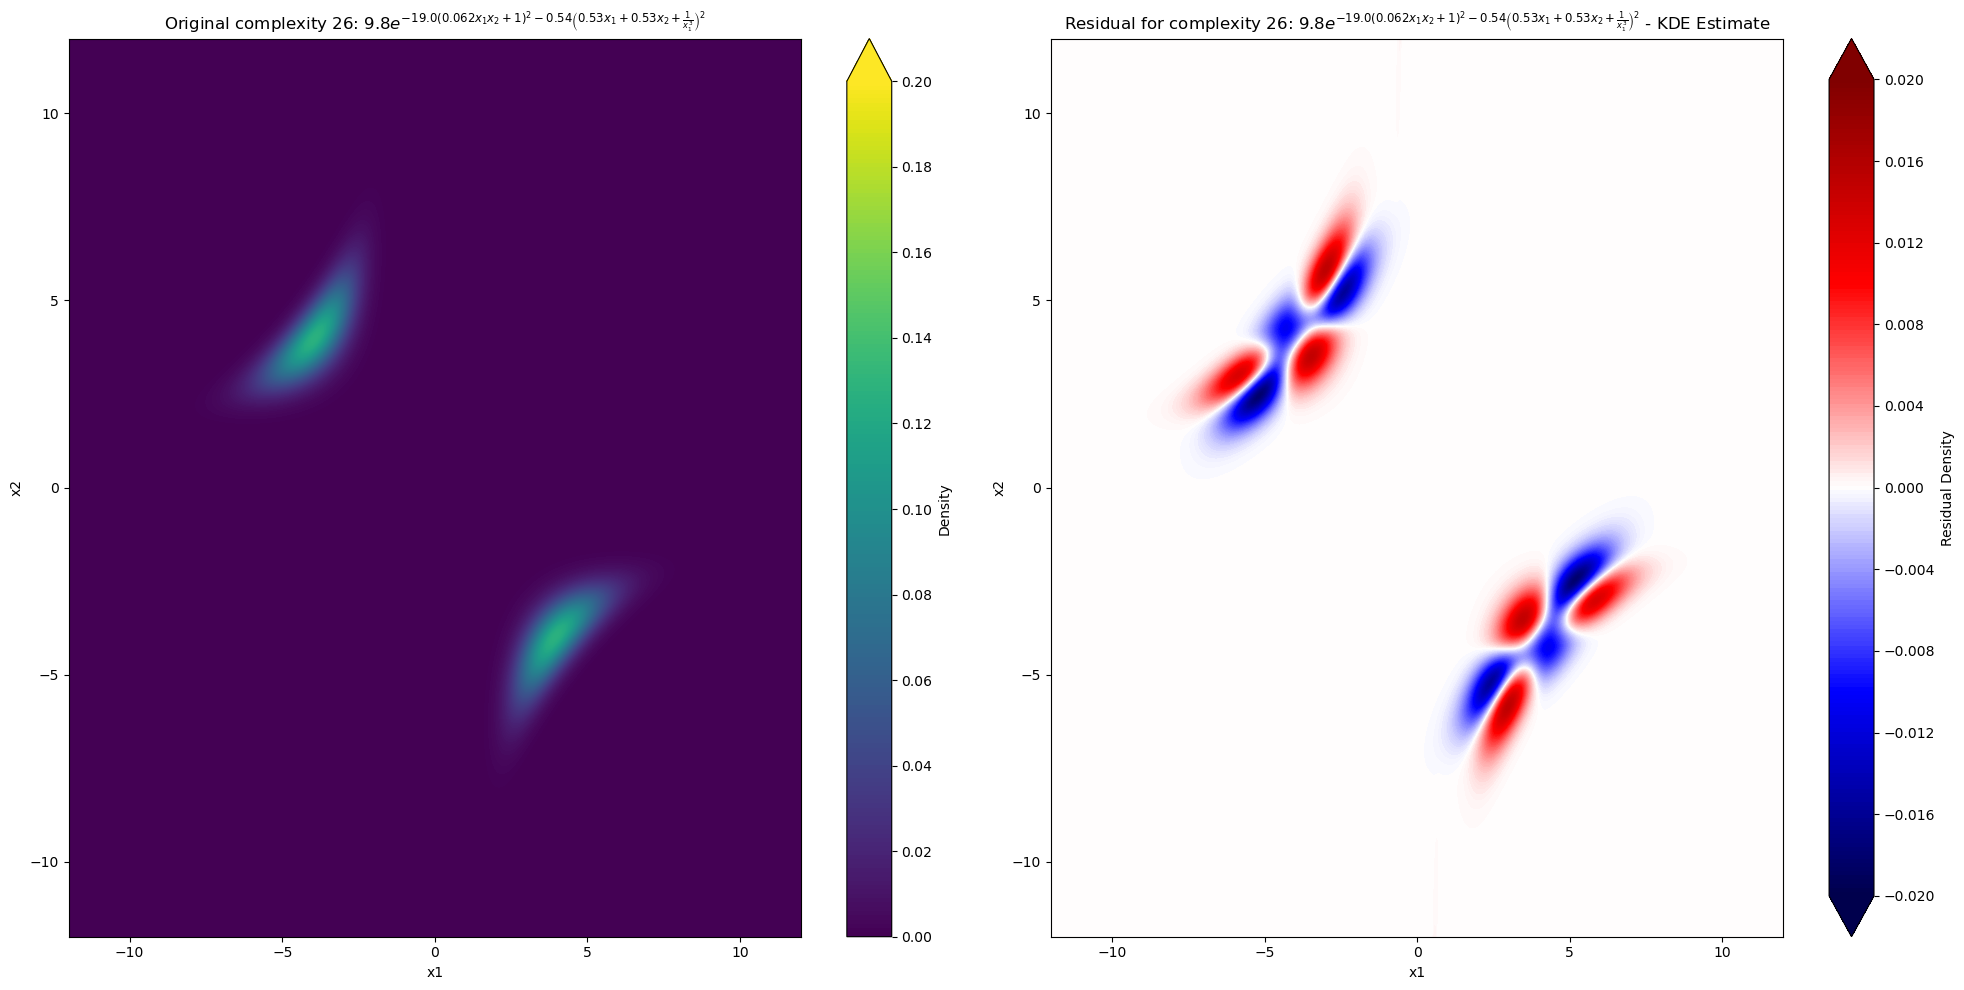

Complexity 26: Likelihood score: -inf
complexity 26 :: min predict: 0.00, max predict: 0.13
complexity 26 :: min residual: -0.02, max residual: 0.01
Complexity 26: MSE error: 1.931612e-02


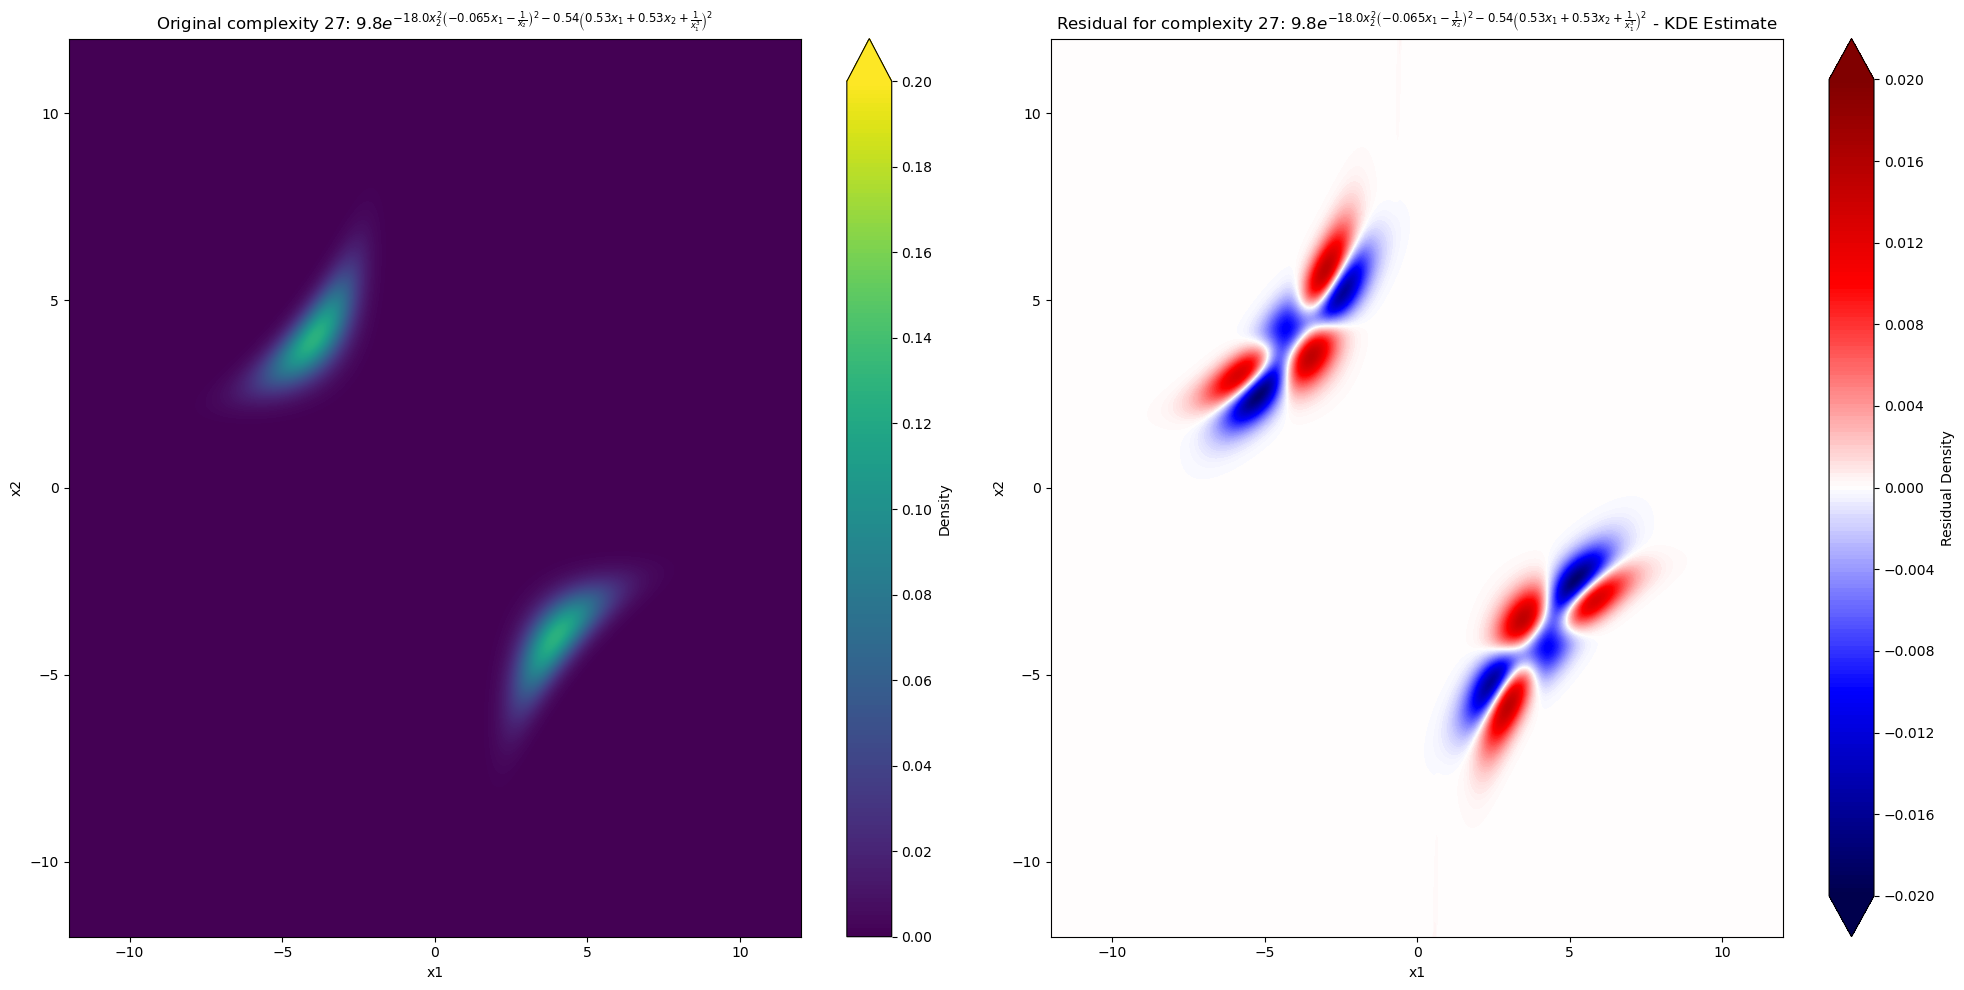

Complexity 27: Likelihood score: -inf
complexity 27 :: min predict: 0.00, max predict: 0.13
complexity 27 :: min residual: -0.02, max residual: 0.01
Complexity 27: MSE error: 1.931155e-02


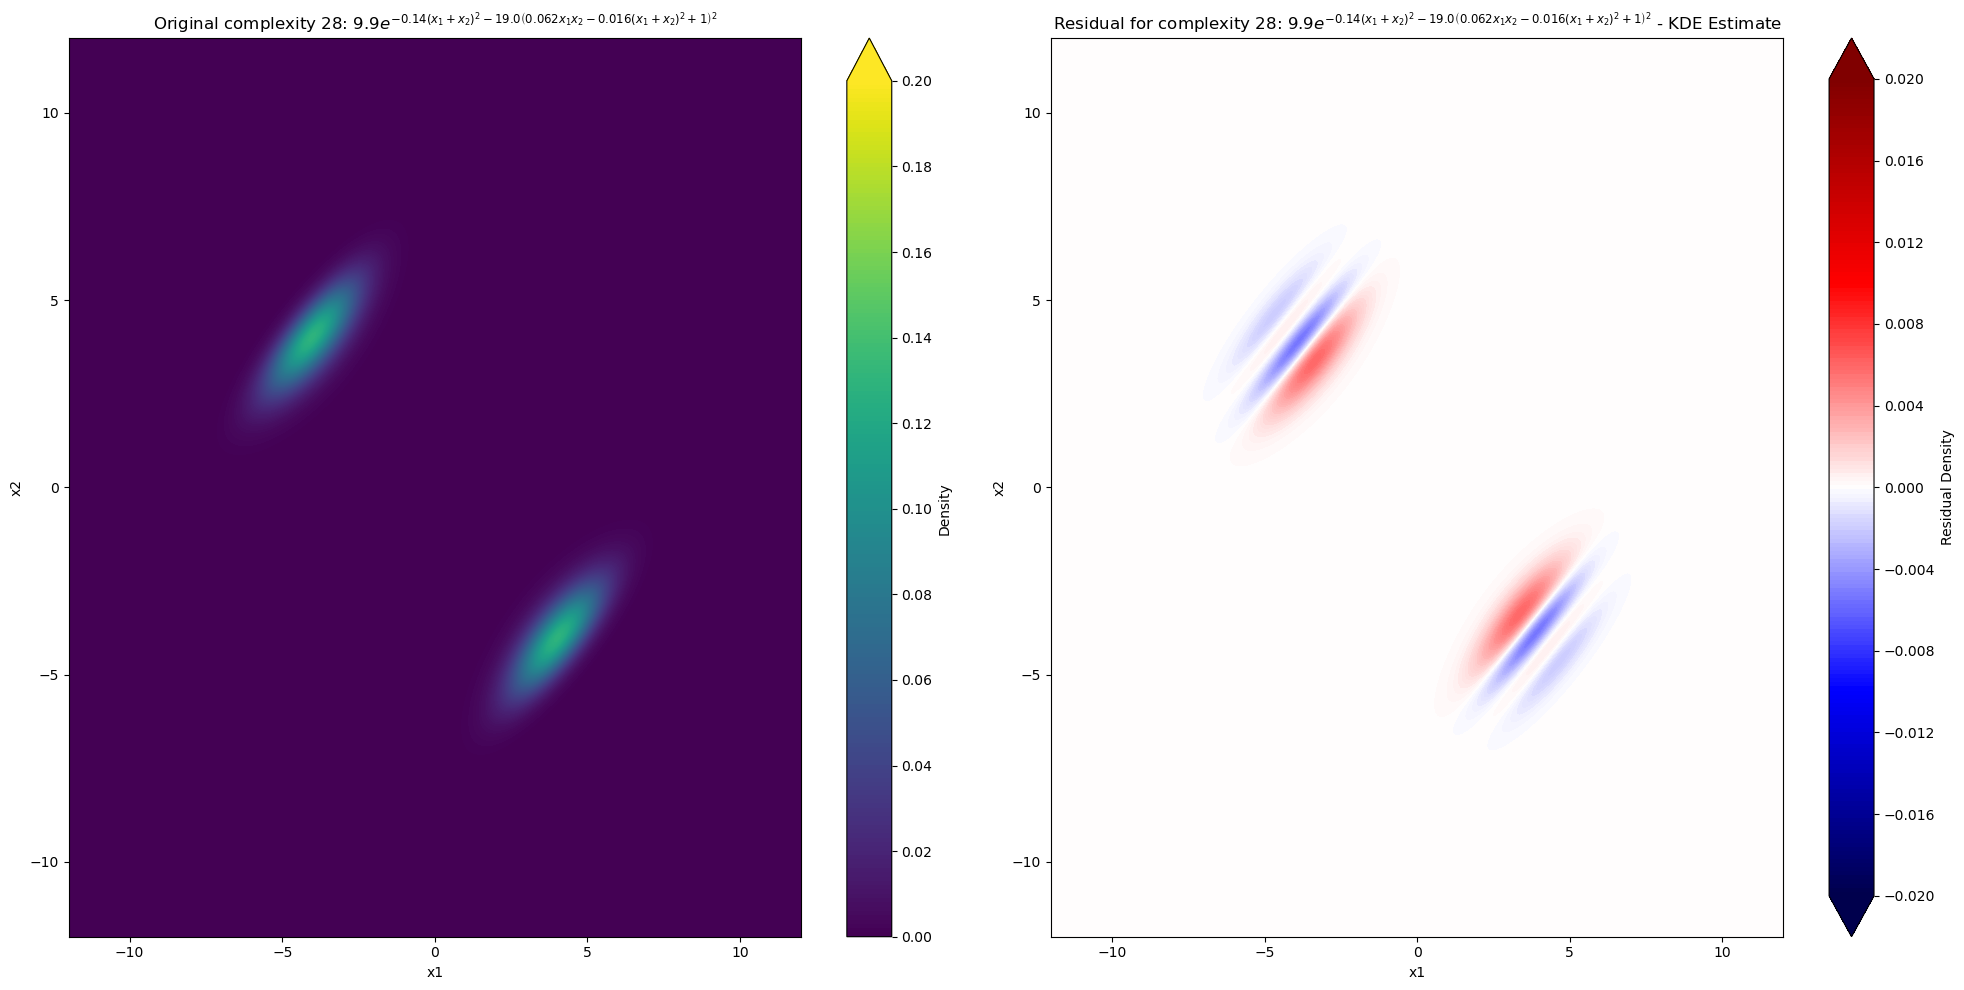

Complexity 28: Likelihood score: -151,194.77239682237
complexity 28 :: min predict: 0.00, max predict: 0.13
complexity 28 :: min residual: -0.01, max residual: 0.01
Complexity 28: MSE error: 1.501591e-03


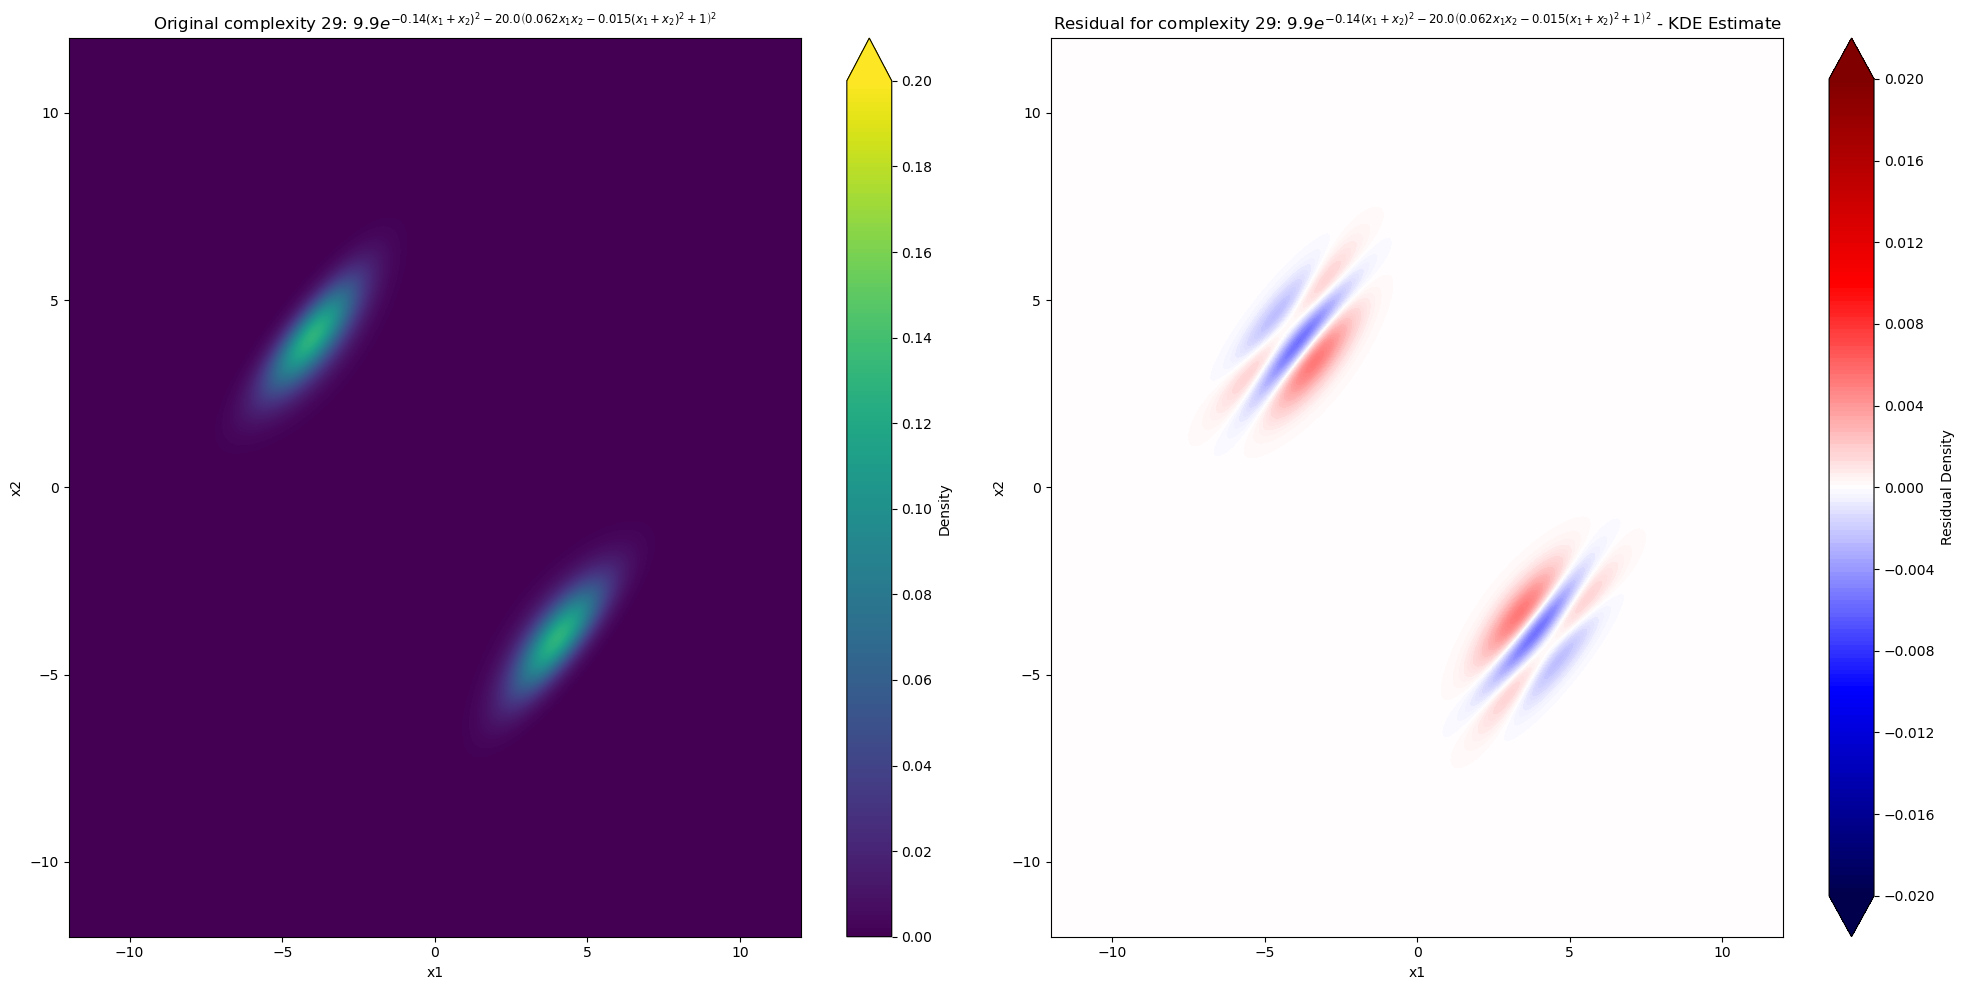

Complexity 29: Likelihood score: -151,236.93241232703
complexity 29 :: min predict: 0.00, max predict: 0.13
complexity 29 :: min residual: -0.01, max residual: 0.01
Complexity 29: MSE error: 1.347515e-03


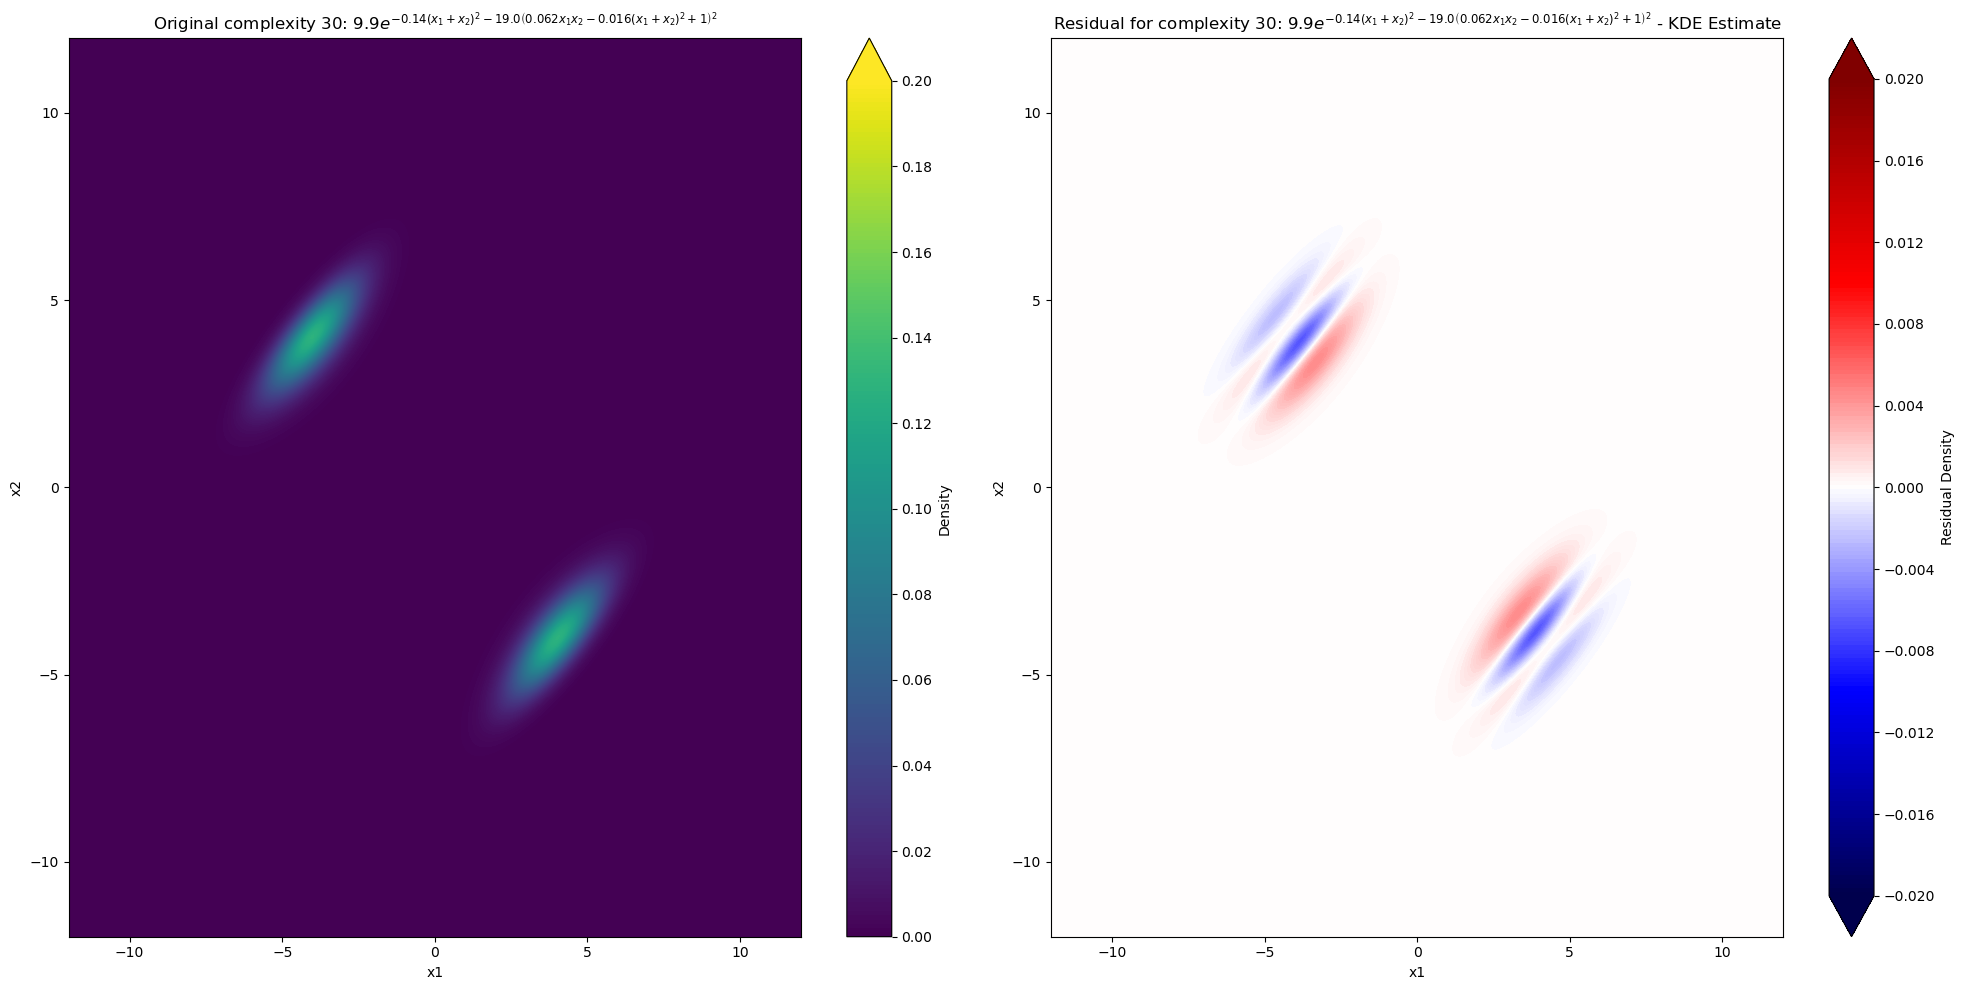

Complexity 30: Likelihood score: -151,460.65289347337
complexity 30 :: min predict: 0.00, max predict: 0.13
complexity 30 :: min residual: -0.01, max residual: 0.00
Complexity 30: MSE error: 1.365469e-03


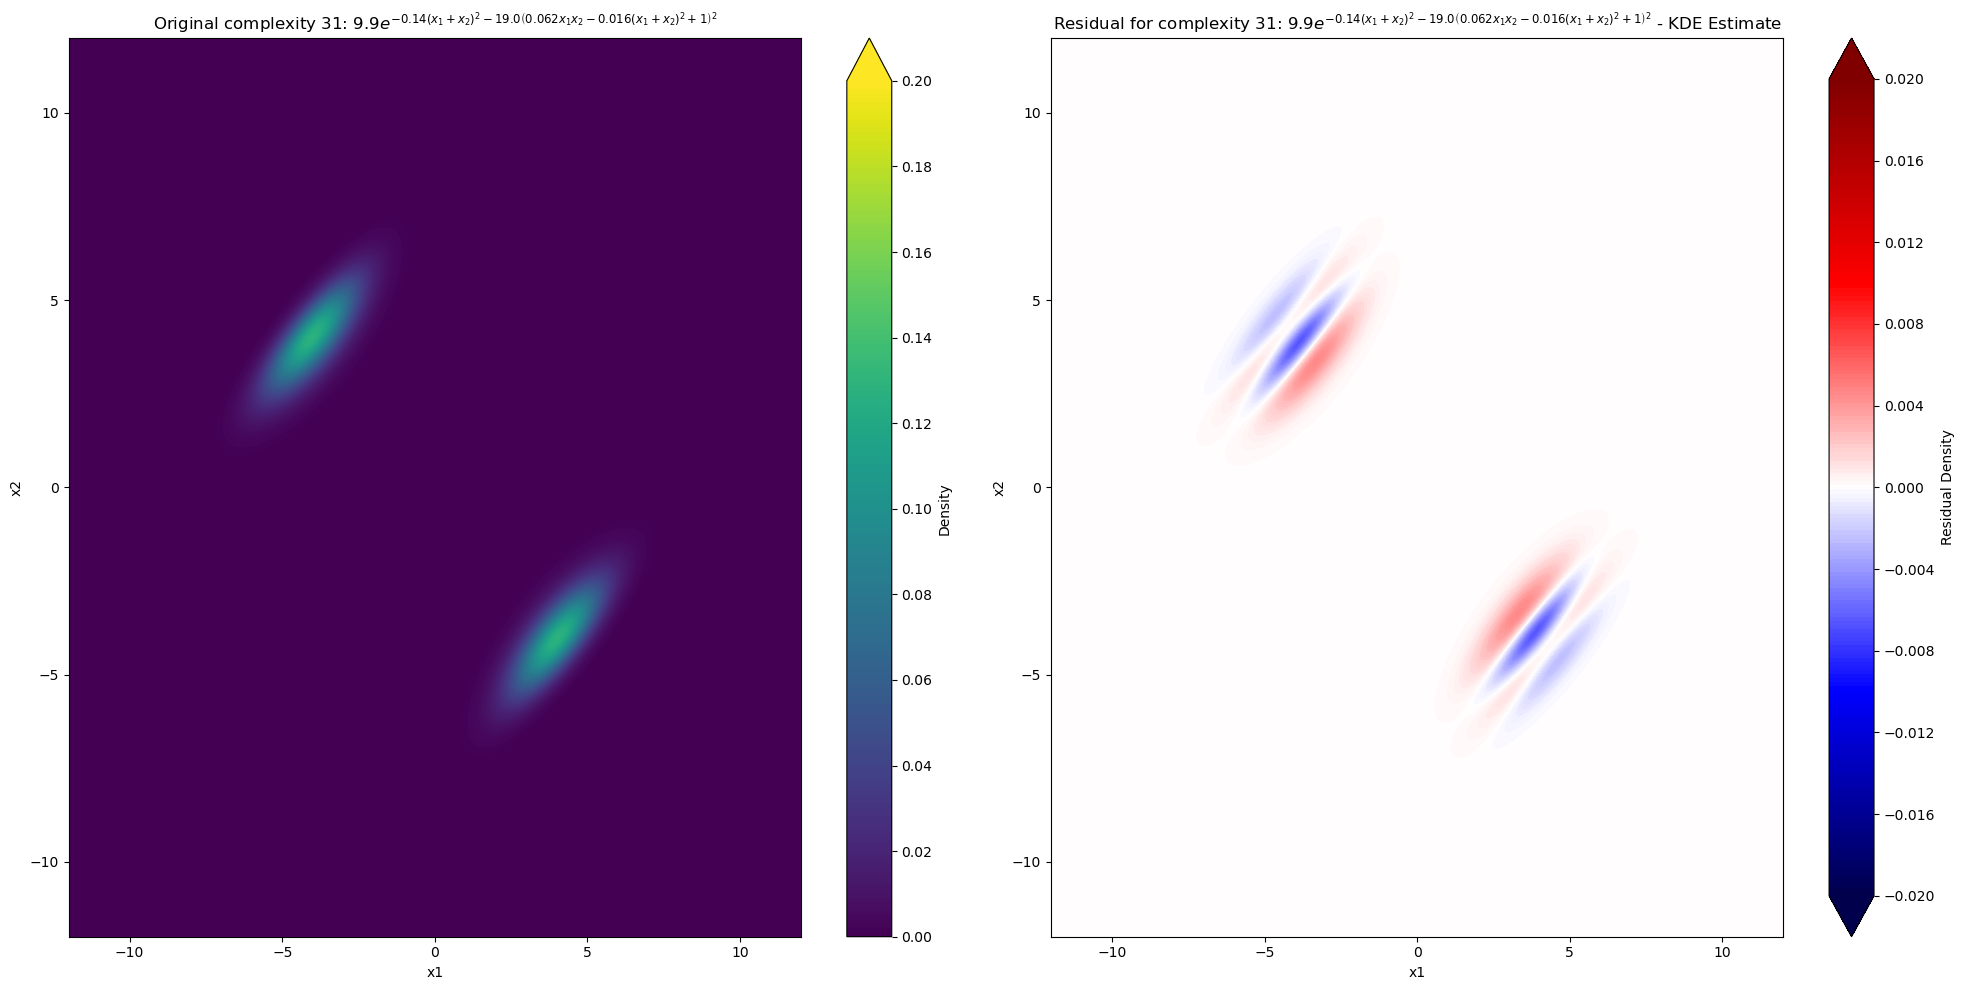

Complexity 31: Likelihood score: -151,345.0368966156
complexity 31 :: min predict: 0.00, max predict: 0.13
complexity 31 :: min residual: -0.01, max residual: 0.00
Complexity 31: MSE error: 1.362296e-03


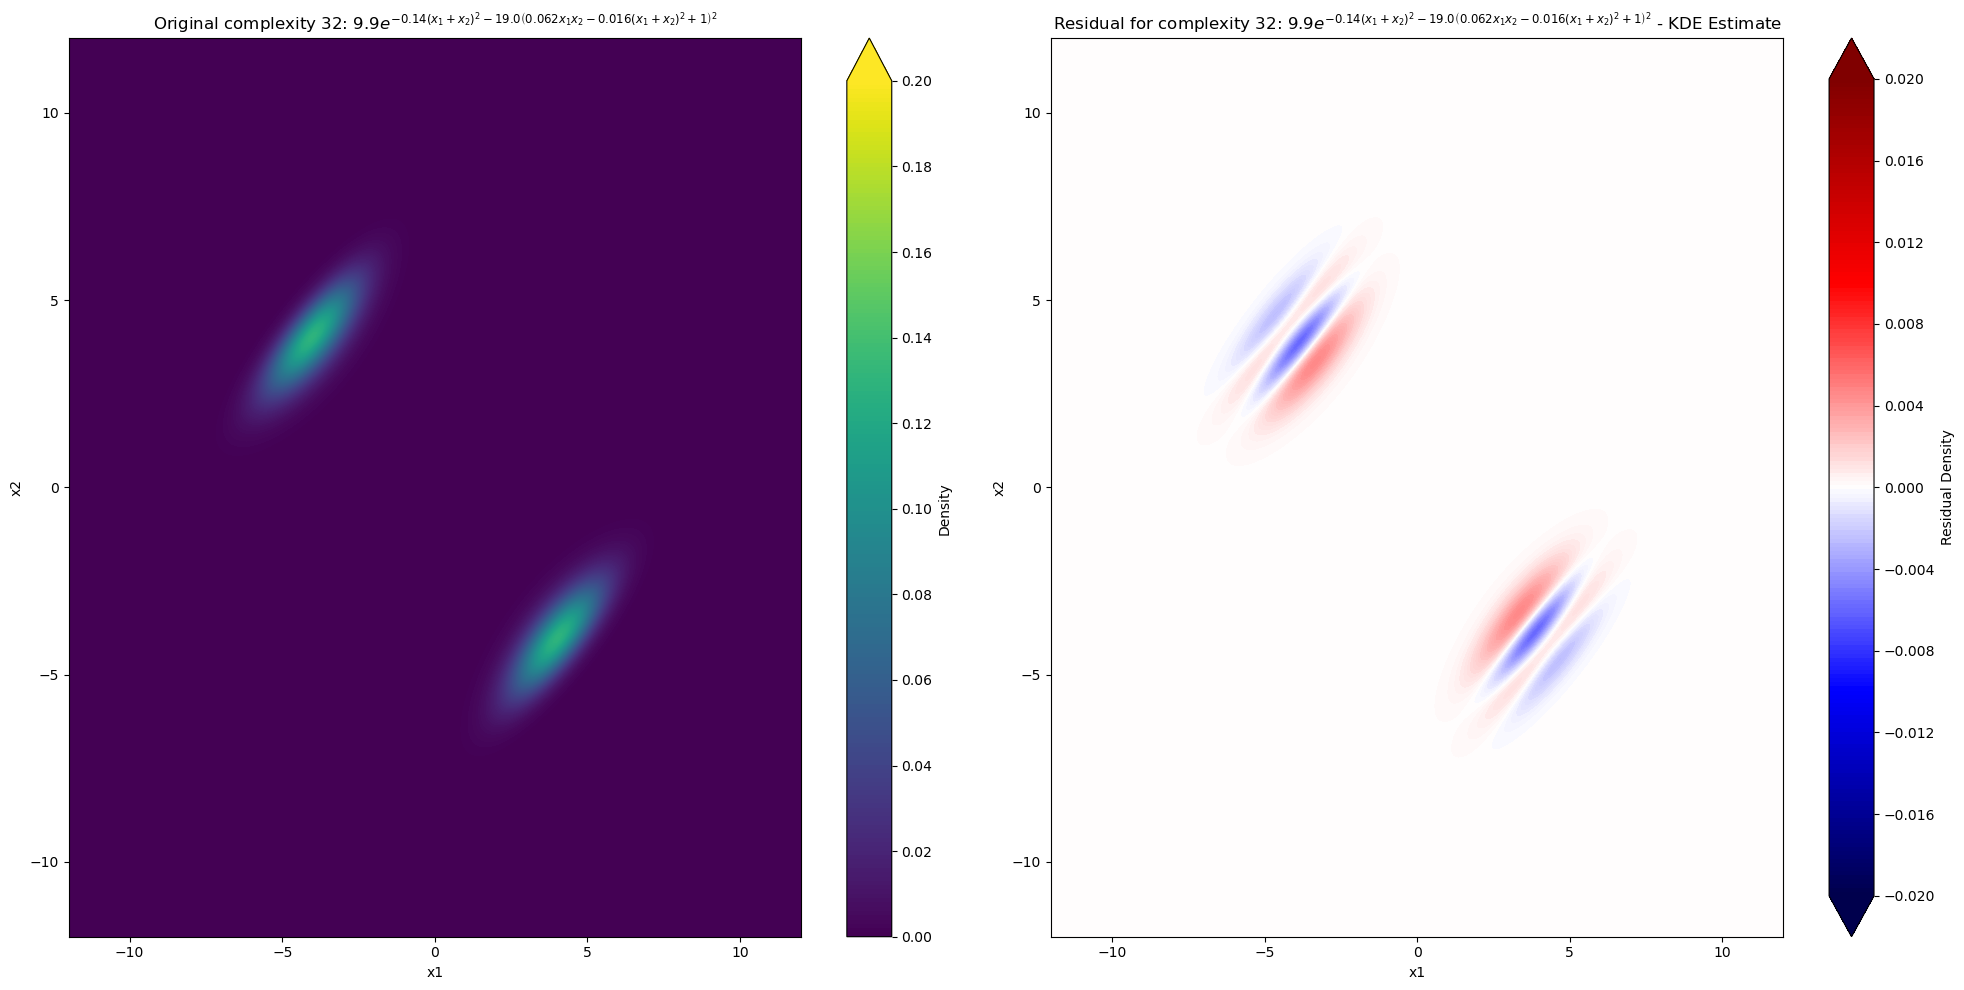

Complexity 32: Likelihood score: -151,128.54990513445
complexity 32 :: min predict: 0.00, max predict: 0.13
complexity 32 :: min residual: -0.01, max residual: 0.00
Complexity 32: MSE error: 1.207934e-03


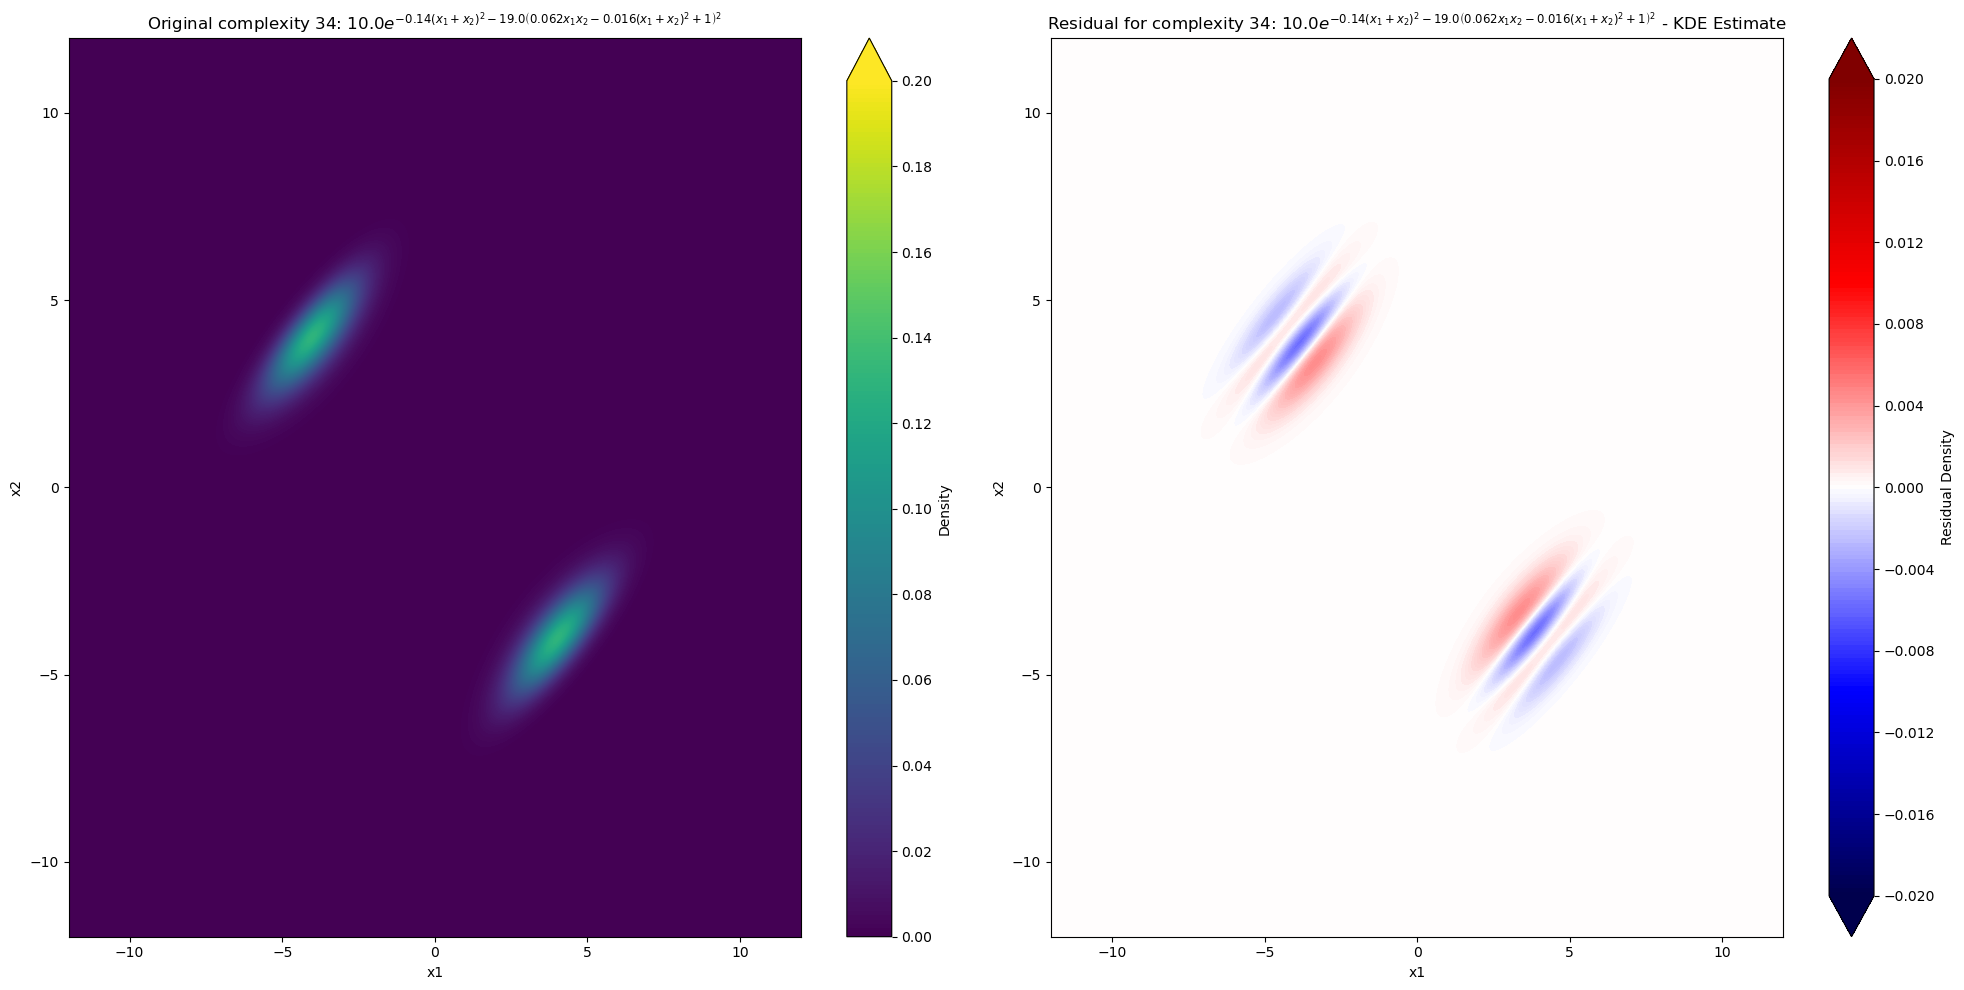

Complexity 34: Likelihood score: -151,320.06054591088
complexity 34 :: min predict: 0.00, max predict: 0.13
complexity 34 :: min residual: -0.01, max residual: 0.00
Complexity 34: MSE error: 1.149391e-03


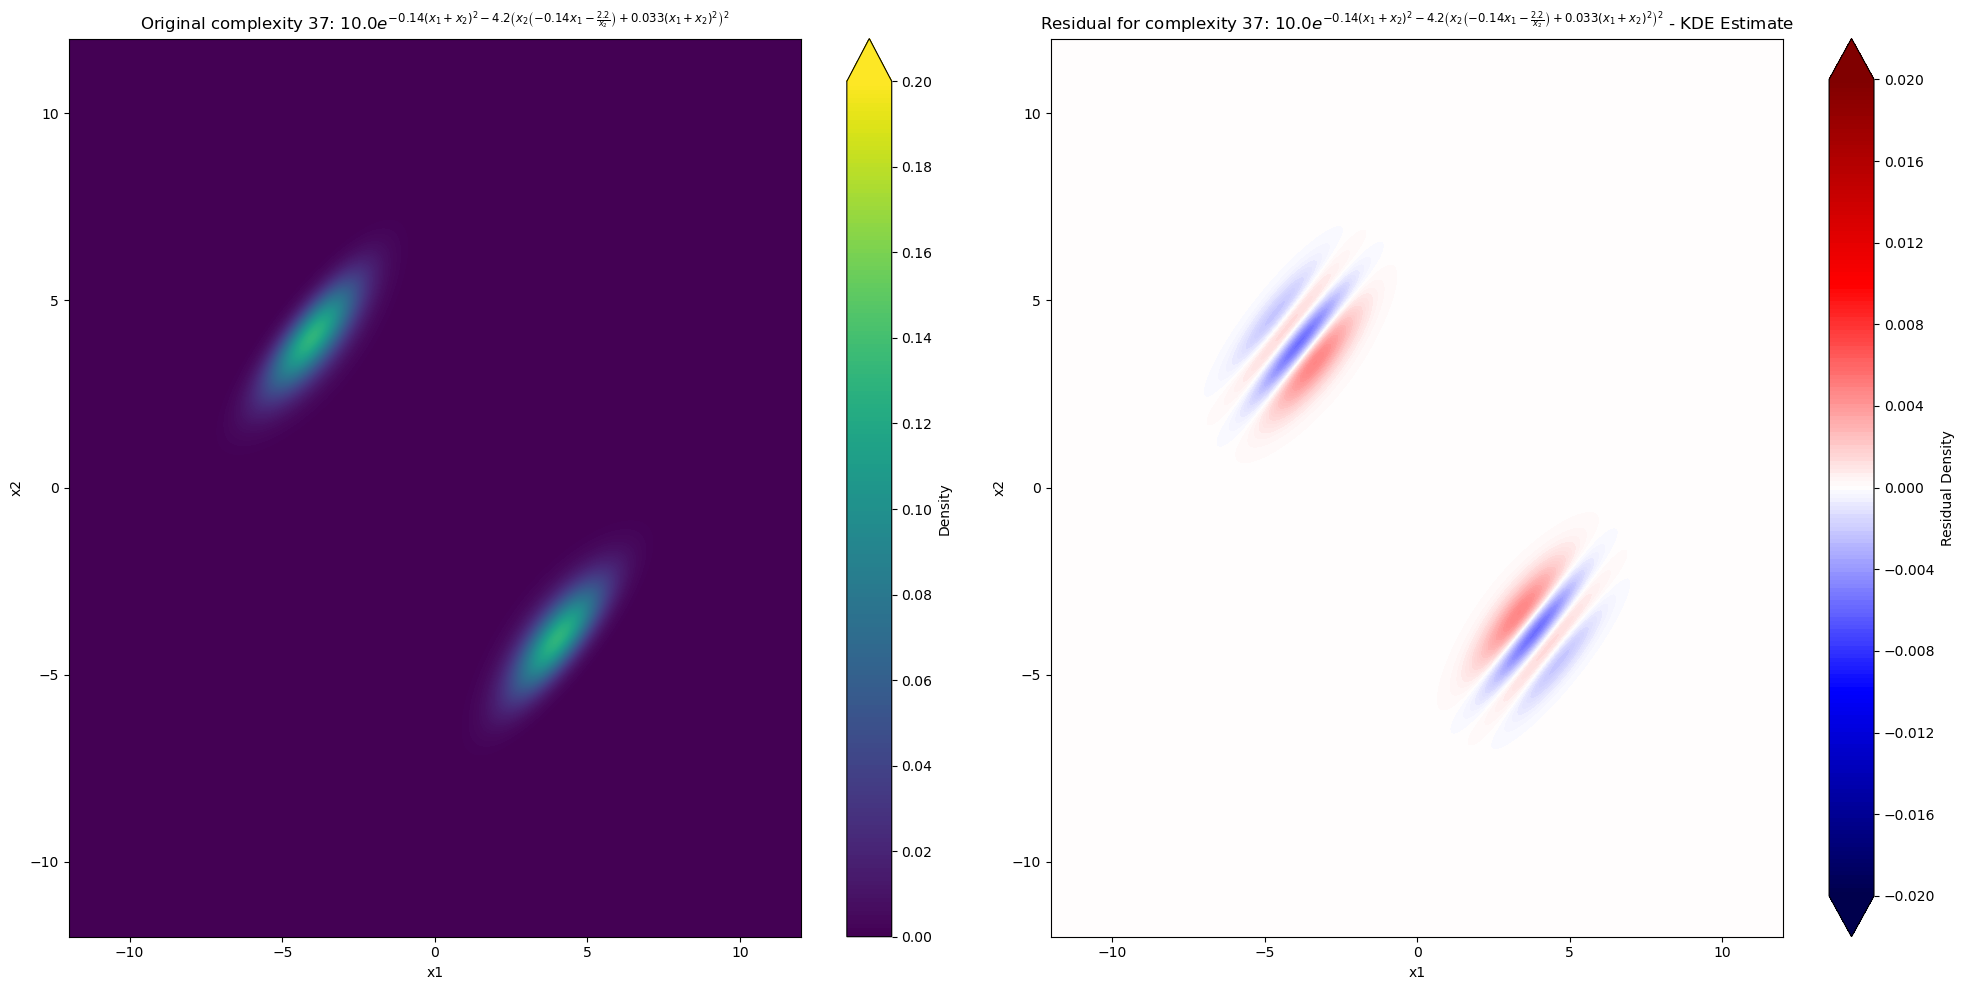

Complexity 37: Likelihood score: -151,375.8931587583
complexity 37 :: min predict: 0.00, max predict: 0.13
complexity 37 :: min residual: -0.01, max residual: 0.00
Complexity 37: MSE error: 1.236873e-03


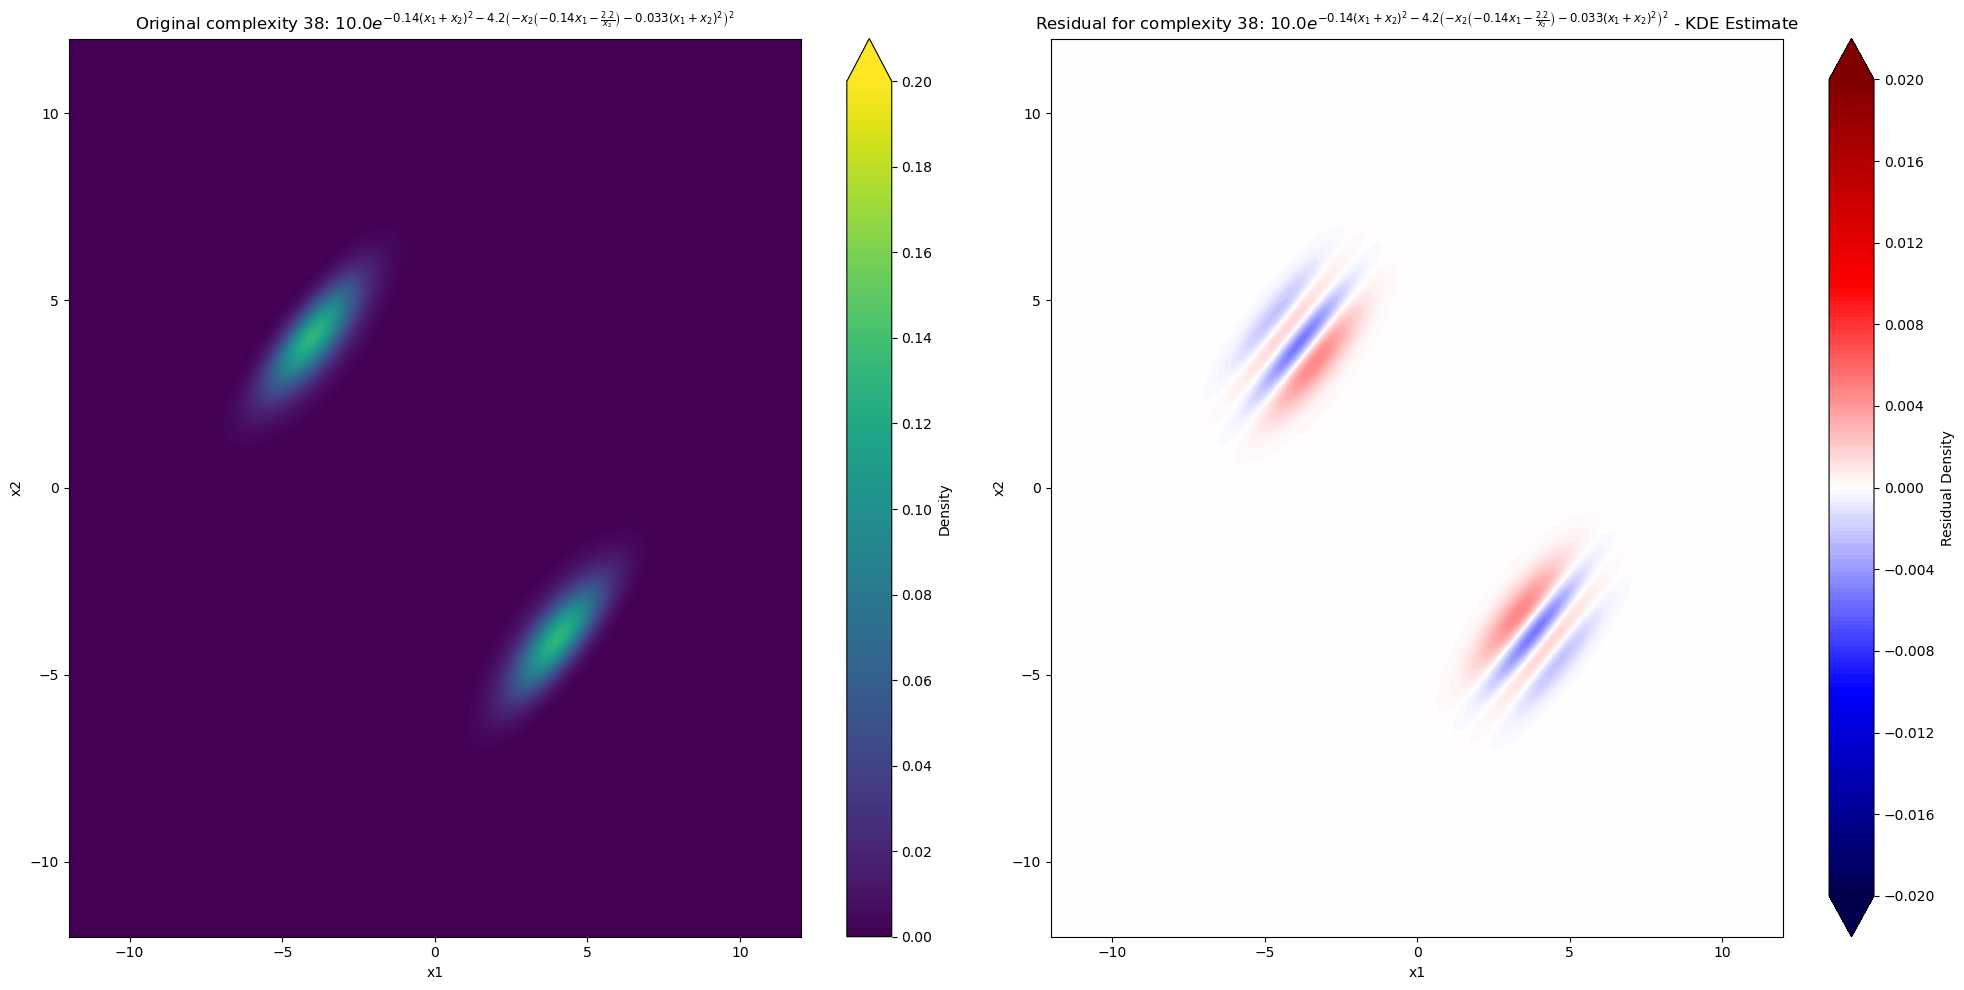

Complexity 38: Likelihood score: -151,335.8023754161
complexity 38 :: min predict: 0.00, max predict: 0.13
complexity 38 :: min residual: -0.01, max residual: 0.00
Complexity 38: MSE error: 1.153894e-03


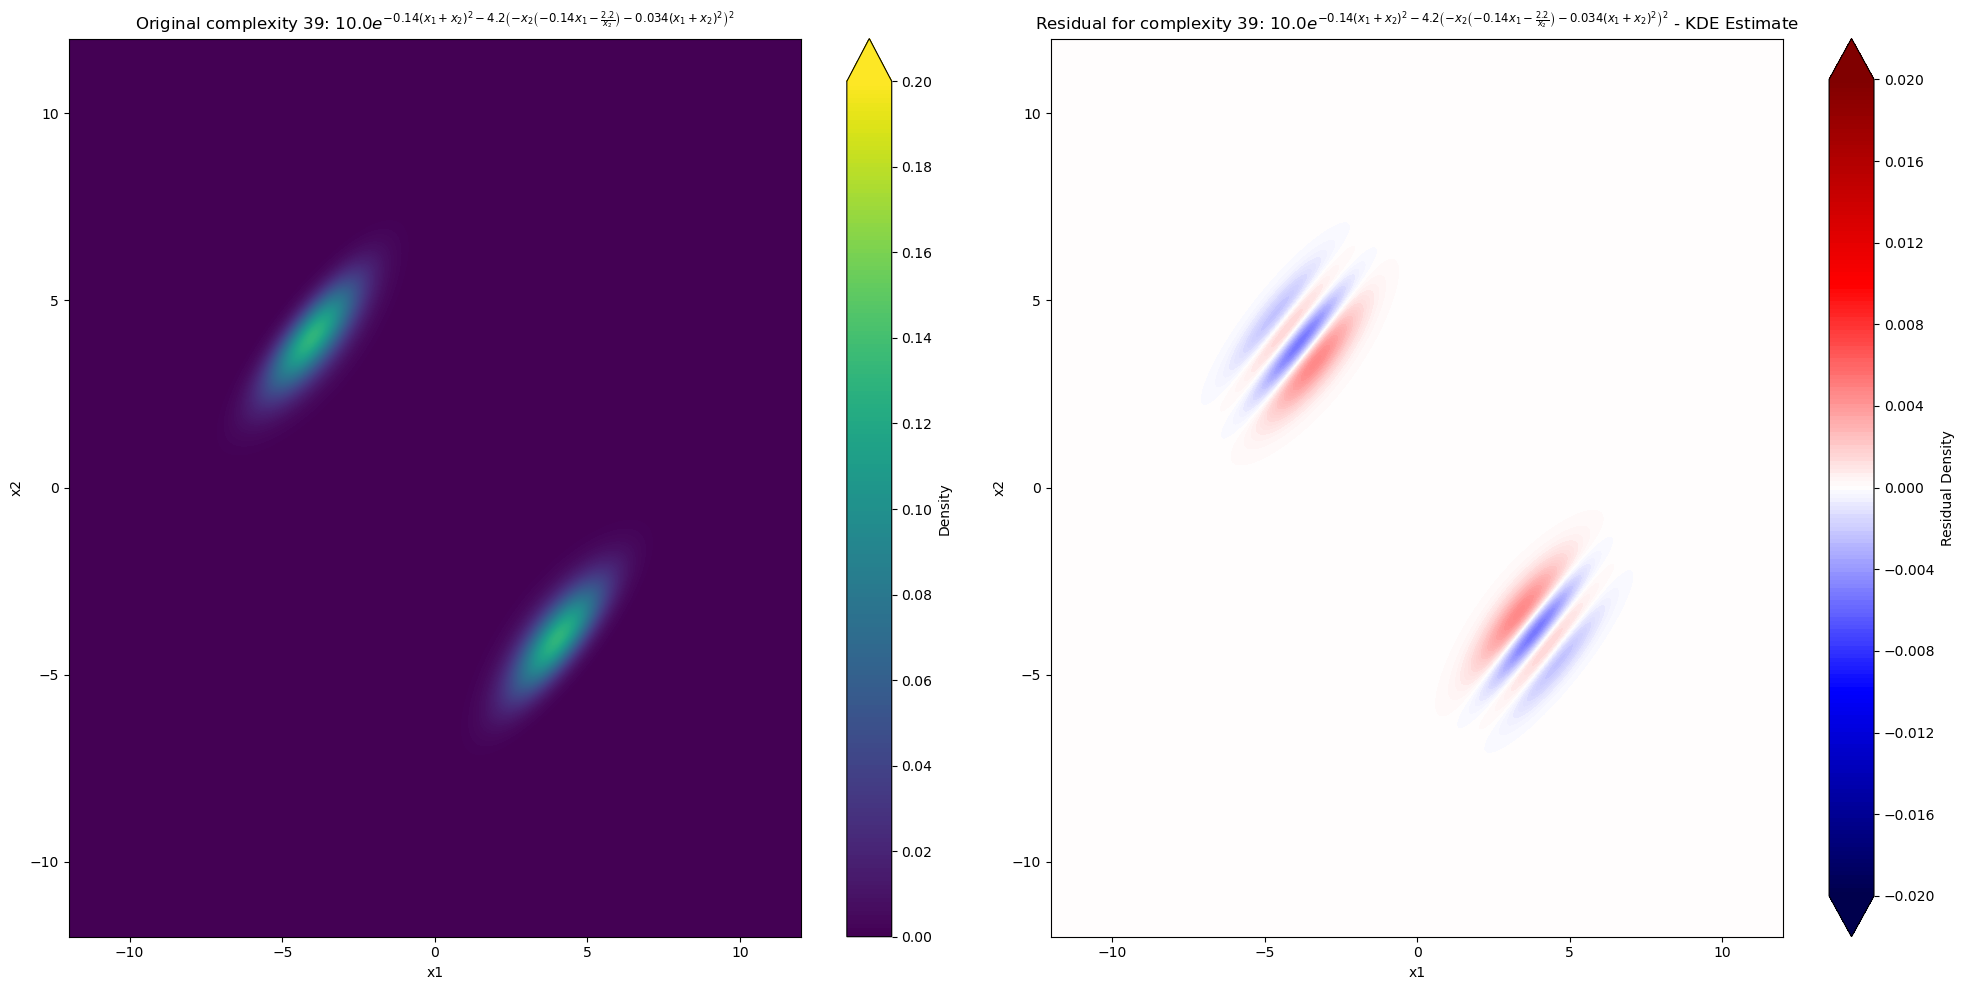

Complexity 39: Likelihood score: -151,330.36371395507
complexity 39 :: min predict: 0.00, max predict: 0.13
complexity 39 :: min residual: -0.01, max residual: 0.00
Complexity 39: MSE error: 1.152259e-03


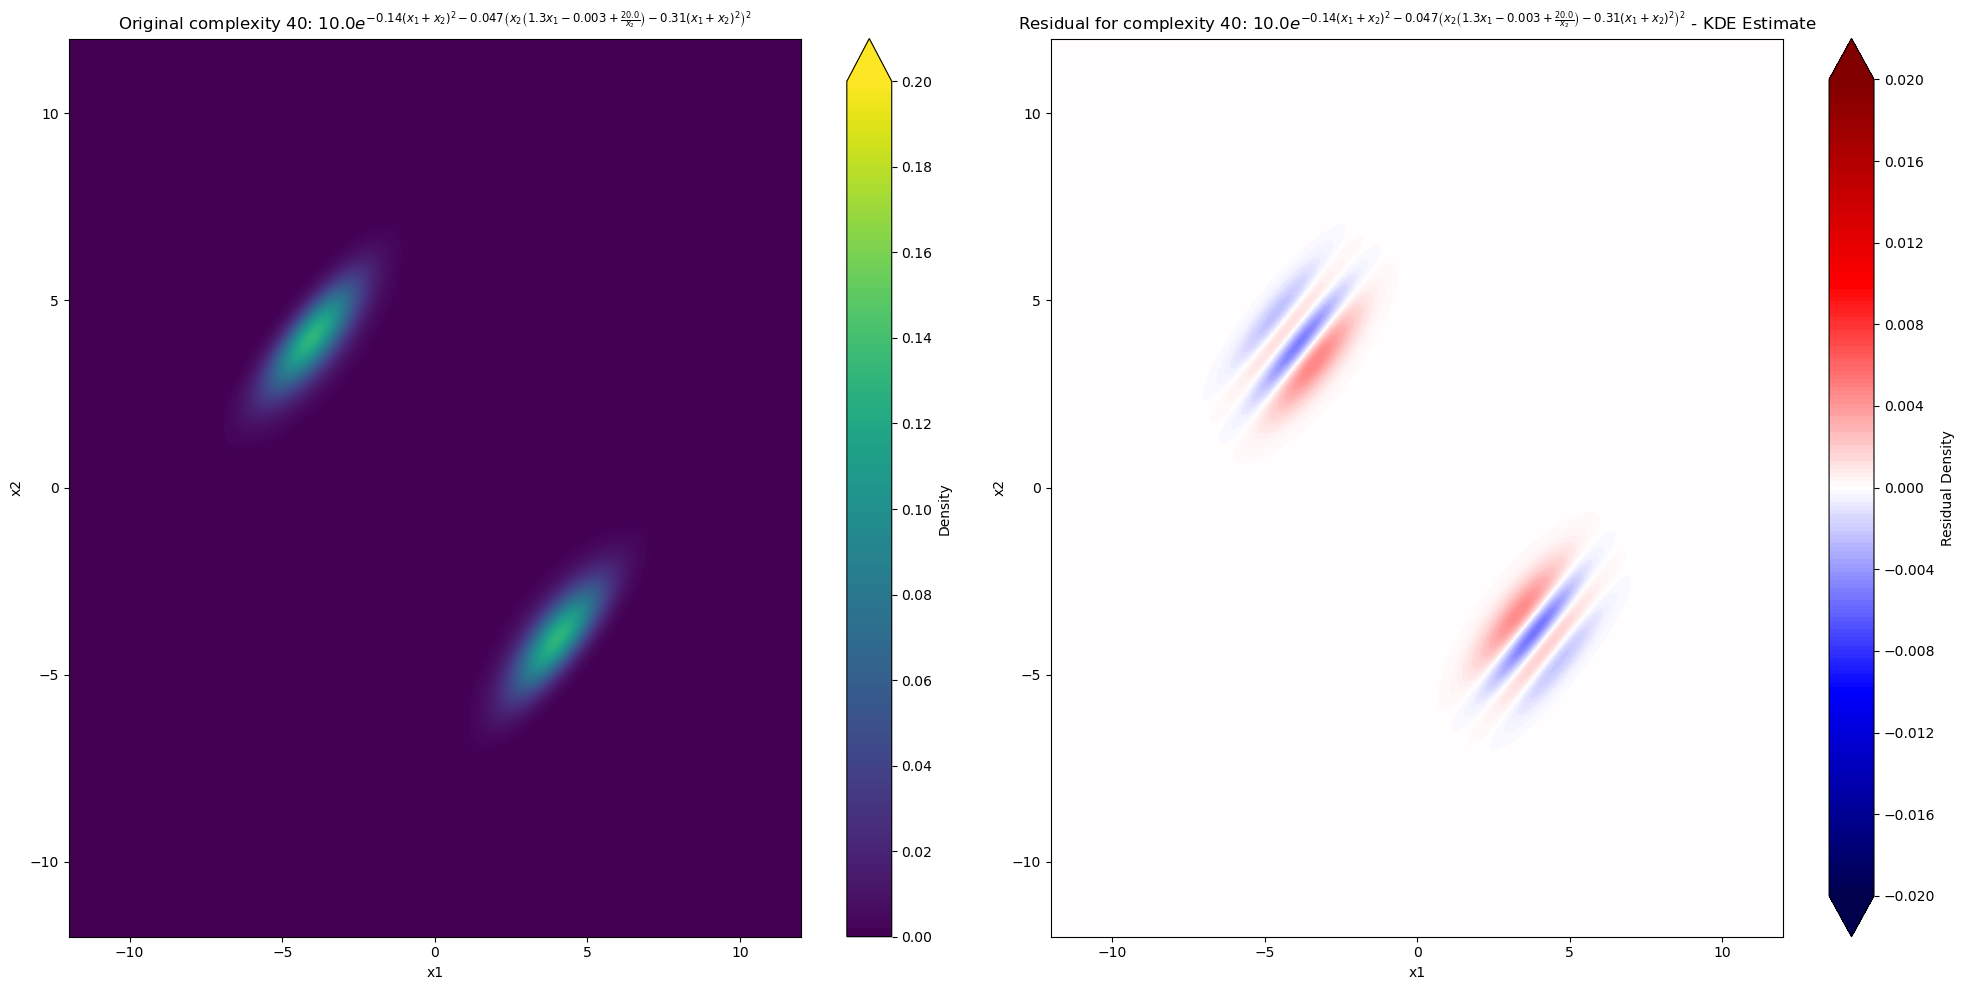

Complexity 40: Likelihood score: -151,336.18663443773
complexity 40 :: min predict: 0.00, max predict: 0.13
complexity 40 :: min residual: -0.01, max residual: 0.00
Complexity 40: MSE error: 1.158527e-03


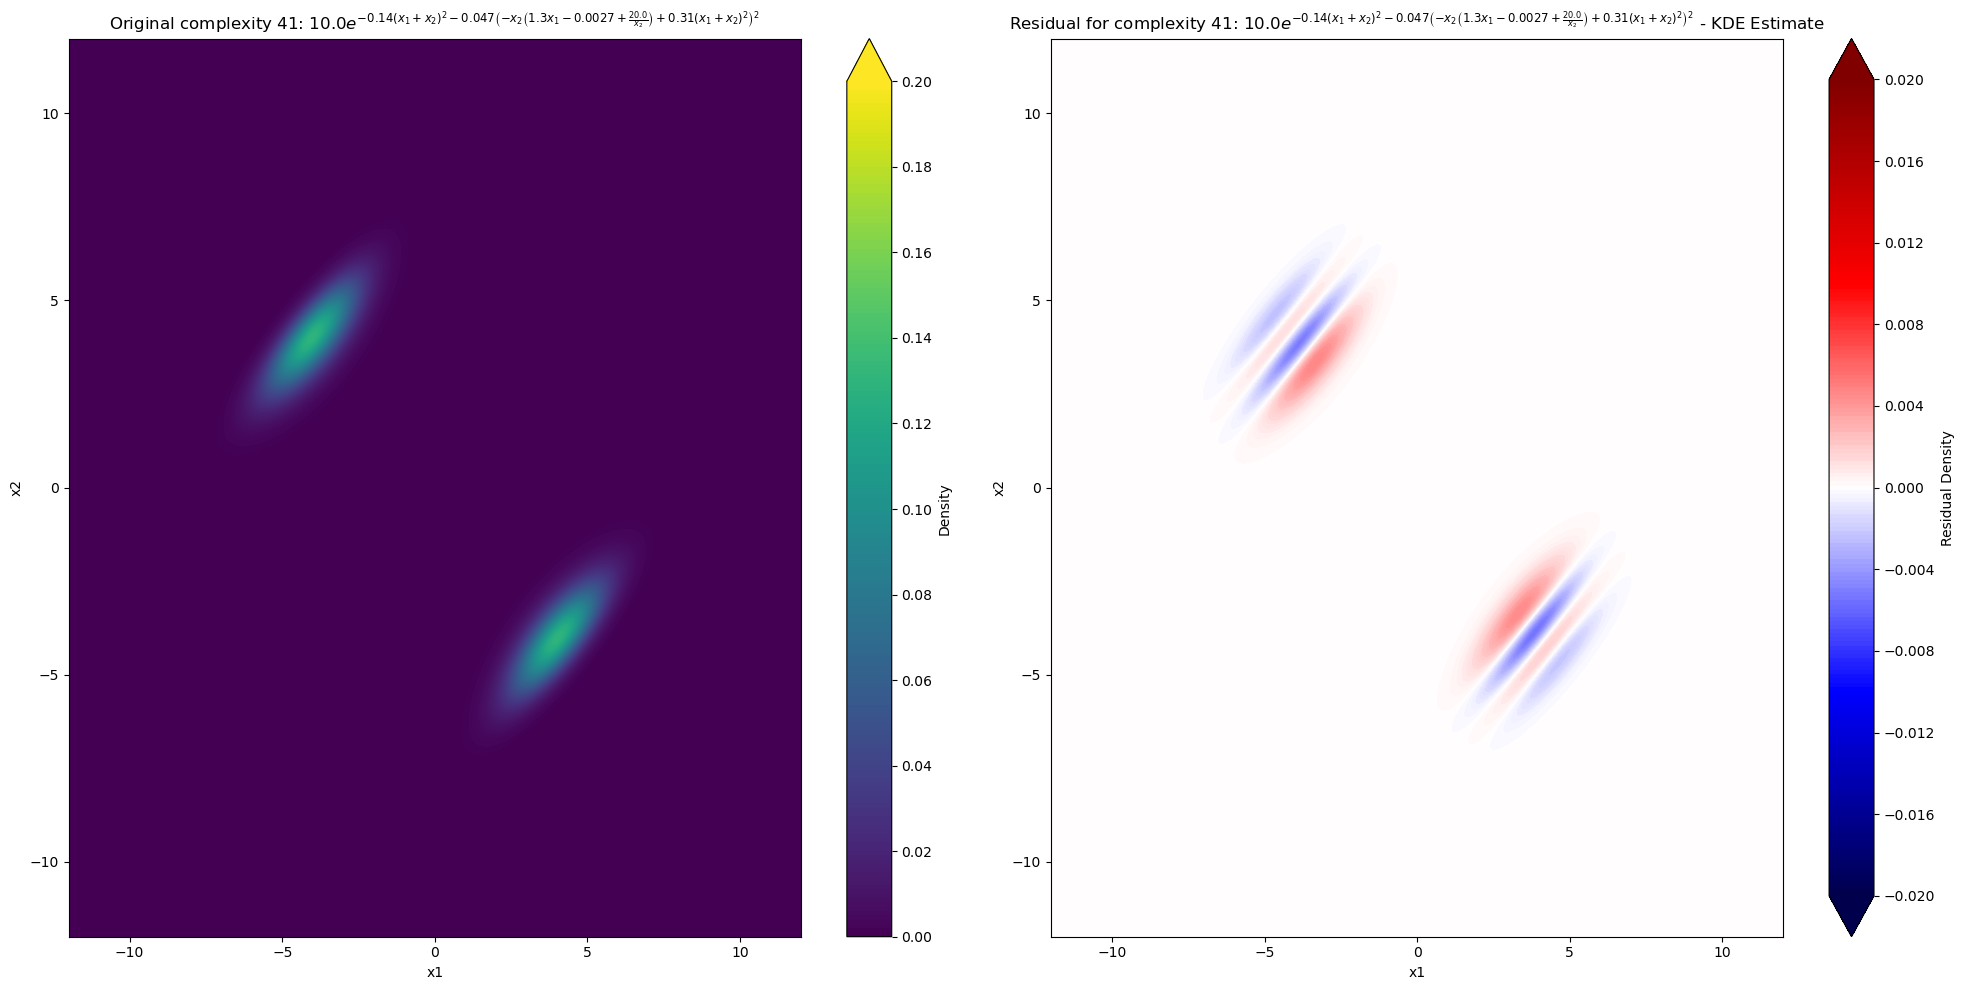

Complexity 41: Likelihood score: -151,336.0736163875
complexity 41 :: min predict: 0.00, max predict: 0.13
complexity 41 :: min residual: -0.01, max residual: 0.00
Complexity 41: MSE error: 1.157107e-03


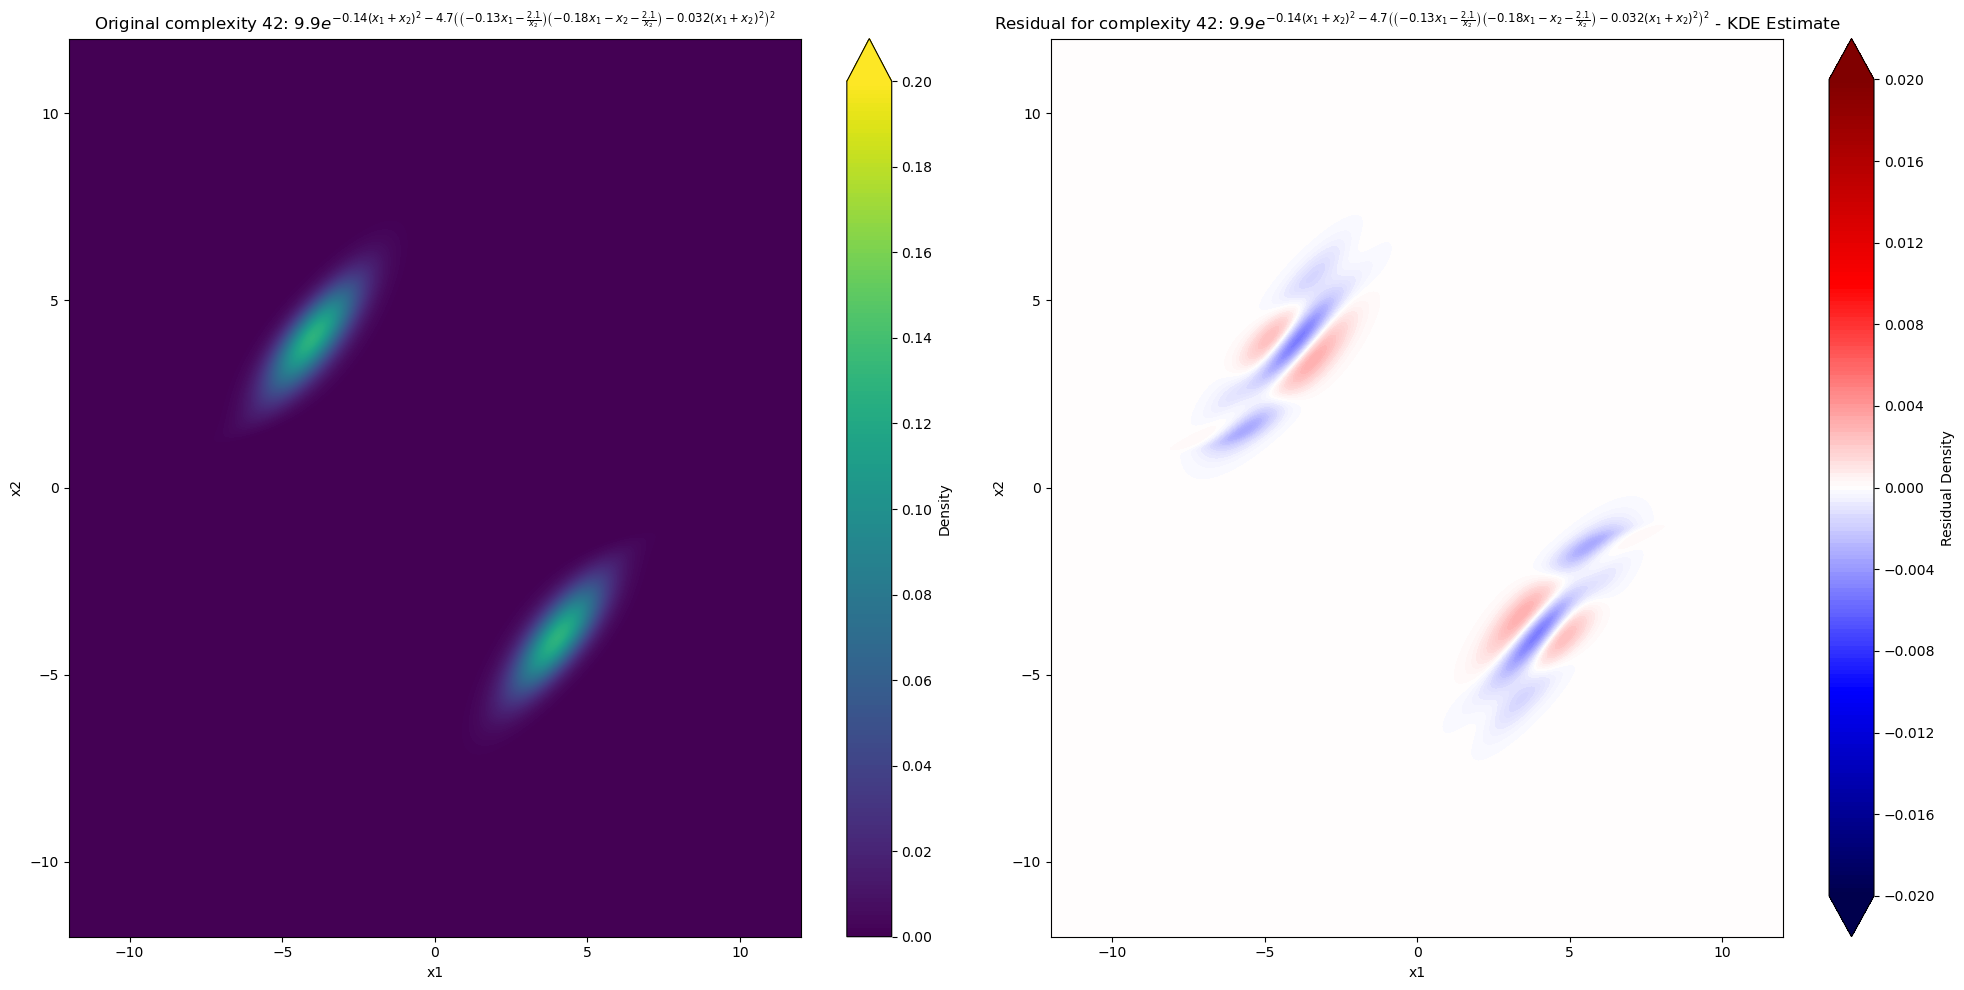

Complexity 42: Likelihood score: -inf
complexity 42 :: min predict: 0.00, max predict: 0.13
complexity 42 :: min residual: -0.01, max residual: 0.00
Complexity 42: MSE error: 9.079877e-04


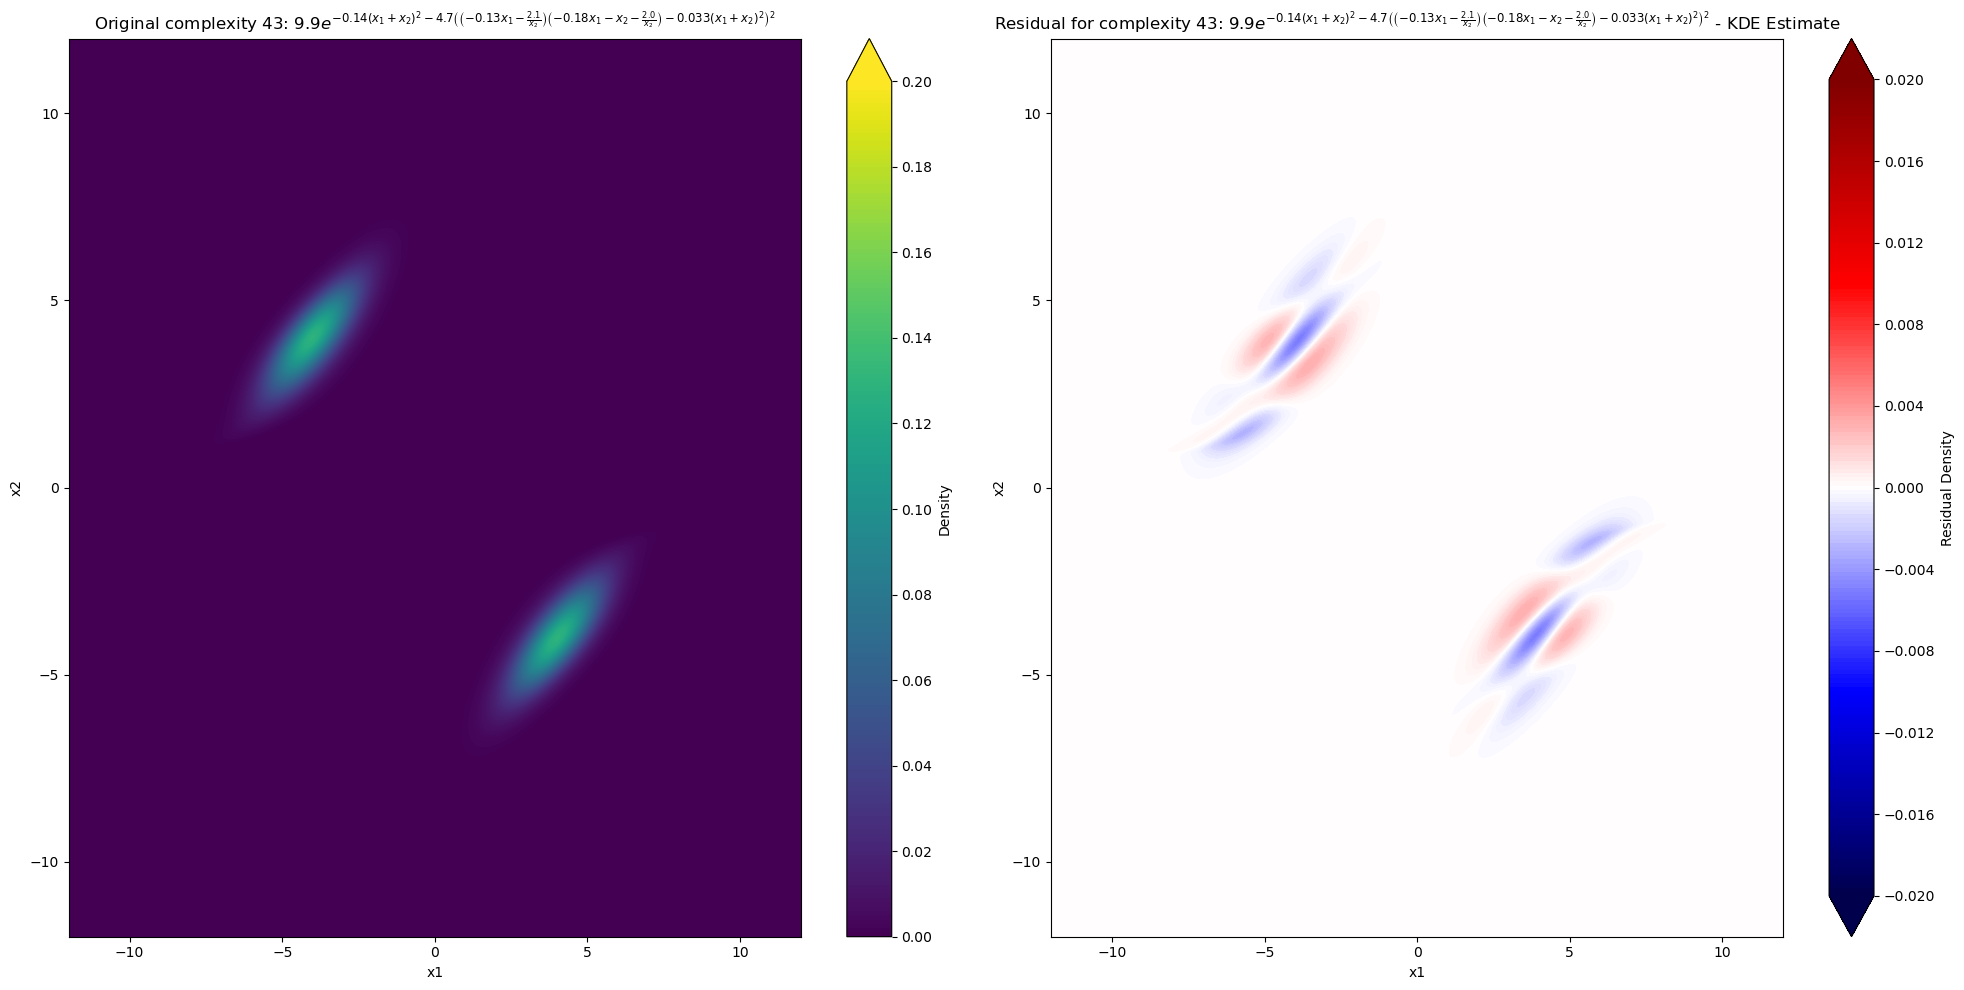

Complexity 43: Likelihood score: -inf
complexity 43 :: min predict: 0.00, max predict: 0.13
complexity 43 :: min residual: -0.01, max residual: 0.00
Complexity 43: MSE error: 7.708521e-04


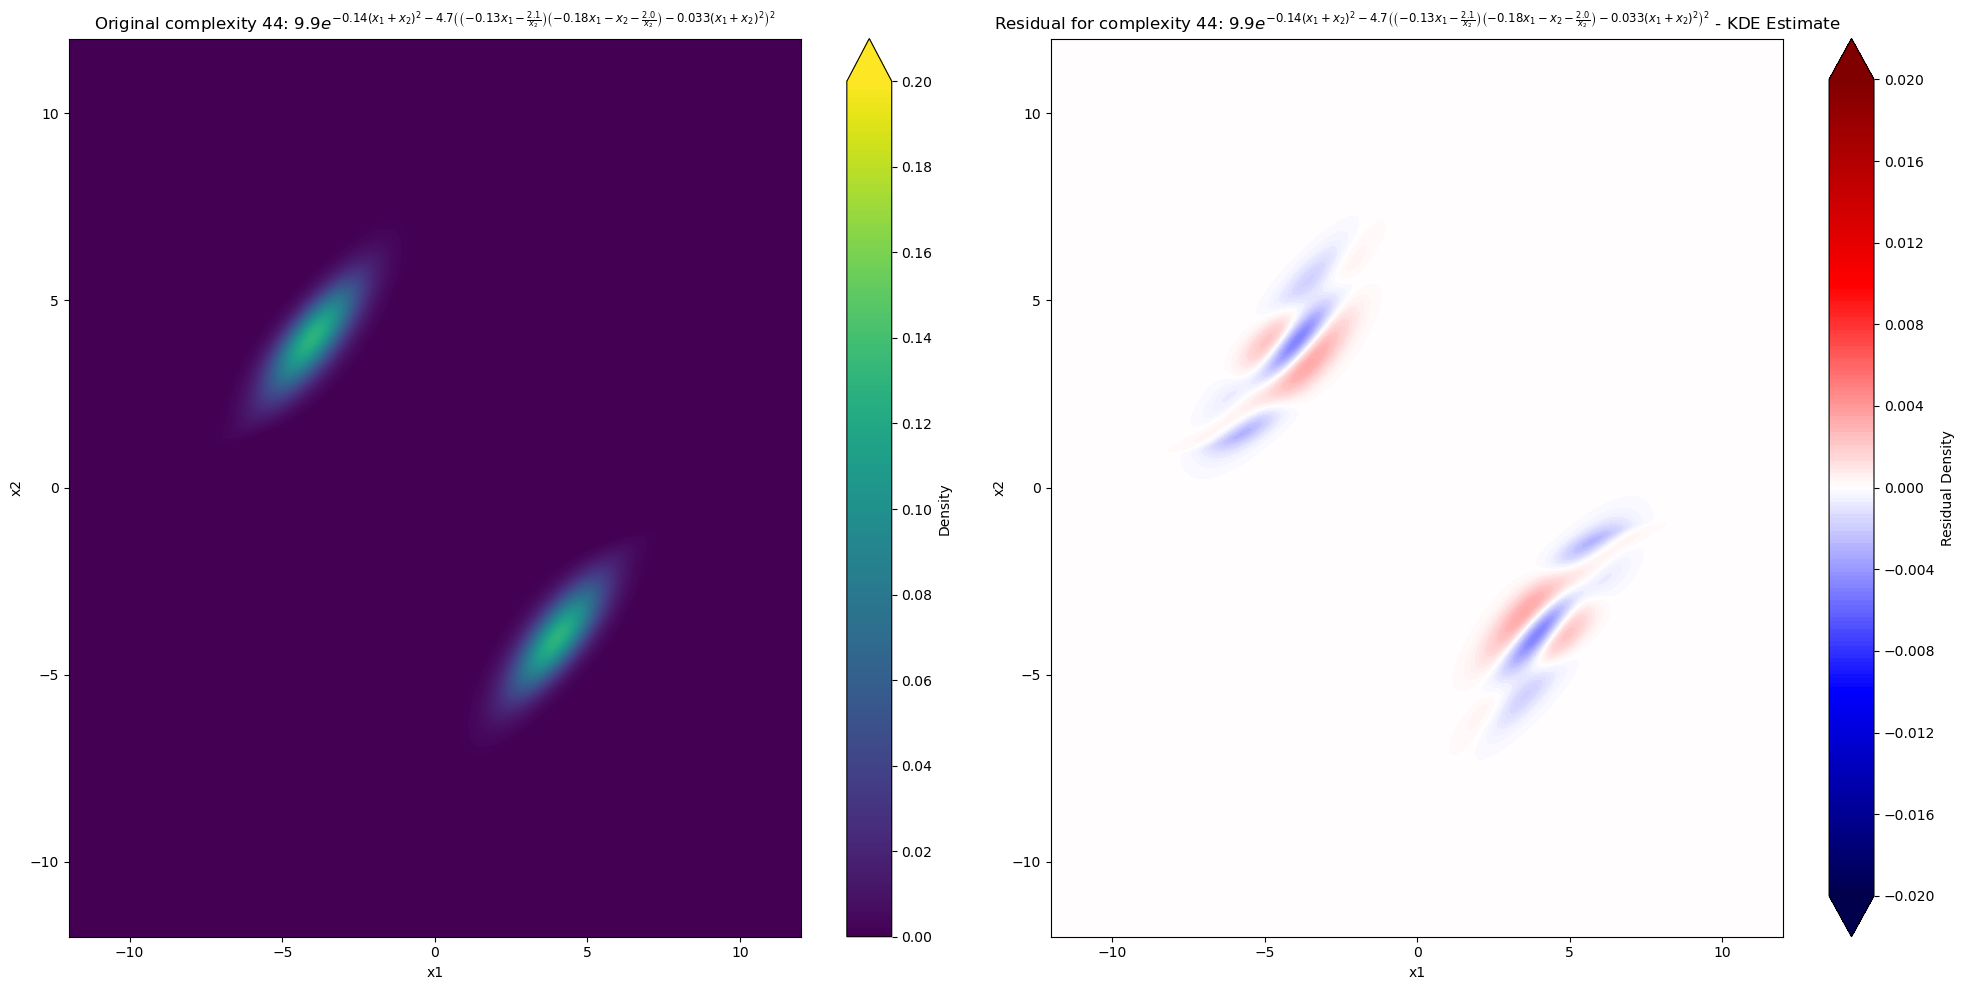

Complexity 44: Likelihood score: -inf
complexity 44 :: min predict: 0.00, max predict: 0.13
complexity 44 :: min residual: -0.00, max residual: 0.00
Complexity 44: MSE error: 7.595855e-04


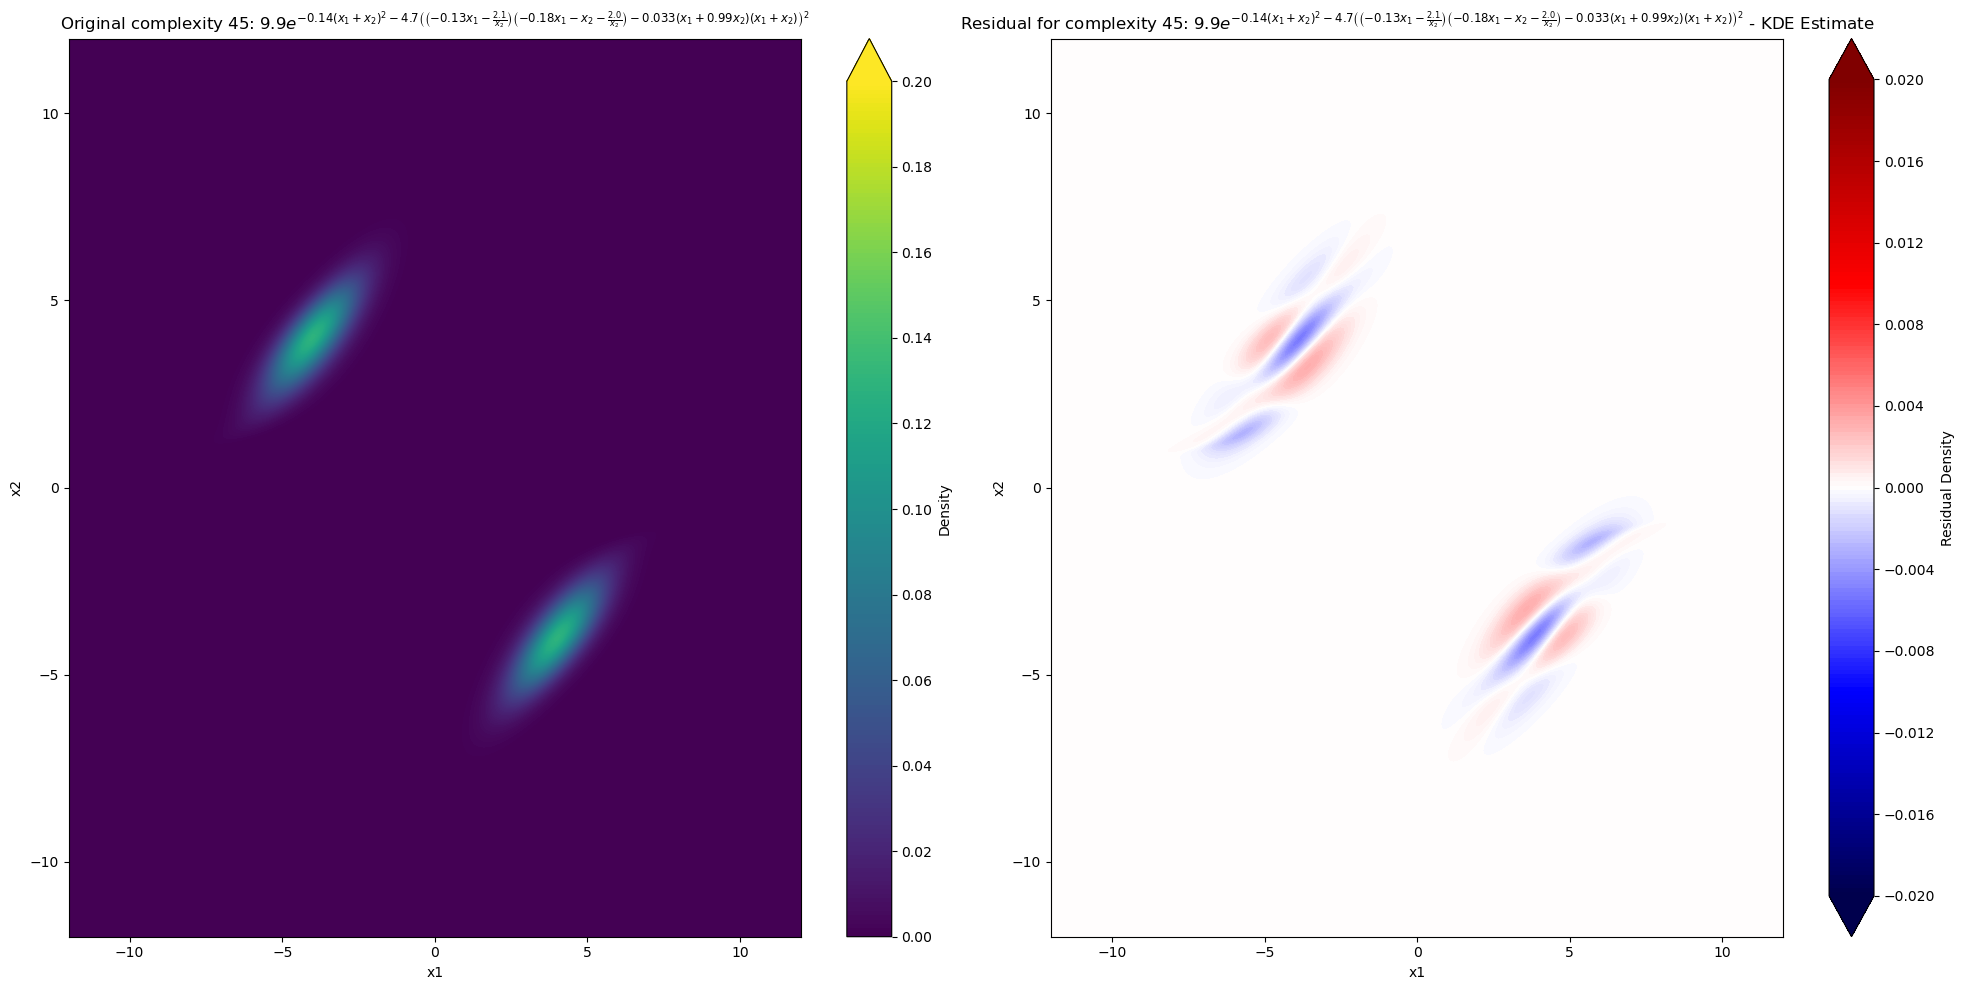

Complexity 45: Likelihood score: -inf
complexity 45 :: min predict: 0.00, max predict: 0.13
complexity 45 :: min residual: -0.01, max residual: 0.00
Complexity 45: MSE error: 7.601684e-04


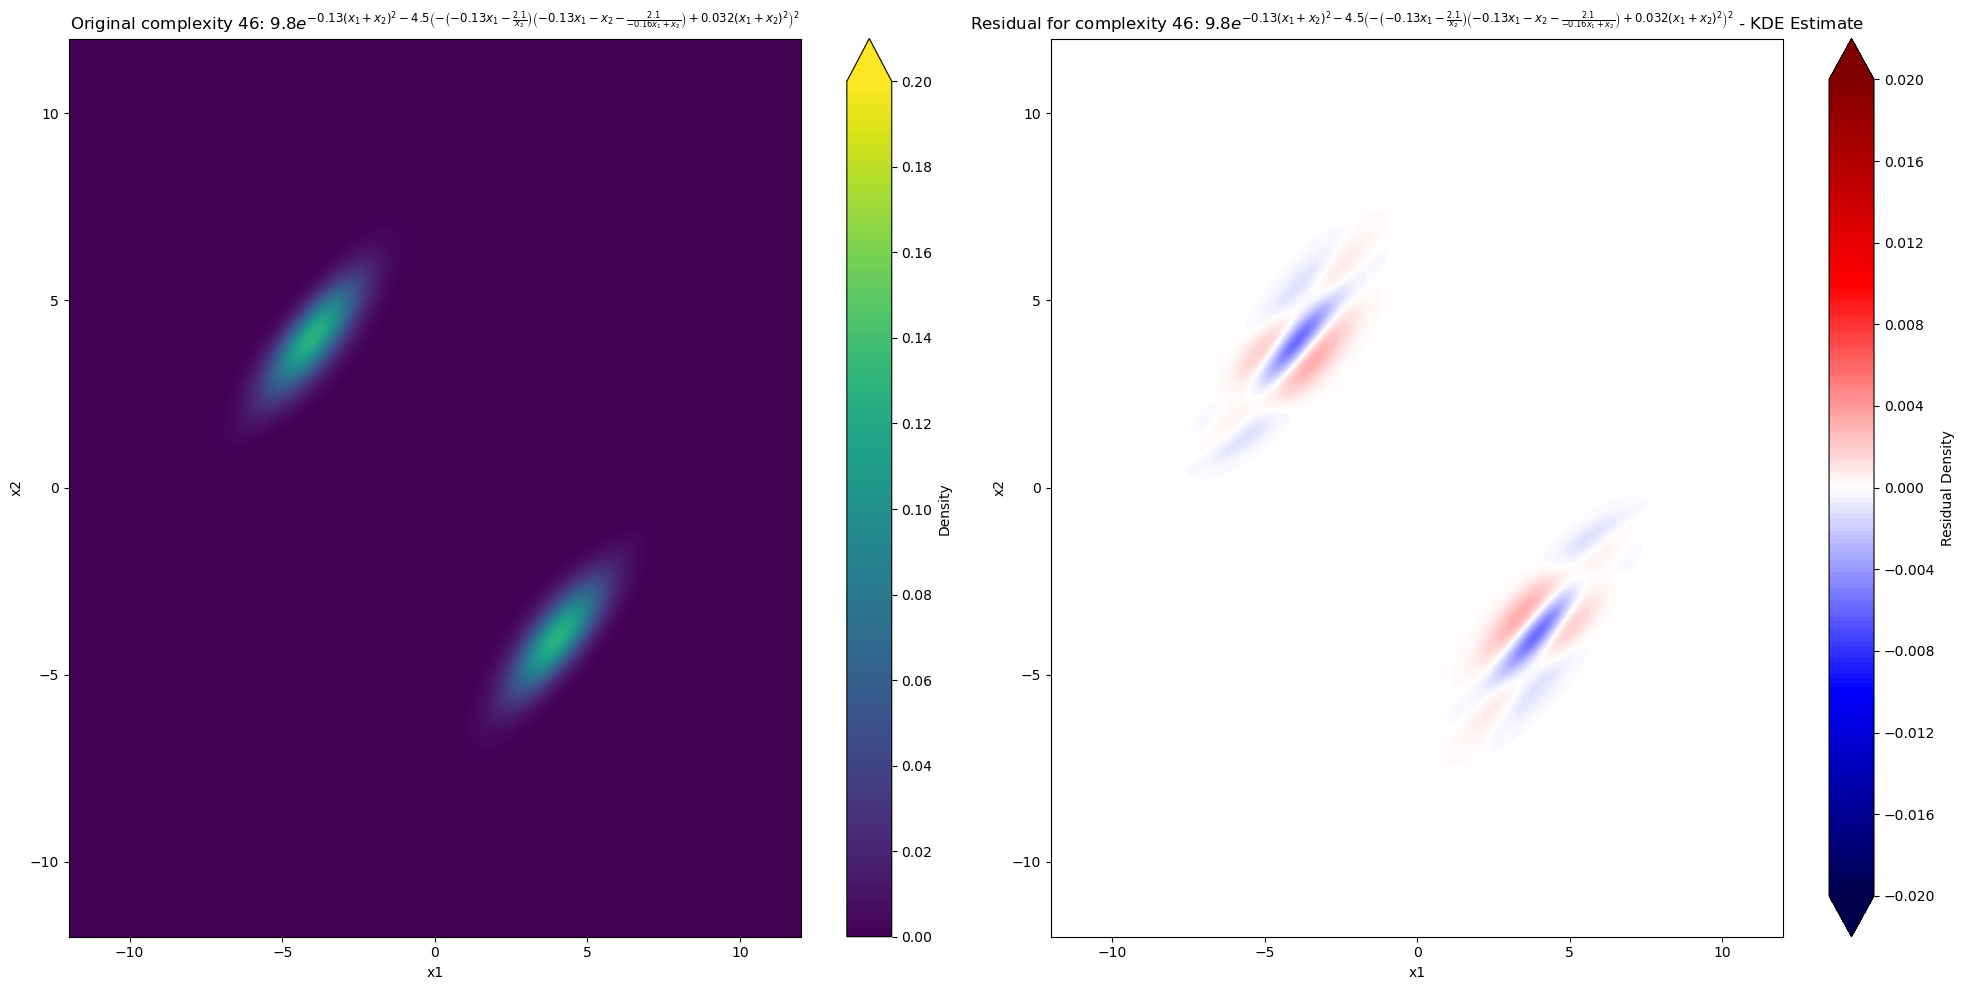

Complexity 46: Likelihood score: -inf
complexity 46 :: min predict: 0.00, max predict: 0.13
complexity 46 :: min residual: -0.01, max residual: 0.00
Complexity 46: MSE error: 7.676857e-04


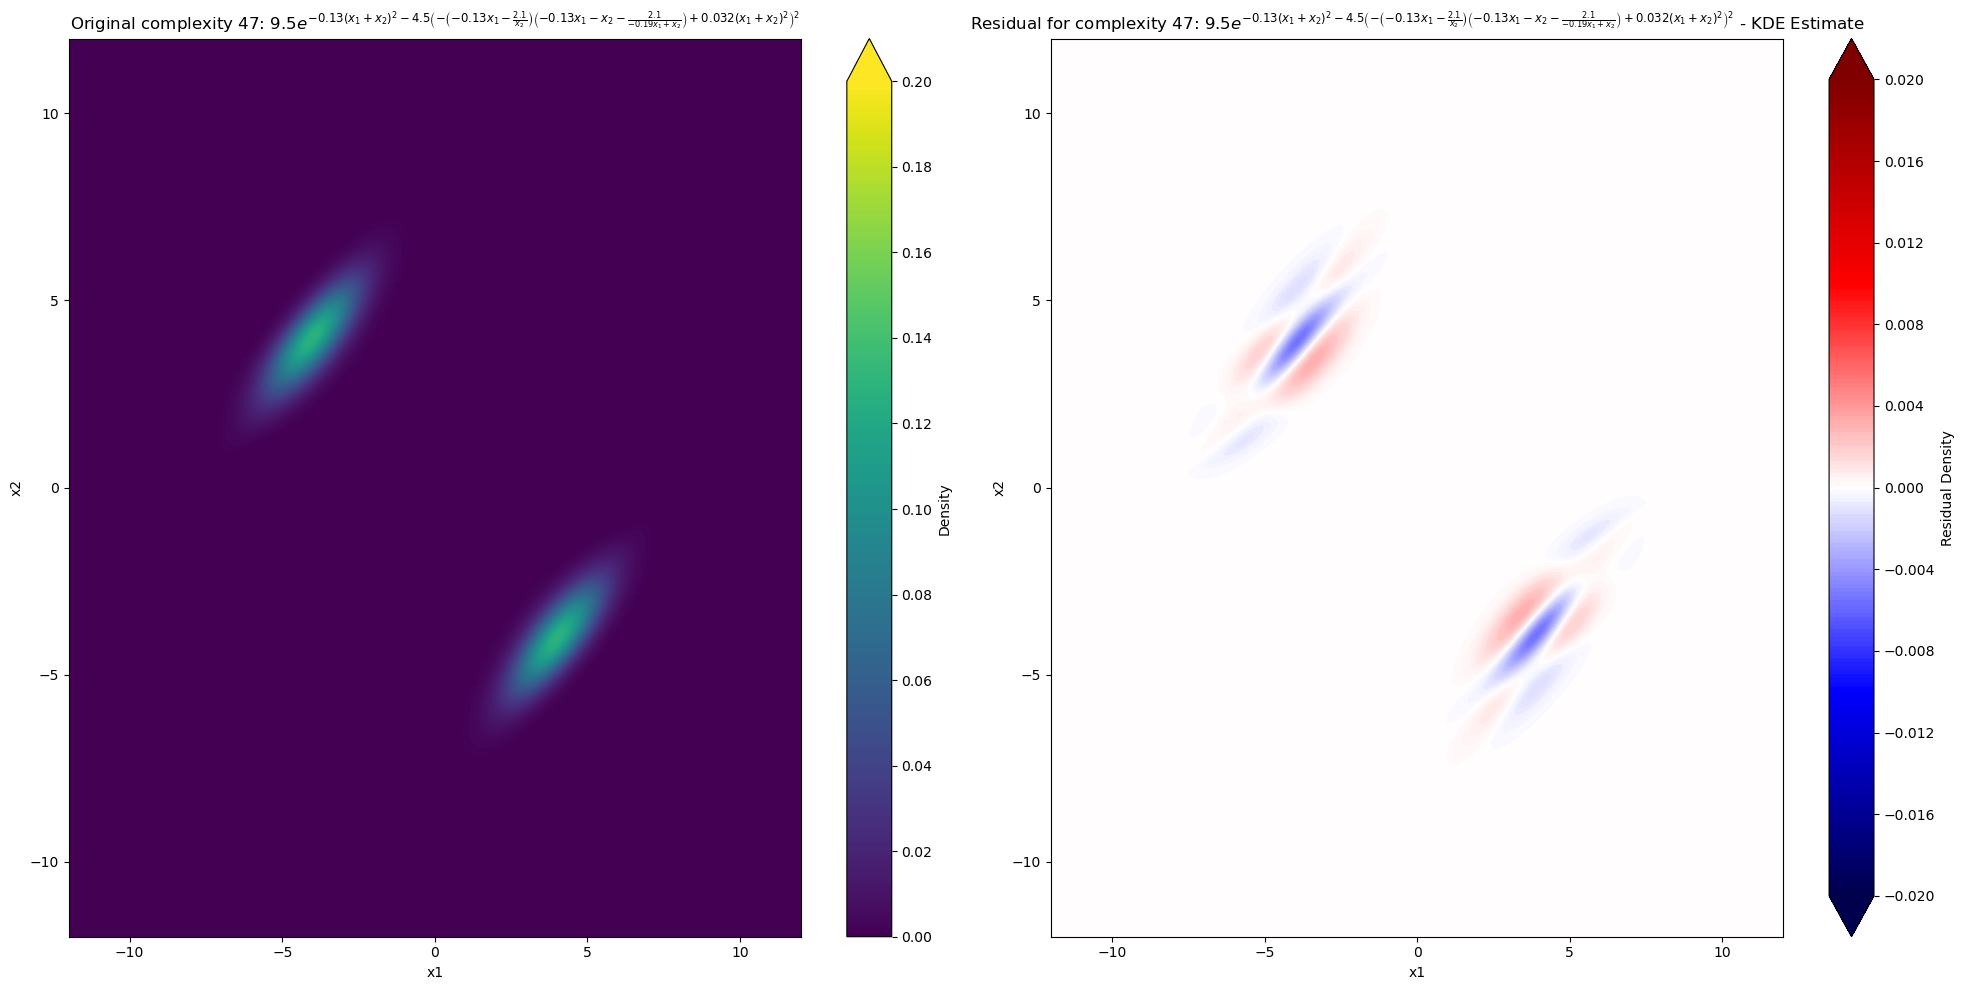

Complexity 47: Likelihood score: -inf
complexity 47 :: min predict: 0.00, max predict: 0.13
complexity 47 :: min residual: -0.01, max residual: 0.00
Complexity 47: MSE error: 7.186333e-04


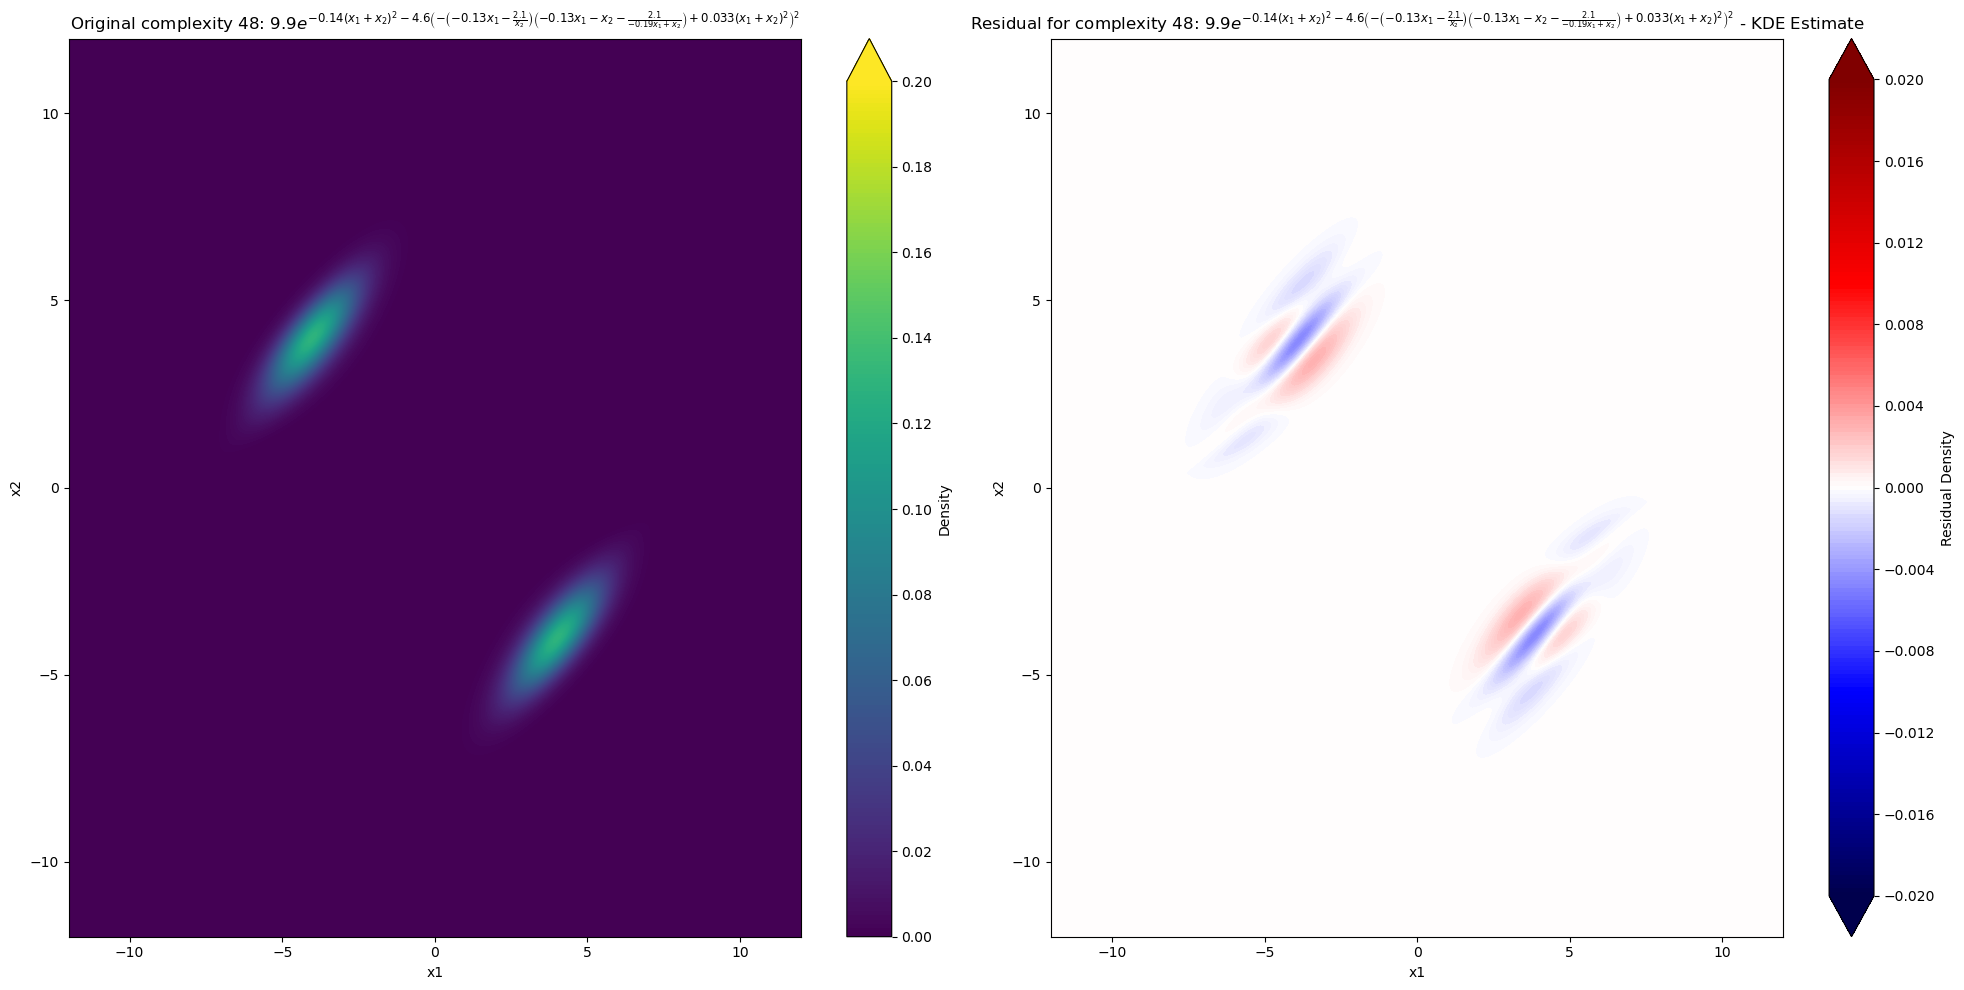

Complexity 48: Likelihood score: -inf
complexity 48 :: min predict: 0.00, max predict: 0.13
complexity 48 :: min residual: -0.00, max residual: 0.00
Complexity 48: MSE error: 6.075264e-04
Finished generating and saving plots for 38 functions.


In [ ]:
# Iterate over the masked_functions list
grid_coordinates = np.vstack([grids[0].ravel(), grids[1].ravel(), grids[2].ravel(), grids[3].ravel()])
grid_coordinates = grid_coordinates.T

grid_axes = [
        grids[0][:,0,0,0],  # x1
        grids[1][0,:,0,0],  # x2
        grids[2][0,0,:,0],  # x3
        grids[3][0,0,0,:]   # x4
    ]

for i, current_function in enumerate(predicted_functions):
    # Skip if the function is not defined or you only want to plot specific ones
    # if i not in [2, 5]:  # Example: plot only indices 2 and 5
    #     continue
    
    func_predicted_density = current_function(grid_coordinates[:,0], grid_coordinates[:,1], grid_coordinates[:,2], grid_coordinates[:,3])/density_scale_factor
    if func_predicted_density.size==1:
        func_predicted_density = func_predicted_density*np.ones(grid_coordinates[:,0].shape)
    func_predicted_density = func_predicted_density.reshape(grids[0].shape)

    func_total_mass = np.trapezoid(
        np.trapezoid(
          np.trapezoid(
            np.trapezoid(func_predicted_density, x=grid_axes[3], axis=3),
          x=grid_axes[2], axis=2),
        x=grid_axes[1], axis=1),
      x=grid_axes[0], axis=0)

    X1, X2, func12_joint_density_on_slice, func12_conditional_density, func12_marginal_for_slice, func12_marginal_density = conditional_and_marginal_generation(
        joint_density=func_predicted_density,
        grids=grids,
        conditioning_xa_target=-4.0,
        conditioning_xb_target=4.0,
        ab_idx = (3,4),
        plot=False,
        log_plot=False,      # use log scale for tail densities
        trapz_tol=1e-20,    # lower tolerance to accept tiny marginals
        total_mass = func_total_mass
    )

    X3, X4, func34_joint_density_on_slice, func34_conditional_density, func34_marginal_for_slice, func34_marginal_density = conditional_and_marginal_generation(
        joint_density=func_predicted_density,
        grids=grids,
        conditioning_xa_target=4.0,
        conditioning_xb_target=-4.0,
        ab_idx = (1,2),
        plot=False,
        log_plot=False,      # use log scale for tail densities
        trapz_tol=1e-20,    # lower tolerance to accept tiny marginals
    )
    
    # Get the title for the current function
    title = latex_labels[i]

    fig, axs = plt.subplots(1, 4, figsize=(28, 6))

    cf00 = axs[0].contourf(X1, X2, func12_conditional_density, levels=levels_results, cmap="viridis", extend="max")
    fig.colorbar(cf00, ax=axs[0])
    axs[0].set_title("p(x1, x2 | x3=-4.0, x4=4.0)")
    axs[0].set_xlim([-4, 12])
    axs[0].set_ylim([-12, 4])
    axs[0].set_xlabel("x1")
    axs[0].set_ylabel("x2")

    cf01 = axs[1].contourf(X1, X2, func12_marginal_density, levels=levels_results, cmap="viridis", extend="max")
    fig.colorbar(cf01, ax=axs[1])
    axs[1].set_title("Marginal p(x1, x2)")
    axs[1].set_xlim([-4, 12])
    axs[1].set_ylim([-12, 4])
    axs[1].set_xlabel("x1")
    axs[1].set_ylabel("x2")

    cf10 = axs[2].contourf(X3, X4, func34_conditional_density, levels=levels_results, cmap="viridis", extend="max")
    fig.colorbar(cf10, ax=axs[2])
    axs[2].set_title("p(x3, x4 | x1=4.0, x2=-4.0)")
    axs[2].set_xlim([-12, 4])
    axs[2].set_ylim([-4, 12])
    axs[2].set_xlabel("x3")
    axs[2].set_ylabel("x4")

    cf11 = axs[3].contourf(X3, X4, func34_marginal_density, levels=levels_results, cmap="viridis", extend="max")
    fig.colorbar(cf11, ax=axs[3])
    axs[3].set_title("Marginal p(x3, x4)")
    axs[3].set_xlim([-12, 4])
    axs[3].set_ylim([-4, 12])
    axs[2].set_xlabel("x3")
    axs[2].set_ylabel("x4")
    plt.tight_layout()
    plt.show()
    plt.close(fig) 
    gc.collect()

    fig, axs = plt.subplots(1, 4, figsize=(28, 6))

    cf00 = axs[0].contourf(X1, X2, func12_conditional_density - ground_truth_cluster_1(X1, X2), levels=levels_results_residuals, cmap="seismic", extend="both")
    fig.colorbar(cf00, ax=axs[0])
    axs[0].set_title("Residual p(x1, x2 | x3=-4.0, x4=4.0)")
    axs[0].set_xlim([-4, 12])
    axs[0].set_ylim([-12, 4])
    axs[0].set_xlabel("x1")
    axs[0].set_ylabel("x2")

    cf01 = axs[1].contourf(X1, X2, func12_marginal_density - ground_truth_cluster_1(X1, X2), levels=levels_results_residuals, cmap="seismic", extend="both")
    fig.colorbar(cf01, ax=axs[1])
    axs[1].set_title("Residual Marginal p(x1, x2)")
    axs[1].set_xlim([-4, 12])
    axs[1].set_ylim([-12, 4])
    axs[1].set_xlabel("x1")
    axs[1].set_ylabel("x2")

    cf10 = axs[2].contourf(X3, X4, func34_conditional_density - ground_truth_cluster_2(X3, X4), levels=levels_results_residuals, cmap="seismic", extend="both")
    fig.colorbar(cf10, ax=axs[2])
    axs[2].set_title("Residual p(x3, x4 | x1=4.0, x2=-4.0)")
    axs[2].set_xlim([-12, 4])
    axs[2].set_ylim([-4, 12])
    axs[2].set_xlabel("x3")
    axs[2].set_ylabel("x4")

    cf11 = axs[3].contourf(X3, X4, func34_marginal_density - ground_truth_cluster_2(X3, X4), levels=levels_results_residuals, cmap="seismic", extend="both")
    fig.colorbar(cf11, ax=axs[3])
    axs[3].set_title("Residual Marginal p(x3, x4)")
    axs[3].set_xlim([-12, 4])
    axs[3].set_ylim([-4, 12])
    axs[2].set_xlabel("x3")
    axs[2].set_ylabel("x4")
    plt.tight_layout()
    plt.show()
    plt.close(fig) 
    gc.collect()
    
    prediction_eval_at_samples = current_function(test_samples[:,0], test_samples[:,1], test_samples[:,2], test_samples[:,3])
    likelihood_score_of_prediction = np.sum(np.log(prediction_eval_at_samples/density_scale_factor))
    print(f"Complexity {complexity[i]}: Likelihood score: {likelihood_score_of_prediction:,}")
    print(f"complexity {complexity[i]} :: min predict conditional 12: {np.min(func12_conditional_density)}, max predict conditional 12: {np.max(func12_conditional_density)}")
    print(f"complexity {complexity[i]} :: min predict marginal 12: {np.min(func12_marginal_density)}, max predict marginal 12: {np.max(func12_marginal_density)}")
    print(f"complexity {complexity[i]} :: min predict conditional 34: {np.min(func34_conditional_density)}, max predict conditional 34: {np.max(func34_conditional_density)}")
    print(f"complexity {complexity[i]} :: min predict marginal 34: {np.min(func34_marginal_density)}, max predict marginal 34: {np.max(func34_marginal_density)}")

    print(f"max conditional p(x1,x2|x3=-4,x4=4) residual = {np.max(func12_conditional_density - ground_truth_cluster_1(X1, X2))}")
    print(f"max conditional p(x3,x4|x1=4,x2=-4) residual = {np.max(func34_conditional_density - ground_truth_cluster_2(X3, X4))}")
    print(f"max marginal p(x1,x2) residual = {np.max(func12_conditional_density - ground_truth_cluster_1(X1, X2))}")
    print(f"max marginal p(x3,x4) residual = {np.max(func34_conditional_density - ground_truth_cluster_2(X3, X4))}\n")
    
    del func_predicted_density


# Note: plt.show() is typically outside the loop if you want to see all plots
# or not used at all if you are just saving the files.
print(f"Finished generating and saving plots for {len(predicted_functions)} functions.")